In [1]:
# imports
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels
import statsmodels.api as sm

# Read data

In [2]:
# read data into a DataFrame
df = pd.read_csv("Data/need_2021_anon_dataset_50k.csv")

print(df.shape)

(50000, 75)


In [3]:
df.head()

PROP_TYPE  PROP_AGE_BAND  FLOOR_AREA_BAND  CONSERVATORY_FLAG  \
0    Mid terrace              2                3                NaN   
1           Flat              3                2                NaN   
2    Mid terrace              1                3                NaN   
3           Flat              4                1                0.0   
4  Semi detached              2                2                NaN   

  COUNCIL_TAX_BAND  IMD_BAND_ENG  IMD_BAND_WALES     REGION  LI_FLAG  LI_DATE  \
0                B           2.0             NaN  E12000005        0      NaN   
1                A           1.0             NaN  E12000008        0      NaN   
2                A           2.0             NaN  E12000001        0      NaN   
3                A           3.0             NaN  E12000004        0      NaN   
4                D           5.0             NaN  E12000008        0      NaN   

   ...  ElecValFlag2014  ElecValFlag2013  ElecValFlag2012  ElecValFlag2011  \
0  ...                V                E                E                V   
1  ...                V                V                V                V   
2  ...                V                V                V                V   
3  ...                O                O                O                O   
4  ...                V                V                V                V   

   ElecValFlag2010  ElecValFlag2009  ElecValFlag2008  ElecValFlag2007  \
0                E                V                V                V   
1                V                V                V                V   
2                V                V                V                V   
3                O                O                O                O   
4                V                V                V                V   

   ElecValFlag2006  ElecValFlag2005  
0                V                V  
1                V                V  
2                V                V  
3                O                O  
4                V                V  

[5 rows x 75 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 75 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PROP_TYPE          50000 non-null  object 
 1   PROP_AGE_BAND      50000 non-null  int64  
 2   FLOOR_AREA_BAND    50000 non-null  int64  
 3   CONSERVATORY_FLAG  7418 non-null   float64
 4   COUNCIL_TAX_BAND   50000 non-null  object 
 5   IMD_BAND_ENG       47410 non-null  float64
 6   IMD_BAND_WALES     2590 non-null   float64
 7   REGION             50000 non-null  object 
 8   LI_FLAG            50000 non-null  int64  
 9   LI_DATE            8568 non-null   float64
 10  CWI_FLAG           50000 non-null  int64  
 11  CWI_DATE           8412 non-null   float64
 12  PV_FLAG            50000 non-null  int64  
 13  PV_DATE            561 non-null    float64
 14  MAIN_HEAT_FUEL     50000 non-null  int64  
 15  Gcons2019          40329 non-null  float64
 16  Gcons2018          403

# Wrangle data
## Select rows

In [5]:
# Select rows where the 'IMD_BAND_ENG' column is not NaN
df = df[df['IMD_BAND_ENG'].notna()]

print(df.shape)

(47410, 75)


## Select columns

In [6]:
columns_of_interest = [
    'PROP_TYPE', 'PROP_AGE_BAND', 'FLOOR_AREA_BAND', 'COUNCIL_TAX_BAND',
    'IMD_BAND_ENG', 'REGION', 'LI_FLAG', 'CWI_FLAG', 'PV_FLAG', 'MAIN_HEAT_FUEL',
    'Gcons2019', 'Gcons2018', 'Gcons2017', 'Gcons2016', 'Gcons2015', 'Gcons2014', 'Gcons2013', 'Gcons2012', 'Gcons2011', 'Gcons2010', 'Gcons2009', 'Gcons2008', 'Gcons2007', 'Gcons2006', 'Gcons2005',
    'Econs2019', 'Econs2018', 'Econs2017', 'Econs2016', 'Econs2015', 'Econs2014', 'Econs2013', 'Econs2012', 'Econs2011', 'Econs2010', 'Econs2009', 'Econs2008', 'Econs2007', 'Econs2006', 'Econs2005'
]

df_filtered = df[columns_of_interest].copy()
print(df_filtered.shape)

(47410, 40)


## Handle outliers

In [7]:
numerical_cols = [f'Gcons{i}' for i in range(2019, 2004, -1)] + [f'Econs{i}' for i in range(2019, 2004, -1)]
for col in numerical_cols:
    Q1 = df_filtered[col].quantile(0.25)
    Q3 = df_filtered[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered.loc[df_filtered[col] < lower_bound, col] = lower_bound
    df_filtered.loc[df_filtered[col] > upper_bound, col] = upper_bound

## Define the data type

In [8]:
categorical_cols = ['PROP_TYPE', 'COUNCIL_TAX_BAND', 'REGION']
other_cols = ['PROP_AGE_BAND', 'FLOOR_AREA_BAND', 'IMD_BAND_ENG', 'LI_FLAG', 'CWI_FLAG', 'PV_FLAG', 'MAIN_HEAT_FUEL']

## Converters and zoomers

In [9]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

## Applicating line converter

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('other', 'passthrough', other_cols)
    ])

## Applicating conversion

In [11]:
df_processed = preprocessor.fit_transform(df_filtered)

In [12]:
# Displays the shape of the processed data
df_processed_shape = df_processed.shape
print (df_processed_shape)

(47410, 60)


In [13]:
# Convert the converted Numpy array back to Pandas DataFrame
# Because the unique thermal encoding creates additional columns, the column names need to be redefined

# Gets the class column name after the unique heat encoding
categories = [f"{col}_{cat}" for col, categories in zip(categorical_cols, preprocessor.named_transformers_['cat'].named_steps['onehot'].categories_) for cat in categories]

# The numeric column and other columns remain unchanged
new_columns = numerical_cols + categories + other_cols

# Create DataFrame
df_processed = pd.DataFrame(df_processed, columns=new_columns)

# Look at the first few lines
print(df_processed.head)

<bound method NDFrame.head of        Gcons2019  Gcons2018  Gcons2017  Gcons2016  Gcons2015  Gcons2014  \
0       0.016052  -0.353765   0.047426  -1.108477  -1.108466  -0.131642   
1      -0.357304  -1.287228  -0.780180  -0.757788  -0.446439  -0.115052   
2      -0.276140  -0.222753  -0.118095   0.227484  -0.976061   0.133803   
3      -1.152715  -1.139839  -1.177431  -0.139905  -0.131977  -0.131642   
4      -0.146277  -0.140870  -0.134648  -0.139905  -0.131977  -0.131642   
...          ...        ...        ...        ...        ...        ...   
47405  -0.422236  -0.386518  -0.267065  -0.223403   0.215588   0.117212   
47406   0.129682  -0.173623  -0.068439  -0.707689  -0.711250  -1.707723   
47407  -0.146277  -0.140870  -1.690547  -1.659561  -1.555335  -1.575000   
47408   1.006257   0.661580   0.626750   0.611573   0.761760   0.697873   
47409   1.606873   1.431277   0.808823   0.778568   0.761760   1.394667   

       Gcons2013  Gcons2012  Gcons2011  Gcons2010  ...  REGION_E12000

In [16]:
output_file_path = "Data/processed_data.csv"
df_processed.to_csv(output_file_path)

# 2 Summary statistics of key fields

### 2.1 Independent variable

In [17]:
# read data
file_path = 'Data/processed_data.csv'  # 更改为您的文件路径
data = pd.read_csv(file_path)

#### 2.1.1 Property Type

In [31]:
# Attribute type fields to be counted
prop_type_columns = ['PROP_TYPE_Bungalow', 'PROP_TYPE_Detached', 'PROP_TYPE_End terrace',
                     'PROP_TYPE_Flat', 'PROP_TYPE_Mid terrace', 'PROP_TYPE_Semi detached']

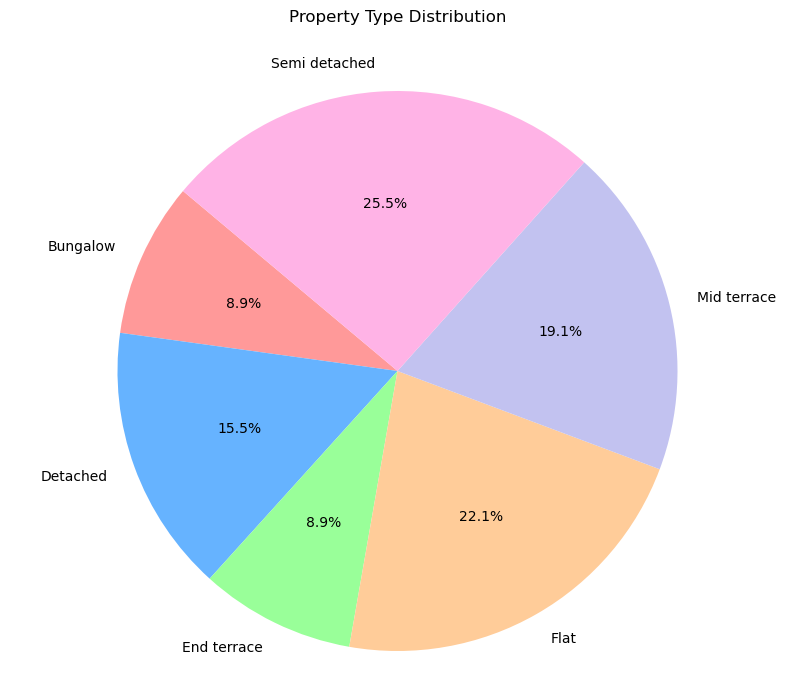

In [34]:
# Calculate the number in each attribute type field
prop_type_counts = data[prop_type_columns].sum()
# Pie charting
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6']
labels = [label.replace('PROP_TYPE_', '') for label in prop_type_columns]

plt.figure(figsize=(10, 8))
plt.pie(prop_type_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Property Type Distribution', pad=30)  
plt.axis('equal')  
plt.show()

#### 2.1.2 Council Tax Band

In [25]:
# Attribute type fields to be counted
council_tax_columns = ['COUNCIL_TAX_BAND_A', 'COUNCIL_TAX_BAND_B', 'COUNCIL_TAX_BAND_C', 'COUNCIL_TAX_BAND_D',
                     'COUNCIL_TAX_BAND_E', 'COUNCIL_TAX_BAND_F', 'COUNCIL_TAX_BAND_G', 'COUNCIL_TAX_BAND_H']

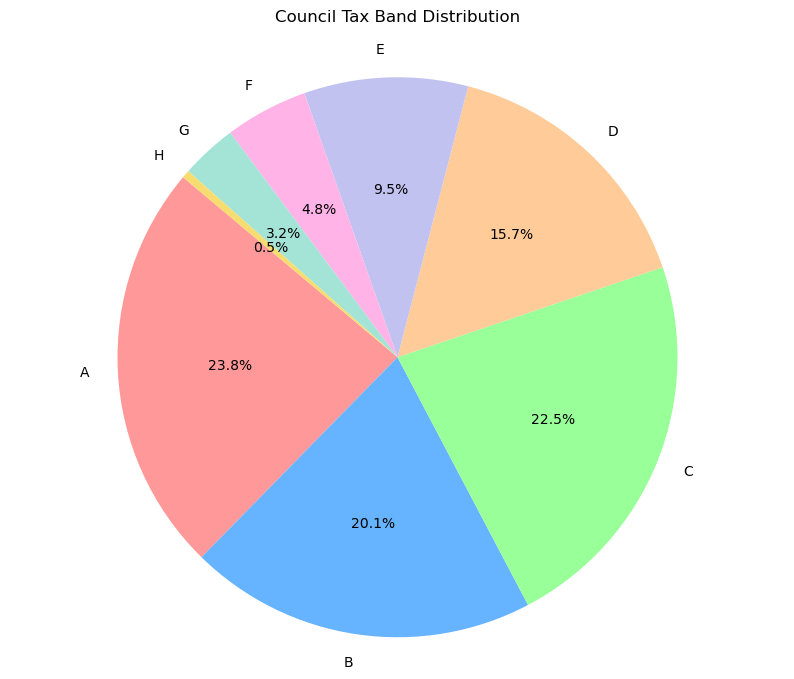

In [49]:
# Calculate the number in each attribute type field
council_tax_counts = data[council_tax_columns].sum()
# Pie charting
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6', '#a3e4d7', '#f7dc6f']
labels = [label.replace('COUNCIL_TAX_BAND_', '') for label in council_tax_columns]

plt.figure(figsize=(10, 8))
plt.pie(council_tax_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Council Tax Band Distribution', pad=20) 
plt.axis('equal') 
plt.show()

#### 2.1.3 Region Band

In [38]:
# Attribute type fields to be counted
region_columns = ['REGION_E12000001', 'REGION_E12000002', 'REGION_E12000003', 'REGION_E12000004', 'REGION_E12000005',
                     'REGION_E12000005', 'REGION_E12000007', 'REGION_E12000008', 'REGION_E12000009']

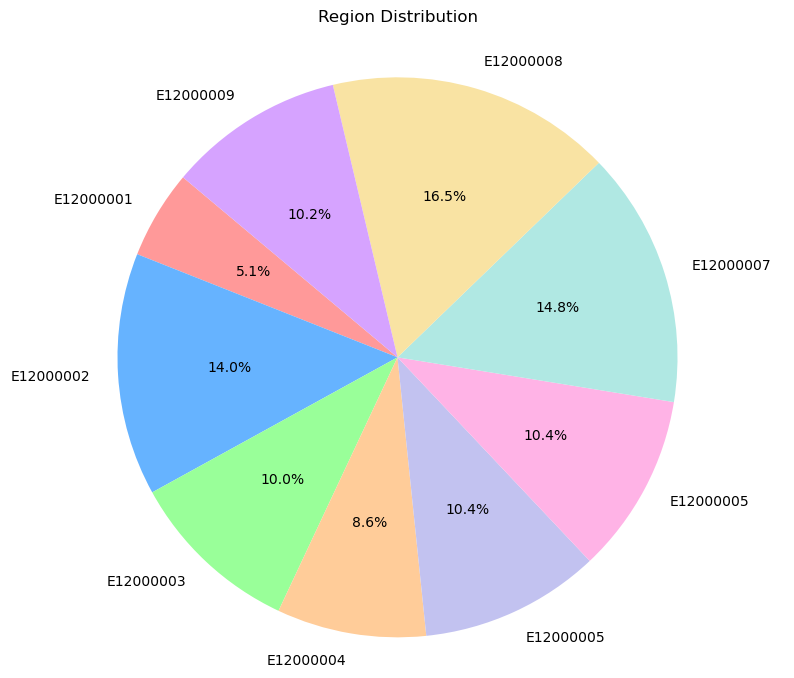

In [43]:
# Calculate the number in each attribute type field
region_columns_counts = data[region_columns].sum()
# Pie charting
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6', '#b0e8e3', '#f9e3a3', '#d6a3ff']
labels = [label.replace('REGION_', '') for label in region_columns]

plt.figure(figsize=(10, 8))
plt.pie(region_columns_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Region Band Distribution', pad=20) 
plt.axis('equal') 
plt.show()

#### 2.1.4 Property Age Band

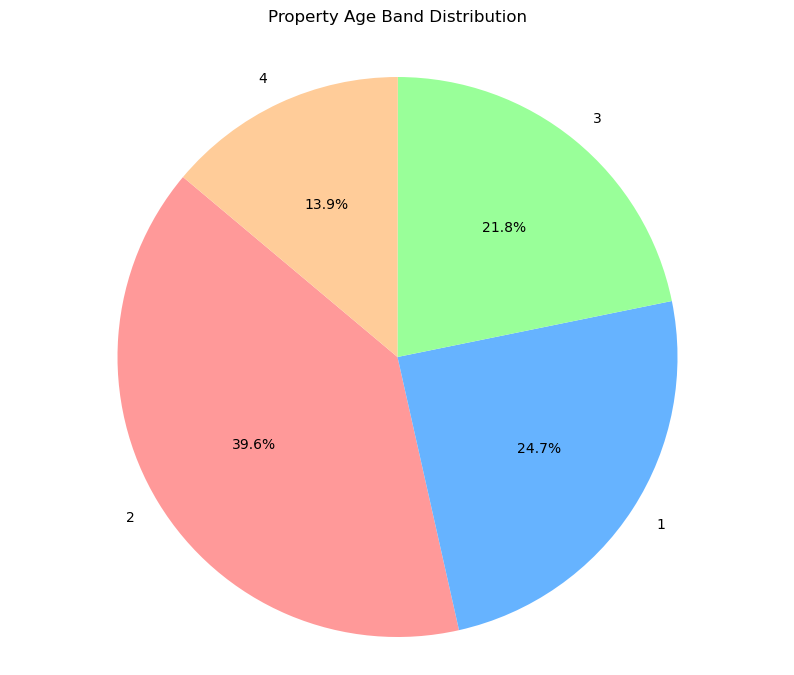

In [50]:
# Check the unique values and counts in the 'PROP_AGE_BAND' column
prop_age_band_counts = data['PROP_AGE_BAND'].value_counts()
# Pie charting
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels_int = prop_age_band_counts.index.astype(int)

plt.figure(figsize=(10, 8))
plt.pie(prop_age_band_counts, labels=labels_int, colors=colors,autopct='%1.1f%%', startangle=140)
plt.title('Property Age Band Distribution', pad=20)
plt.axis('equal')  
plt.show()

#### 2.1.5 Floor Area Band

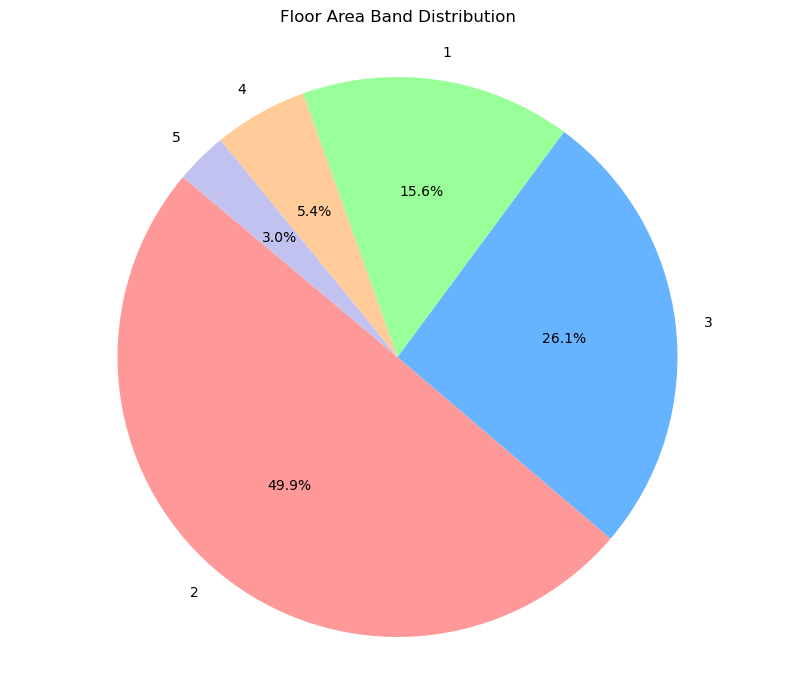

In [55]:
# Check the unique values and counts in the 'FLOOR_AREA_BAND' column
floor_area_band_counts = data['FLOOR_AREA_BAND'].value_counts()
# Pie charting
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']
labels_int = floor_area_band_counts.index.astype(int)

plt.figure(figsize=(10, 8))
plt.pie(floor_area_band_counts, labels=labels_int, colors=colors,autopct='%1.1f%%', startangle=140)
plt.title('Floor Area Band Distribution', pad=20)
plt.axis('equal')  
plt.show()

#### 2.1.6 IMD Band

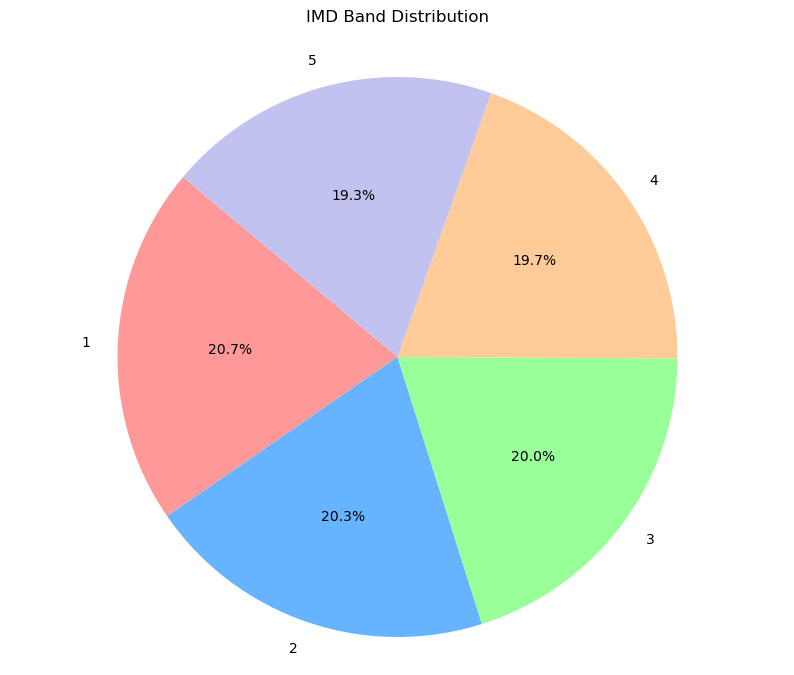

In [56]:
# Check the unique values and counts in the 'IMD_BAND_ENG' column
imd_band_counts = data['IMD_BAND_ENG'].value_counts()
# Pie charting
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']
labels_int = imd_band_counts.index.astype(int)

plt.figure(figsize=(10, 8))
plt.pie(imd_band_counts, labels=labels_int, colors=colors,autopct='%1.1f%%', startangle=140)
plt.title('IMD Band Distribution', pad=20)
plt.axis('equal')  
plt.show()

#### 2.1.7 Li Flag

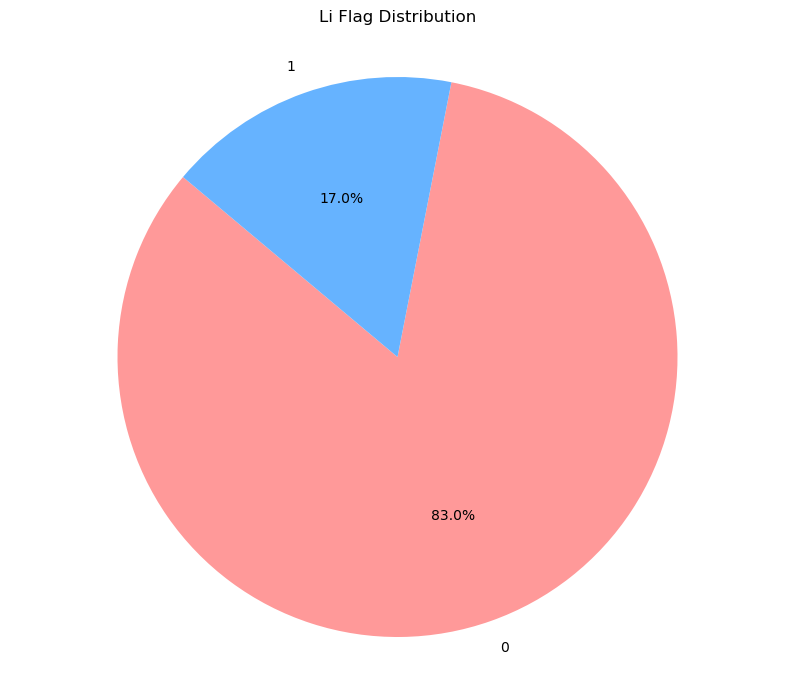

In [57]:
# Check the unique values and counts in the 'LI_FLAG' column
li_flag_counts = data['LI_FLAG'].value_counts()
# Pie charting
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels_int = li_flag_counts.index.astype(int)

plt.figure(figsize=(10, 8))
plt.pie(li_flag_counts, labels=labels_int, colors=colors,autopct='%1.1f%%', startangle=140)
plt.title('Li Flag Distribution', pad=20)
plt.axis('equal')  
plt.show()

#### 2.1.8 CWI Flag

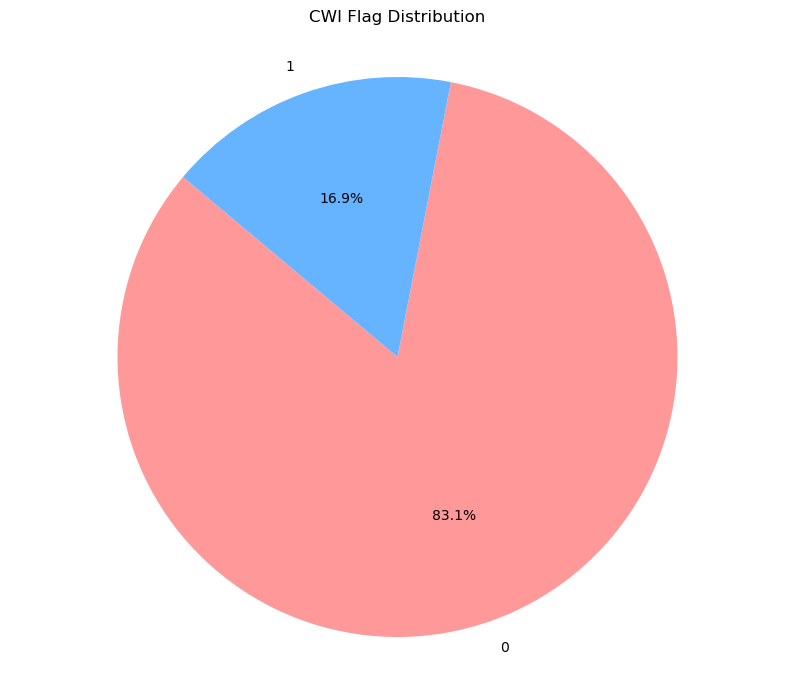

In [59]:
# Check the unique values and counts in the 'CWI_FLAG' column
cwi_flag_counts = data['CWI_FLAG'].value_counts()
# Pie charting
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels_int = cwi_flag_counts.index.astype(int)

plt.figure(figsize=(10, 8))
plt.pie(cwi_flag_counts, labels=labels_int, colors=colors,autopct='%1.1f%%', startangle=140)
plt.title('CWI Flag Distribution', pad=20)
plt.axis('equal')  
plt.show()

#### 2.1.9 PV Flag

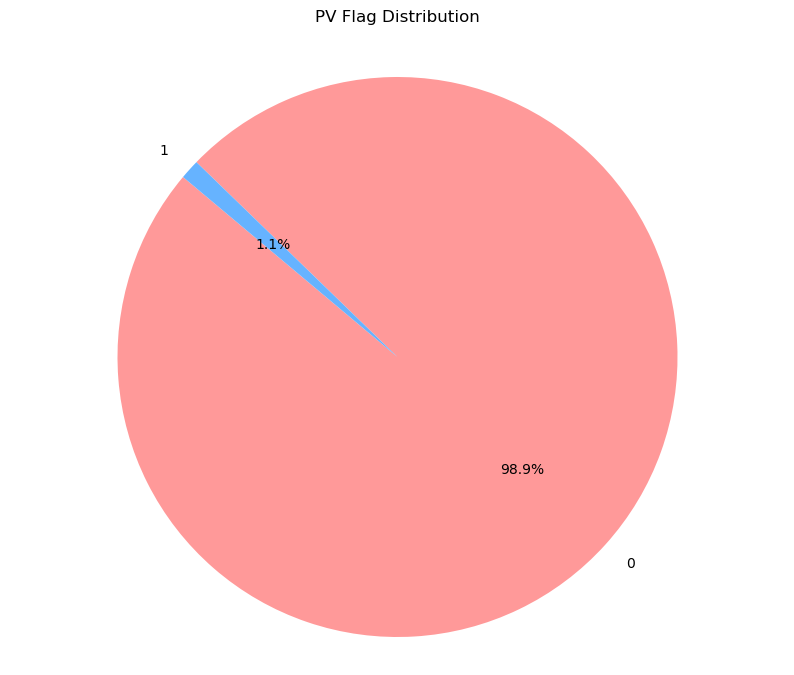

In [60]:
# Check the unique values and counts in the 'PV_FLAG' column
pv_flag_counts = data['PV_FLAG'].value_counts()
# Pie charting
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels_int = pv_flag_counts.index.astype(int)

plt.figure(figsize=(10, 8))
plt.pie(pv_flag_counts, labels=labels_int, colors=colors,autopct='%1.1f%%', startangle=140)
plt.title('PV Flag Distribution', pad=20)
plt.axis('equal')  
plt.show()

#### 2.1.10 Main Heat Fuel

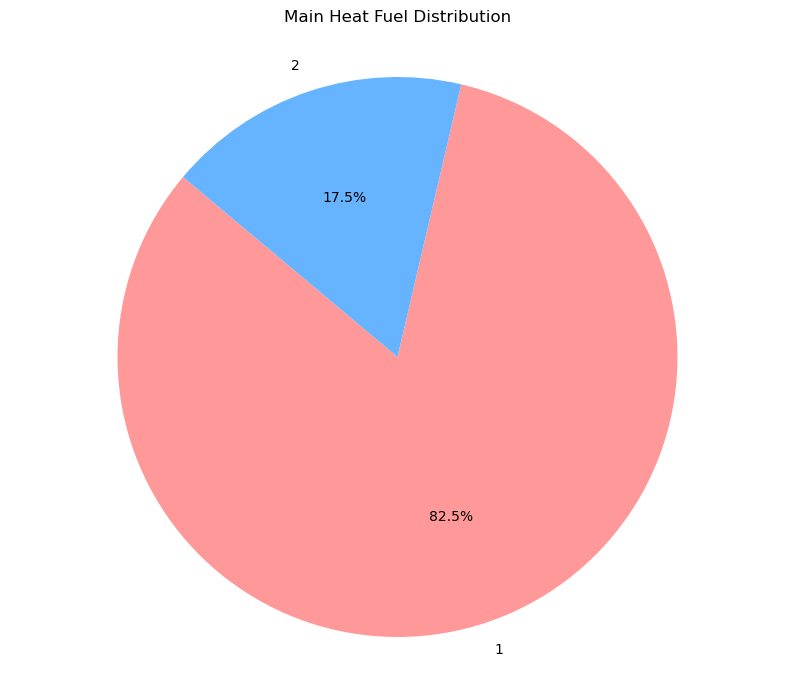

In [61]:
# Check the unique values and counts in the 'MAIN_HEAT_FUEL' column
main_heat_fuel_counts = data['MAIN_HEAT_FUEL'].value_counts()
# Pie charting
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
labels_int = main_heat_fuel_counts.index.astype(int)

plt.figure(figsize=(10, 8))
plt.pie(main_heat_fuel_counts, labels=labels_int, colors=colors,autopct='%1.1f%%', startangle=140)
plt.title('Main Heat Fuel Distribution', pad=20)
plt.axis('equal')  
plt.show()

# 3 Appropriate plots to communicate the distribution of key fields

### 3.1 Annual electricity consumption

#### 3.1.1 Property Type

##### Bungalow

In [82]:
# Filter rows where PROP_TYPE_Bungalow is 1
bungalow_data = data[data['PROP_TYPE_Bungalow'] == 1]

In [83]:
all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (bungalow_data[econs_columns].min().min(), bungalow_data[econs_columns].max().max())
y_ticks = [0, 500]

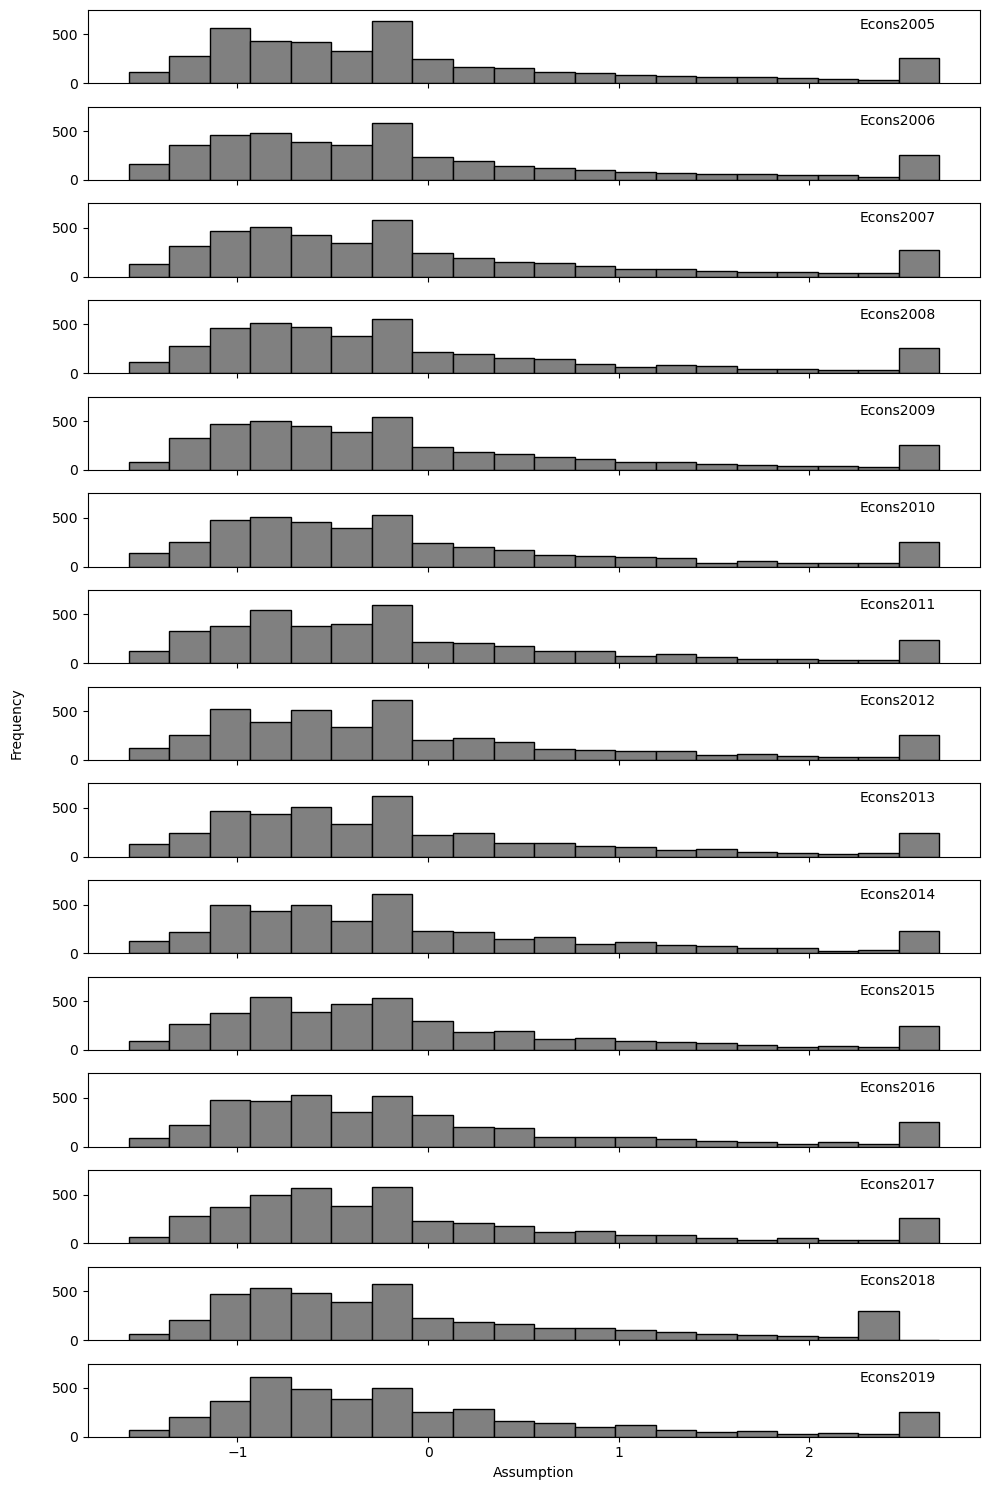

In [84]:
# Adjust the figure size to match the aspect ratio of the provided example
# Based on the example image, the aspect ratio seems to be wider and not as tall
fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(bungalow_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 750)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Detached

In [175]:
detached_data = data[data['PROP_TYPE_Detached'] == 1]

In [176]:
all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (detached_data[econs_columns].min().min(), detached_data[econs_columns].max().max())
y_ticks = [0, 1000]

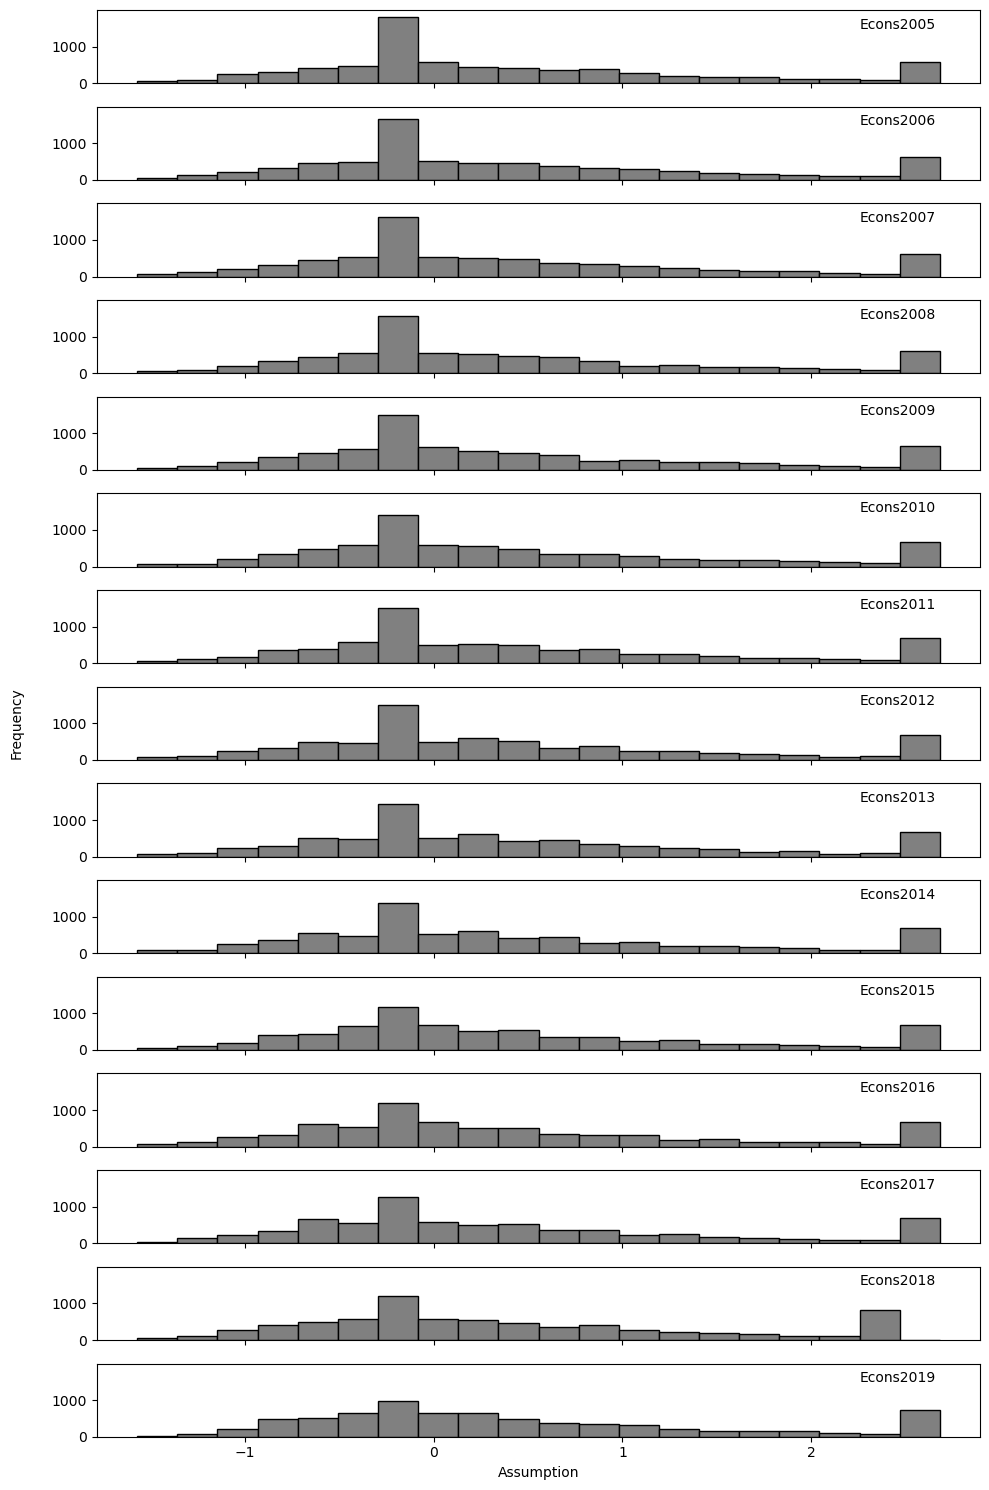

In [177]:
# Adjust the figure size to match the aspect ratio of the provided example
# Based on the example image, the aspect ratio seems to be wider and not as tall
fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(detached_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 2000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### End terrace

In [97]:
end_terrace_data = data[data['PROP_TYPE_End terrace'] == 1]

In [120]:
all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (end_terrace_data[econs_columns].min().min(), end_terrace_data[econs_columns].max().max())
y_ticks = [0, 1000]

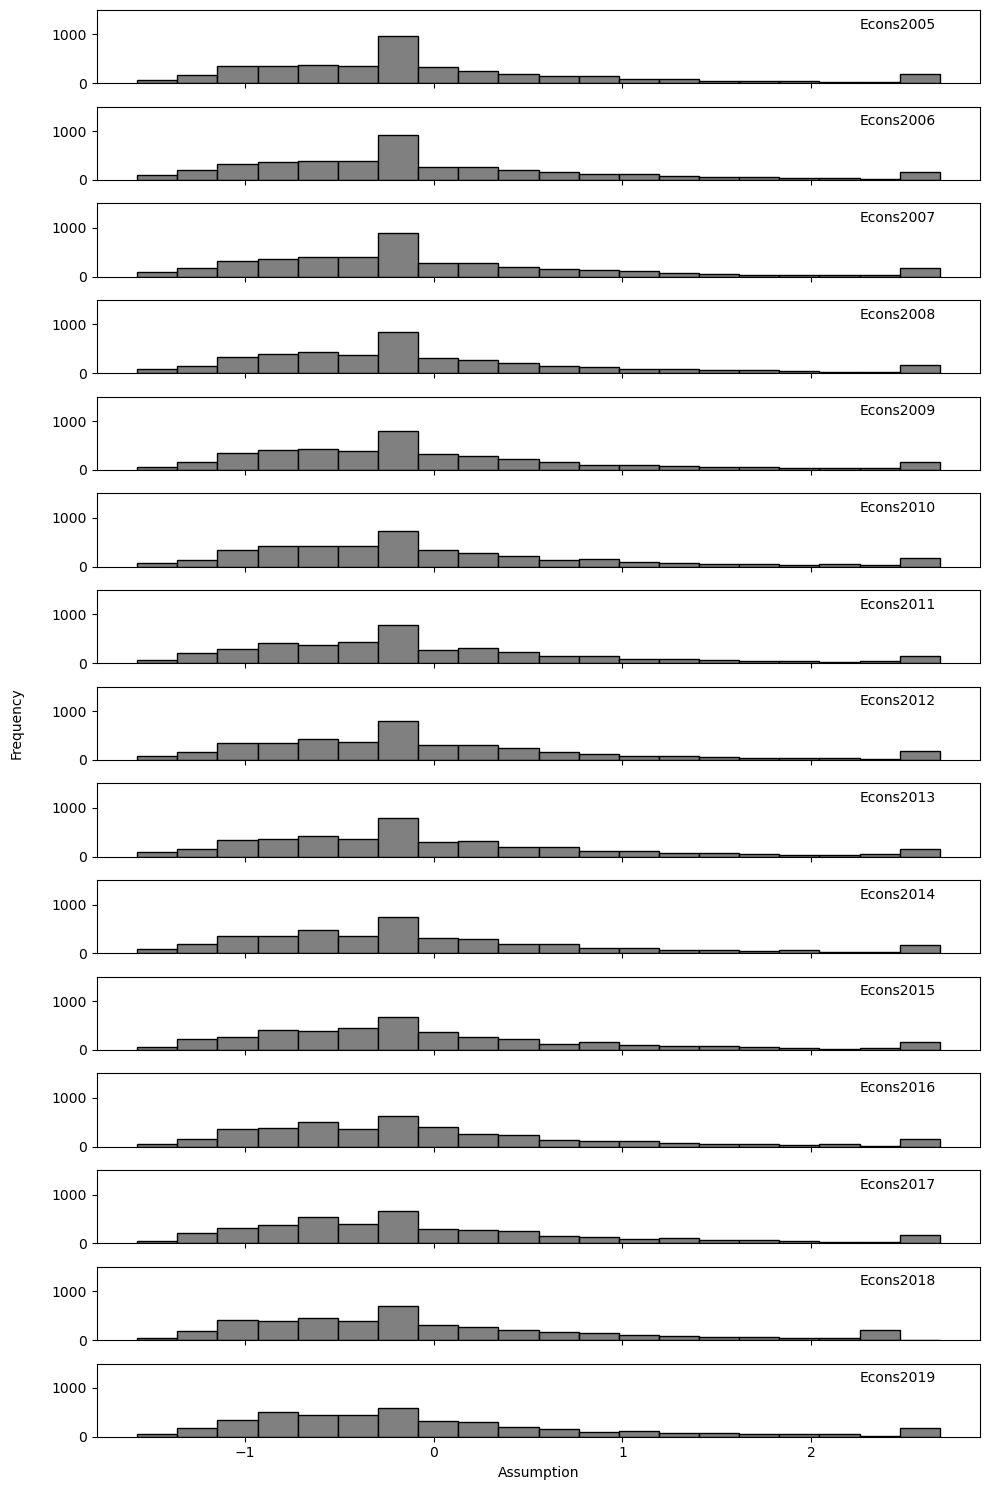

In [121]:
# Adjust the figure size to match the aspect ratio of the provided example
# Based on the example image, the aspect ratio seems to be wider and not as tall
fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(end_terrace_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 1500)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Flat

In [106]:
flat_data = data[data['PROP_TYPE_Flat'] == 1]

In [122]:
all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (flat_data[econs_columns].min().min(), flat_data[econs_columns].max().max())
y_ticks = [0, 2000, 4000]

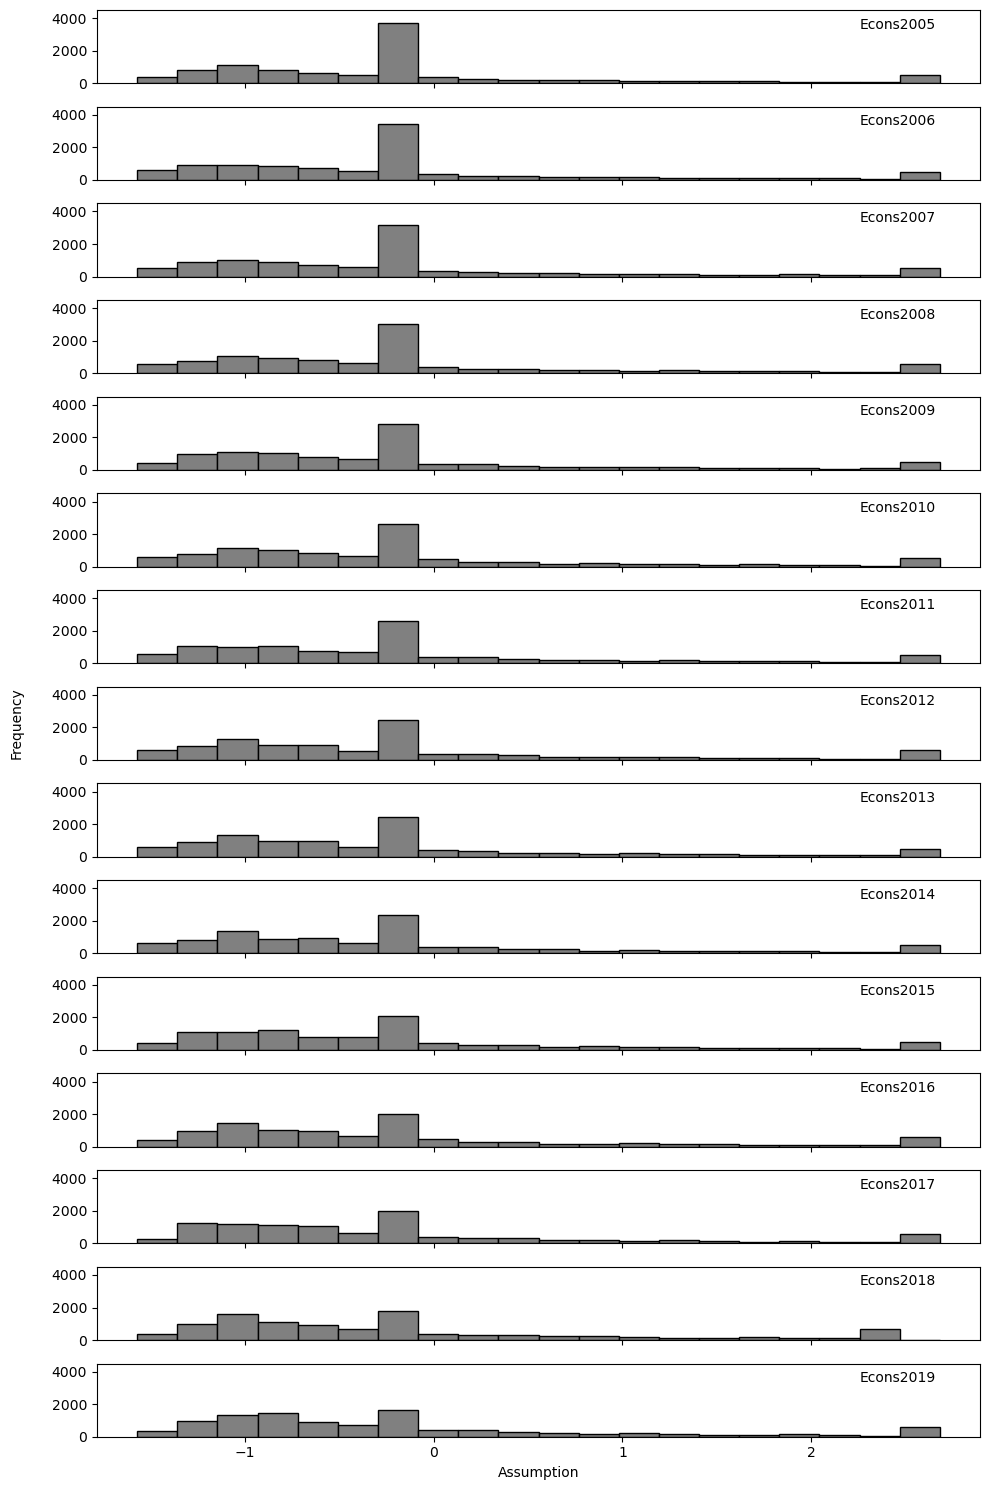

In [123]:
# Adjust the figure size to match the aspect ratio of the provided example
# Based on the example image, the aspect ratio seems to be wider and not as tall
fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(flat_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 4500)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Mid terrace

In [119]:
mid_terrace_data = data[data['PROP_TYPE_Mid terrace'] == 1]

In [126]:
all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (mid_terrace_data[econs_columns].min().min(), mid_terrace_data[econs_columns].max().max())
y_ticks = [0, 1000]

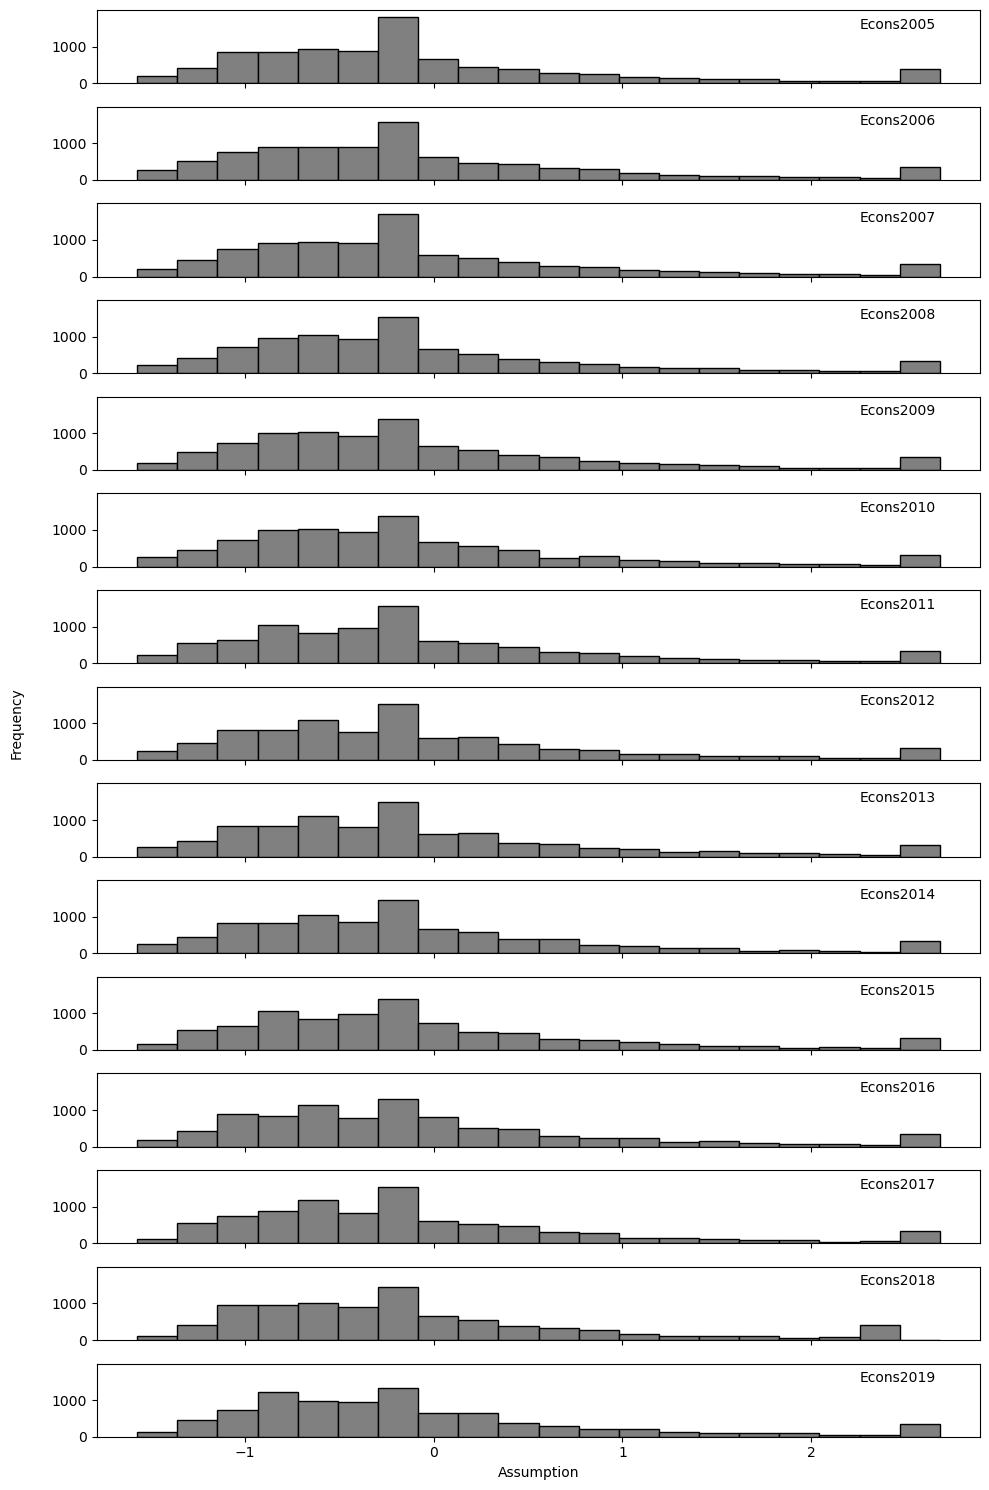

In [127]:
# Adjust the figure size to match the aspect ratio of the provided example
# Based on the example image, the aspect ratio seems to be wider and not as tall
fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(mid_terrace_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 2000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Semi detached

In [128]:
semi_detached_data = data[data['PROP_TYPE_Semi detached'] == 1]

In [132]:
all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (semi_detached_data[econs_columns].min().min(), semi_detached_data[econs_columns].max().max())
y_ticks = [0, 1500]

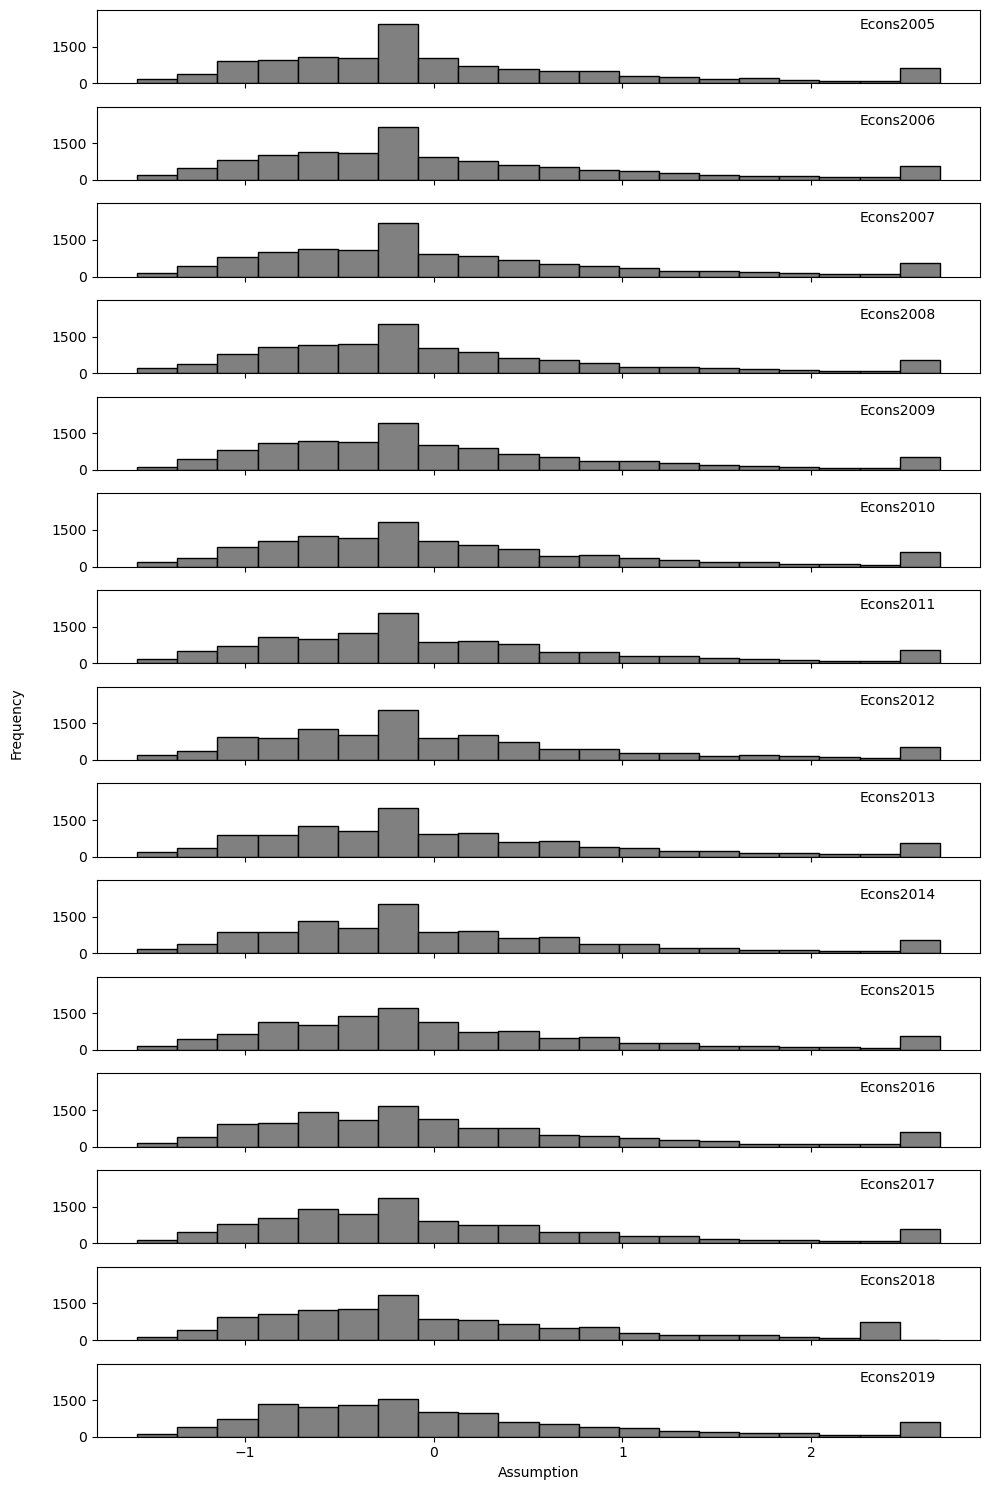

In [133]:
# Adjust the figure size to match the aspect ratio of the provided example
# Based on the example image, the aspect ratio seems to be wider and not as tall
fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(semi_detached_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 3000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

#### 3.1.2 Council Tax Band

##### Band A

In [134]:
band_a_data = data[data['COUNCIL_TAX_BAND_A'] == 1]

In [135]:
all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (band_a_data[econs_columns].min().min(), band_a_data[econs_columns].max().max())
y_ticks = [0, 1500]

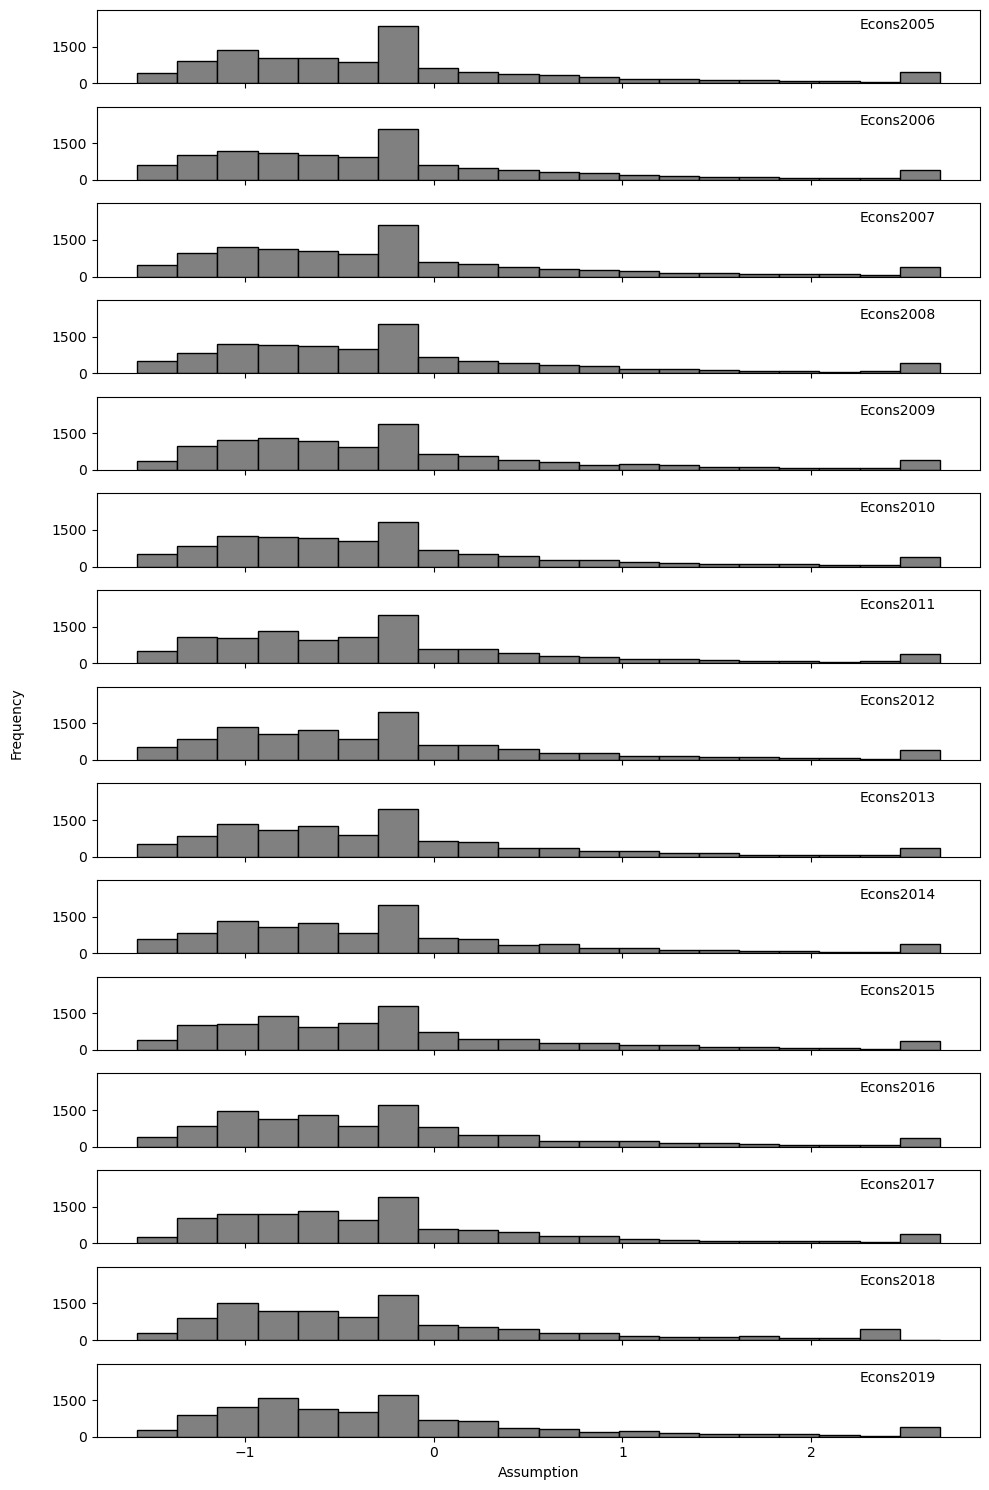

In [136]:
# Adjust the figure size to match the aspect ratio of the provided example
# Based on the example image, the aspect ratio seems to be wider and not as tall
fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(band_a_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 3000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Band B

In [137]:
band_b_data = data[data['COUNCIL_TAX_BAND_B'] == 1]

In [138]:
all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (band_b_data[econs_columns].min().min(), band_b_data[econs_columns].max().max())
y_ticks = [0, 1500]

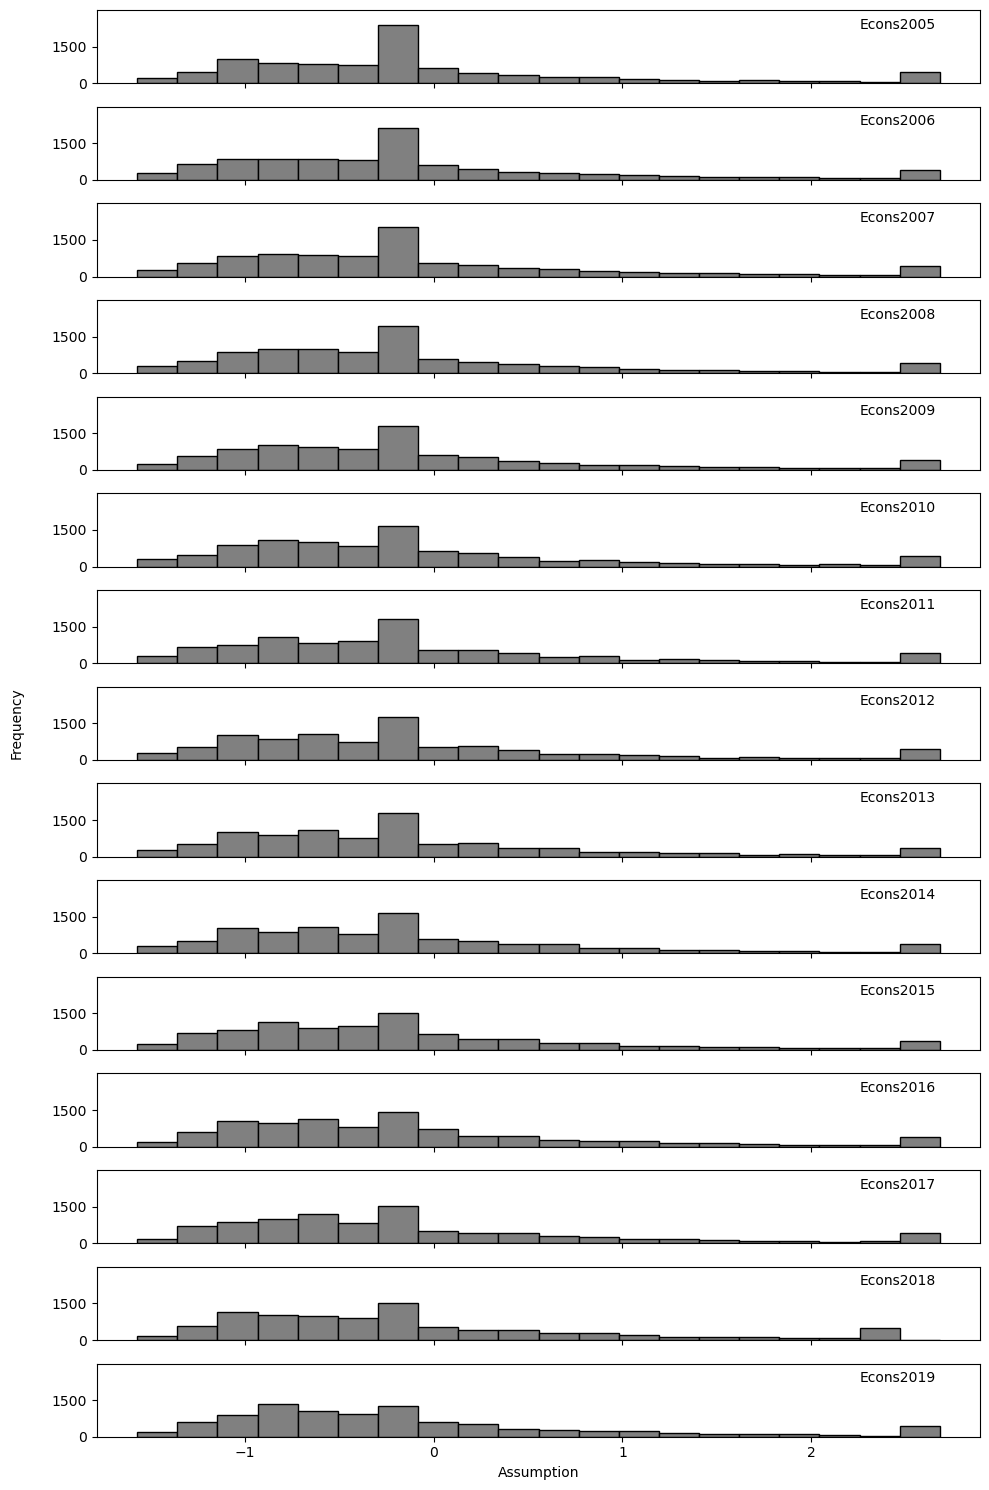

In [139]:
# Adjust the figure size to match the aspect ratio of the provided example
# Based on the example image, the aspect ratio seems to be wider and not as tall
fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(band_b_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 3000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Band C

In [140]:
band_c_data = data[data['COUNCIL_TAX_BAND_C'] == 1]

In [141]:
all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (band_c_data[econs_columns].min().min(), band_c_data[econs_columns].max().max())
y_ticks = [0, 1500]

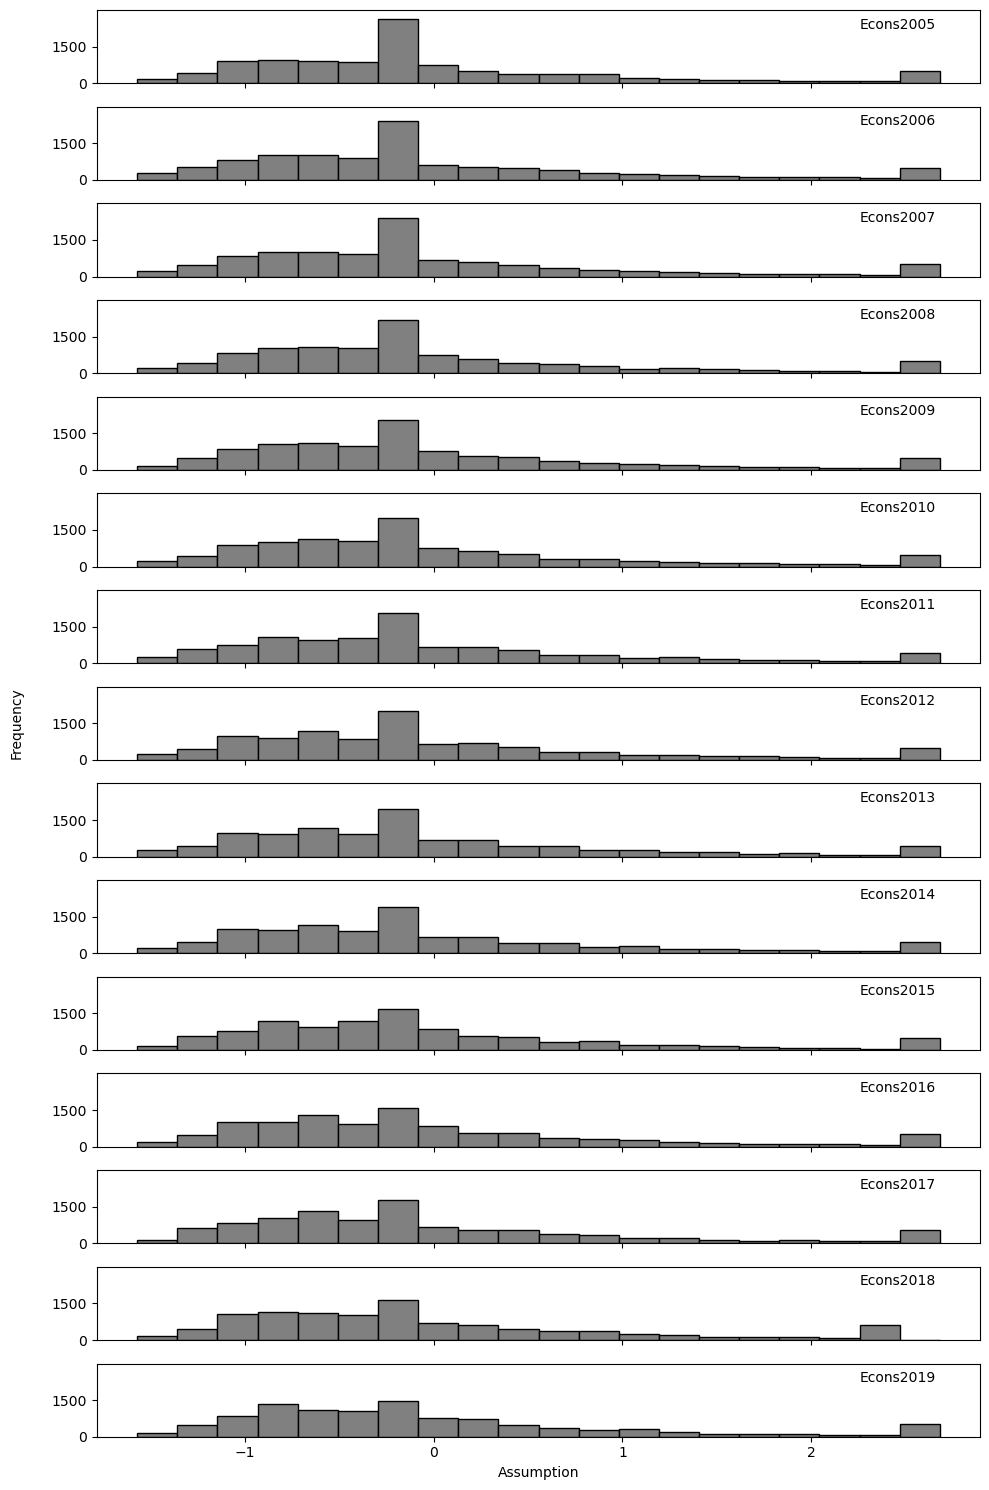

In [142]:
# Adjust the figure size to match the aspect ratio of the provided example
# Based on the example image, the aspect ratio seems to be wider and not as tall
fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(band_c_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 3000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Band D

In [144]:
band_d_data = data[data['COUNCIL_TAX_BAND_D'] == 1]

In [147]:
all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (band_d_data[econs_columns].min().min(), band_d_data[econs_columns].max().max())
y_ticks = [0, 1000]

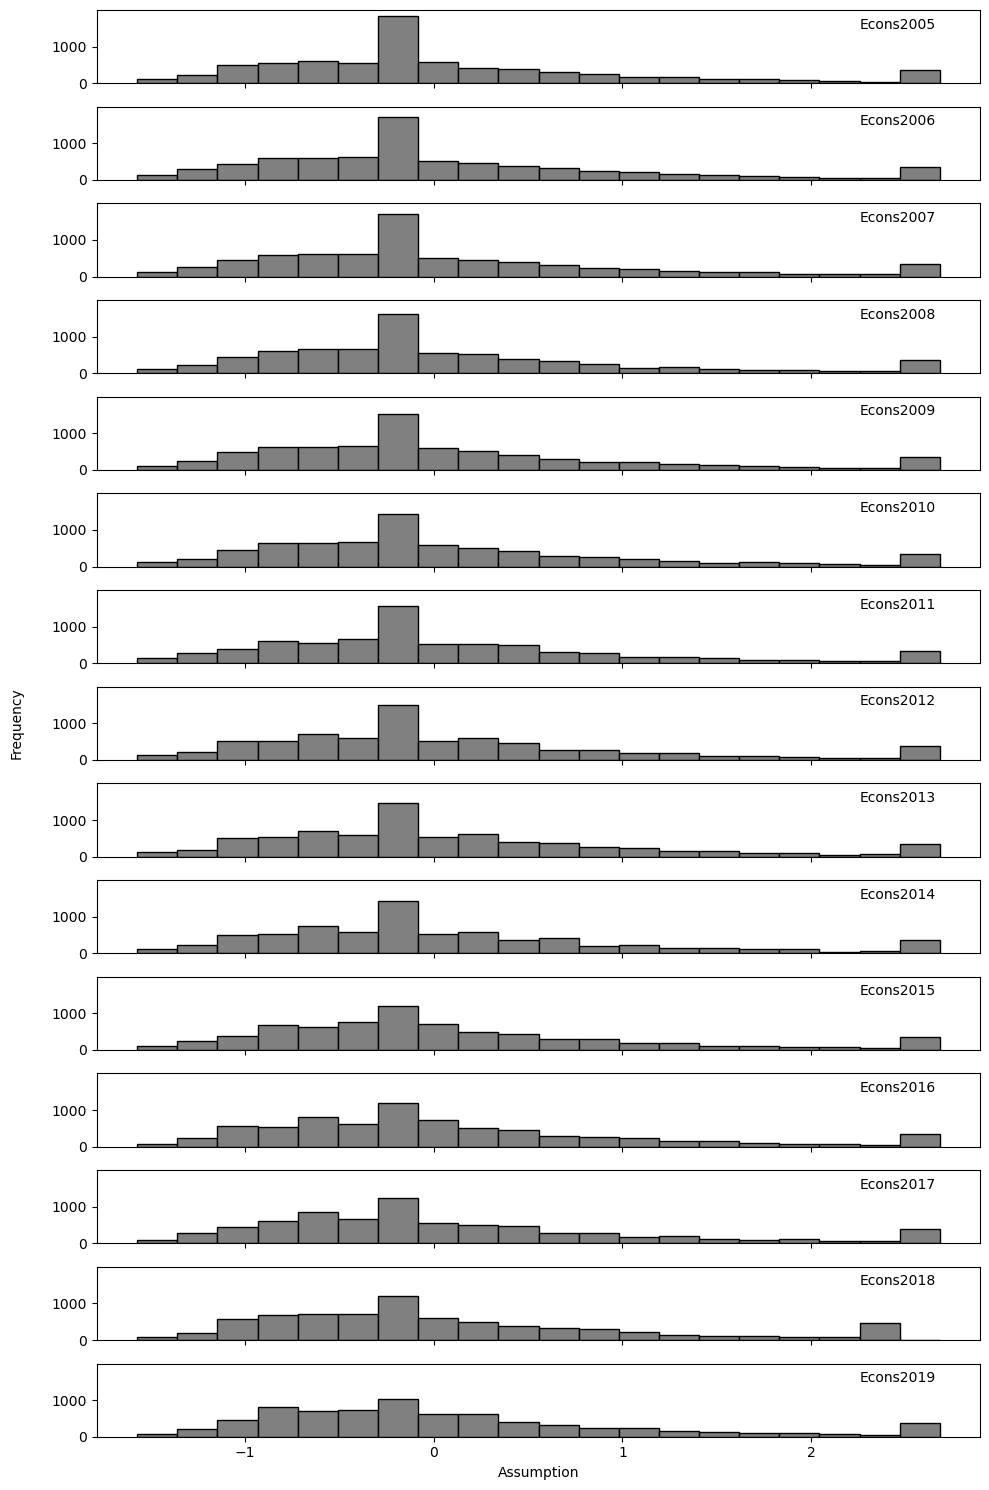

In [148]:
# Adjust the figure size to match the aspect ratio of the provided example
# Based on the example image, the aspect ratio seems to be wider and not as tall
fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(band_d_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 2000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Band E

In [149]:
band_e_data = data[data['COUNCIL_TAX_BAND_E'] == 1]

In [155]:
all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (band_e_data[econs_columns].min().min(), band_e_data[econs_columns].max().max())
y_ticks = [0, 1000]

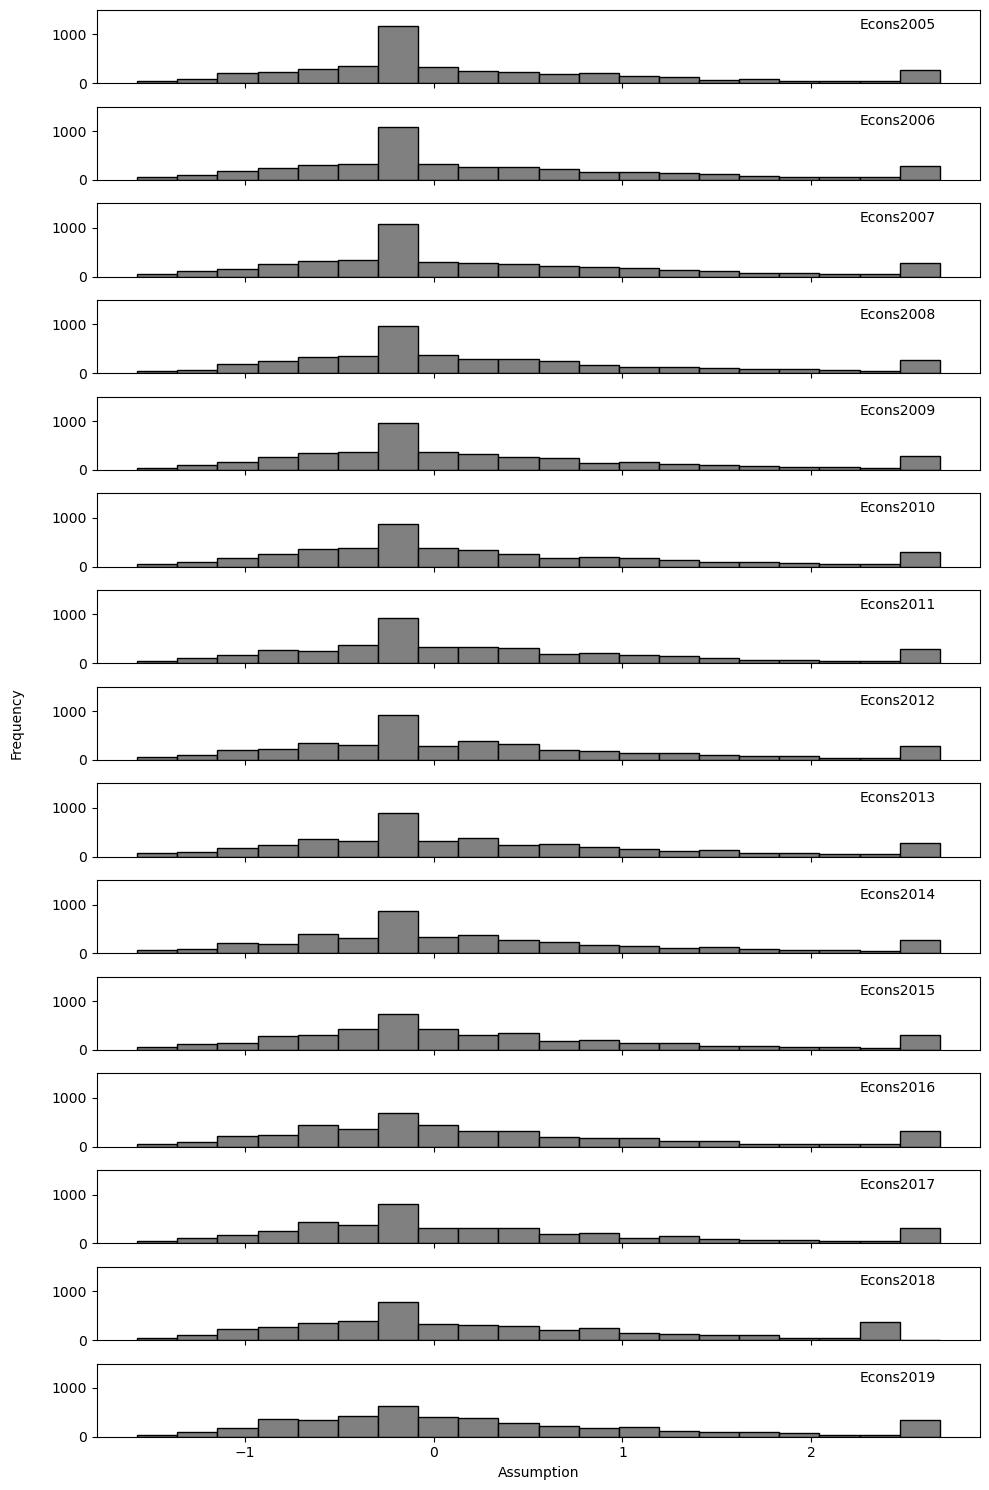

In [156]:
# Adjust the figure size to match the aspect ratio of the provided example
# Based on the example image, the aspect ratio seems to be wider and not as tall
fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(band_e_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 1500)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Band F

In [157]:
band_f_data = data[data['COUNCIL_TAX_BAND_F'] == 1]

In [161]:
all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (band_f_data[econs_columns].min().min(), band_f_data[econs_columns].max().max())
y_ticks = [0, 500]

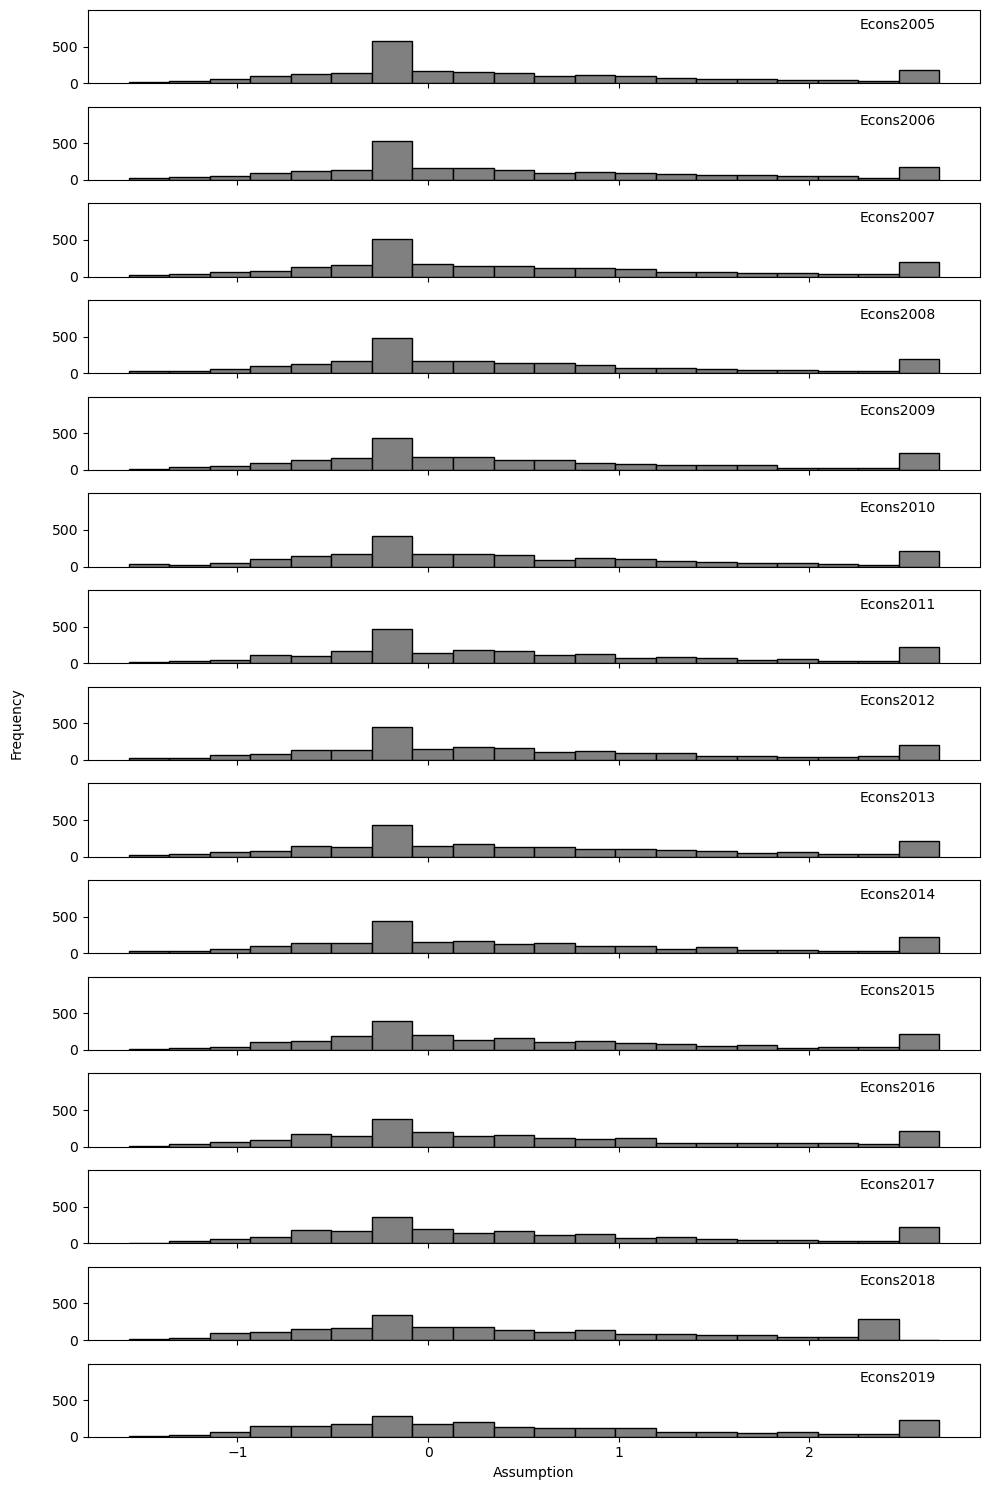

In [162]:
# Adjust the figure size to match the aspect ratio of the provided example
# Based on the example image, the aspect ratio seems to be wider and not as tall
fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(band_f_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 1000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Band G

In [163]:
band_g_data = data[data['COUNCIL_TAX_BAND_G'] == 1]

In [166]:
all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (band_g_data[econs_columns].min().min(), band_g_data[econs_columns].max().max())
y_ticks = [0, 250]

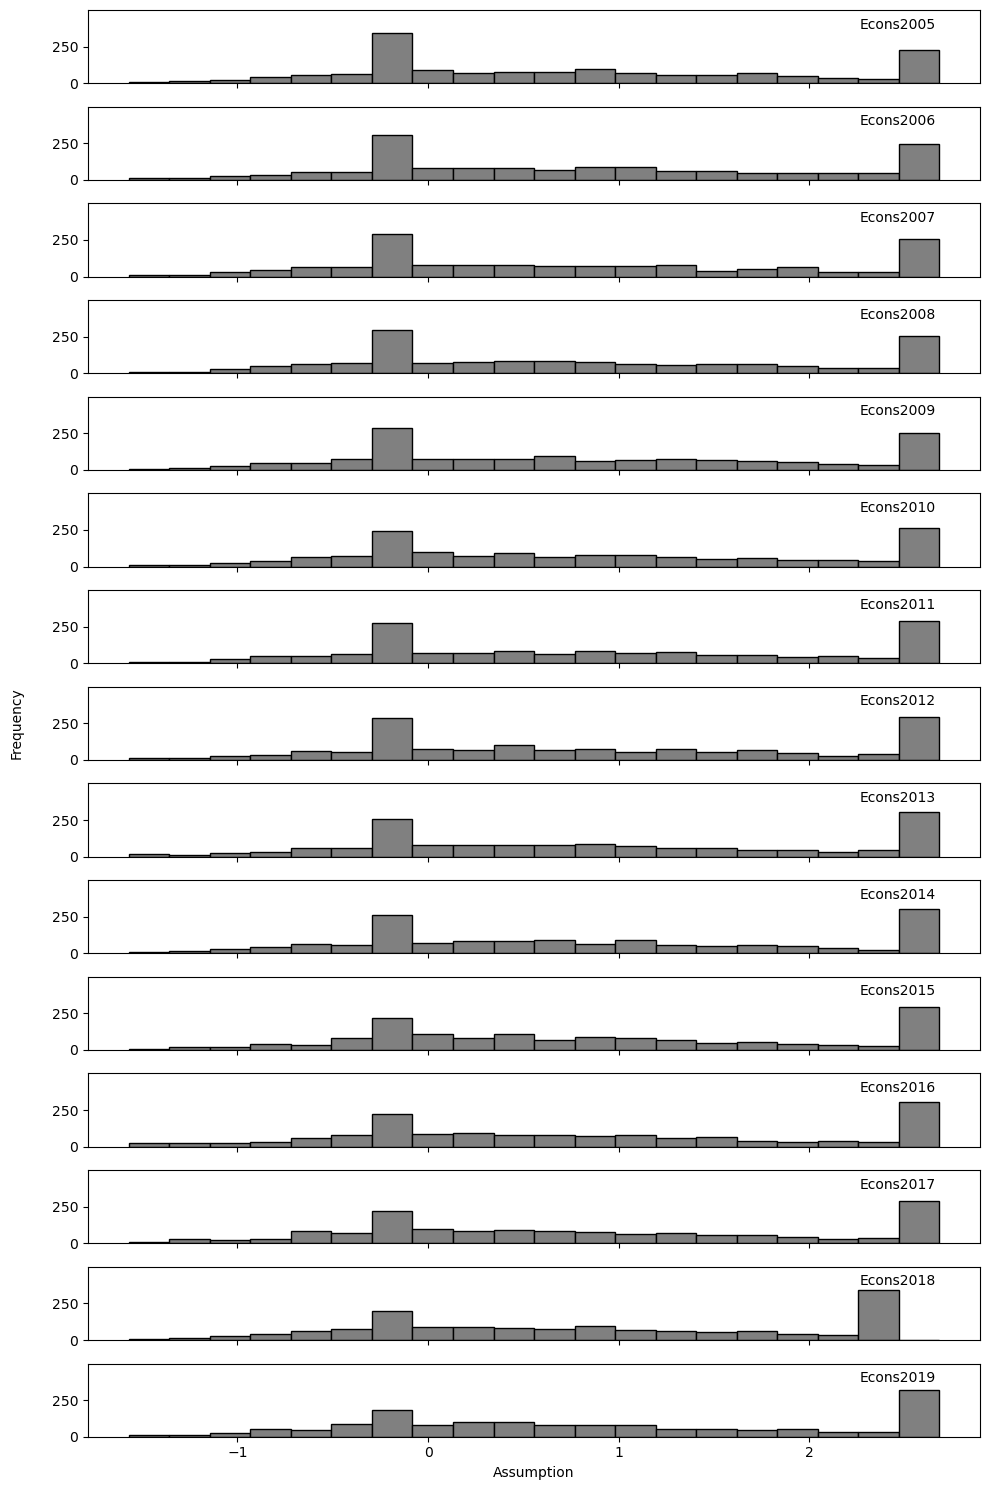

In [167]:
# Adjust the figure size to match the aspect ratio of the provided example
# Based on the example image, the aspect ratio seems to be wider and not as tall
fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(band_g_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 500)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Band H

In [168]:
band_h_data = data[data['COUNCIL_TAX_BAND_H'] == 1]

In [173]:
all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (band_h_data[econs_columns].min().min(), band_h_data[econs_columns].max().max())
y_ticks = [0, 100]

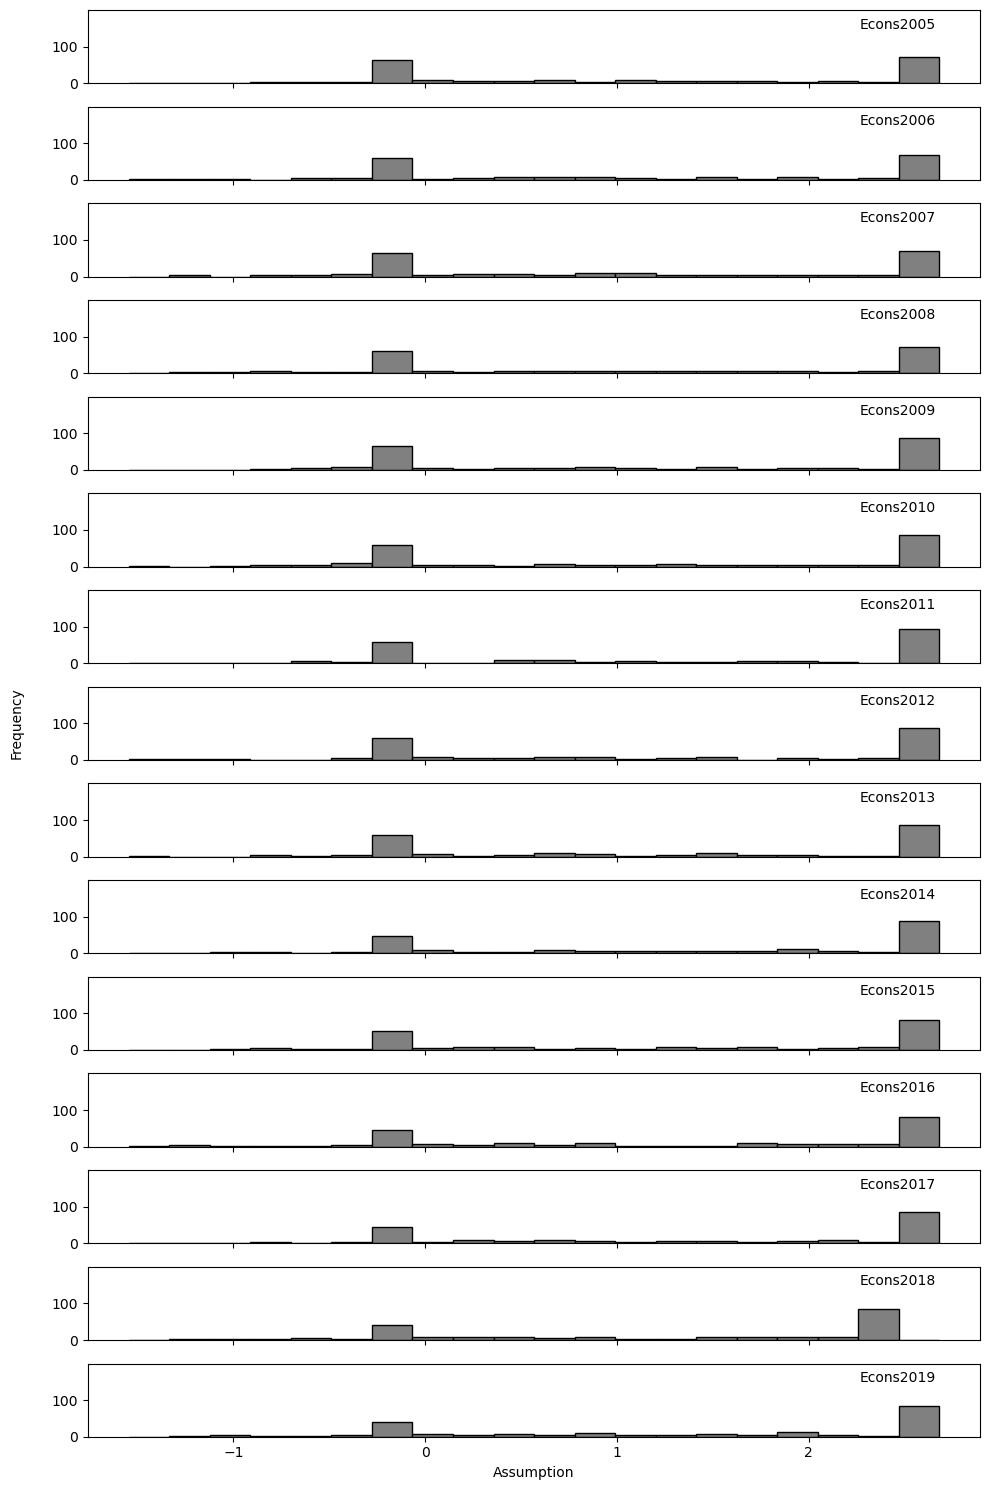

In [174]:
# Adjust the figure size to match the aspect ratio of the provided example
# Based on the example image, the aspect ratio seems to be wider and not as tall
fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(band_h_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 200)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

#### 3.1.3 Region Band

##### REGION_E12000001

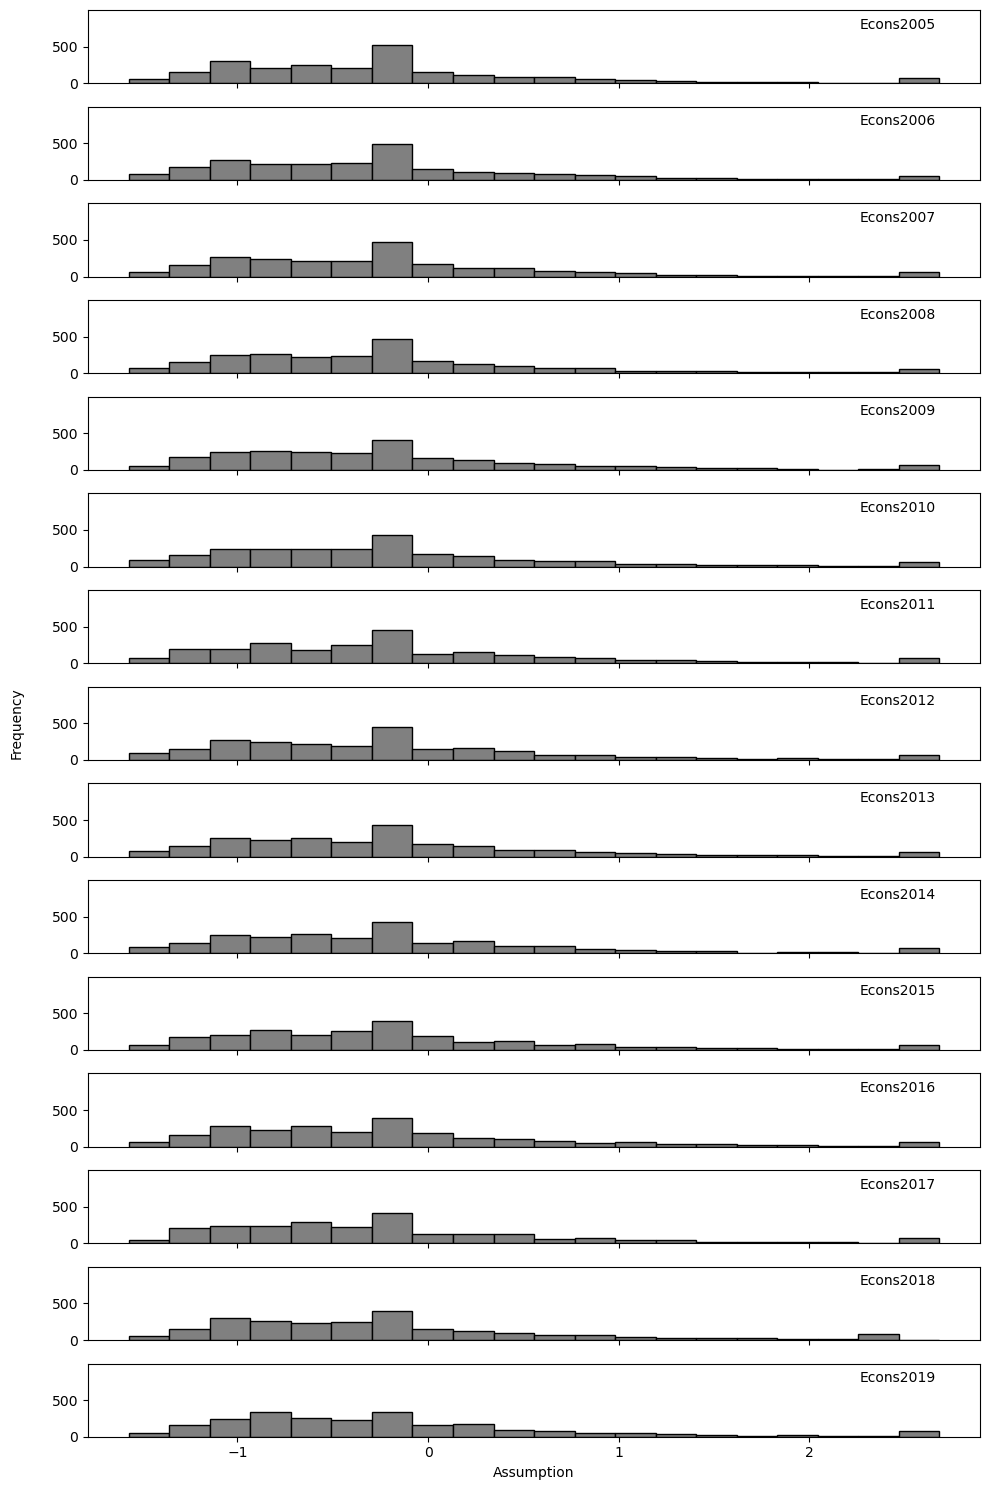

In [183]:
r1_data = data[data['REGION_E12000001'] == 1]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r1_data[econs_columns].min().min(), r1_data[econs_columns].max().max())
y_ticks = [0, 500]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r1_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 1000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### REGION_E12000002

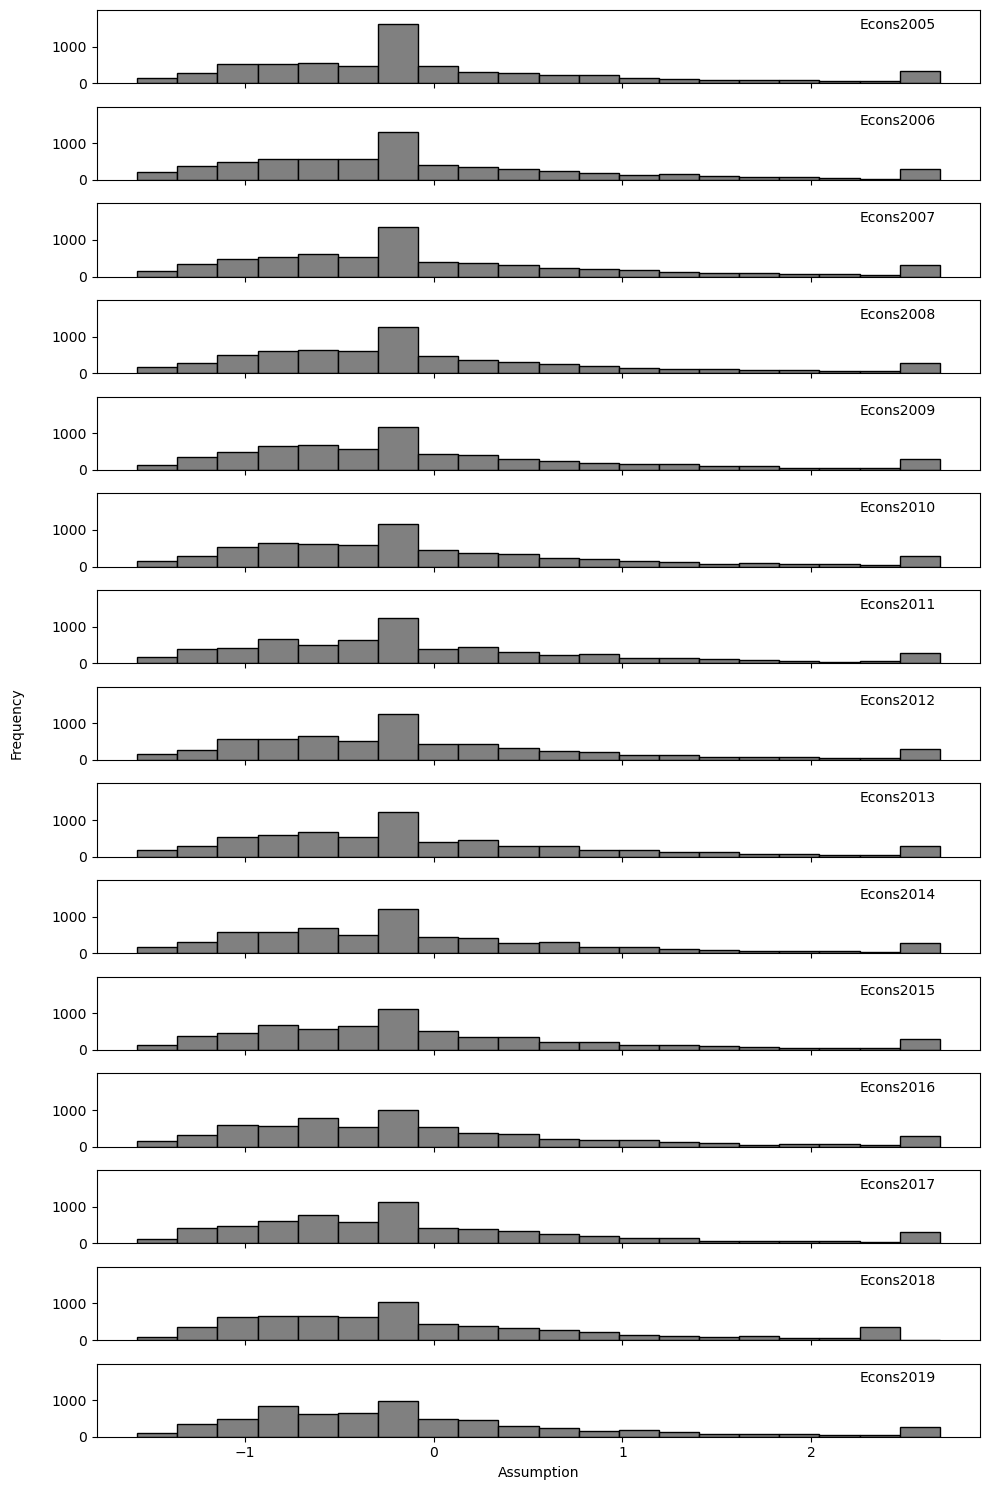

In [186]:
r_data = data[data['REGION_E12000002'] == 1]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 1000]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 2000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### REGION_E12000003

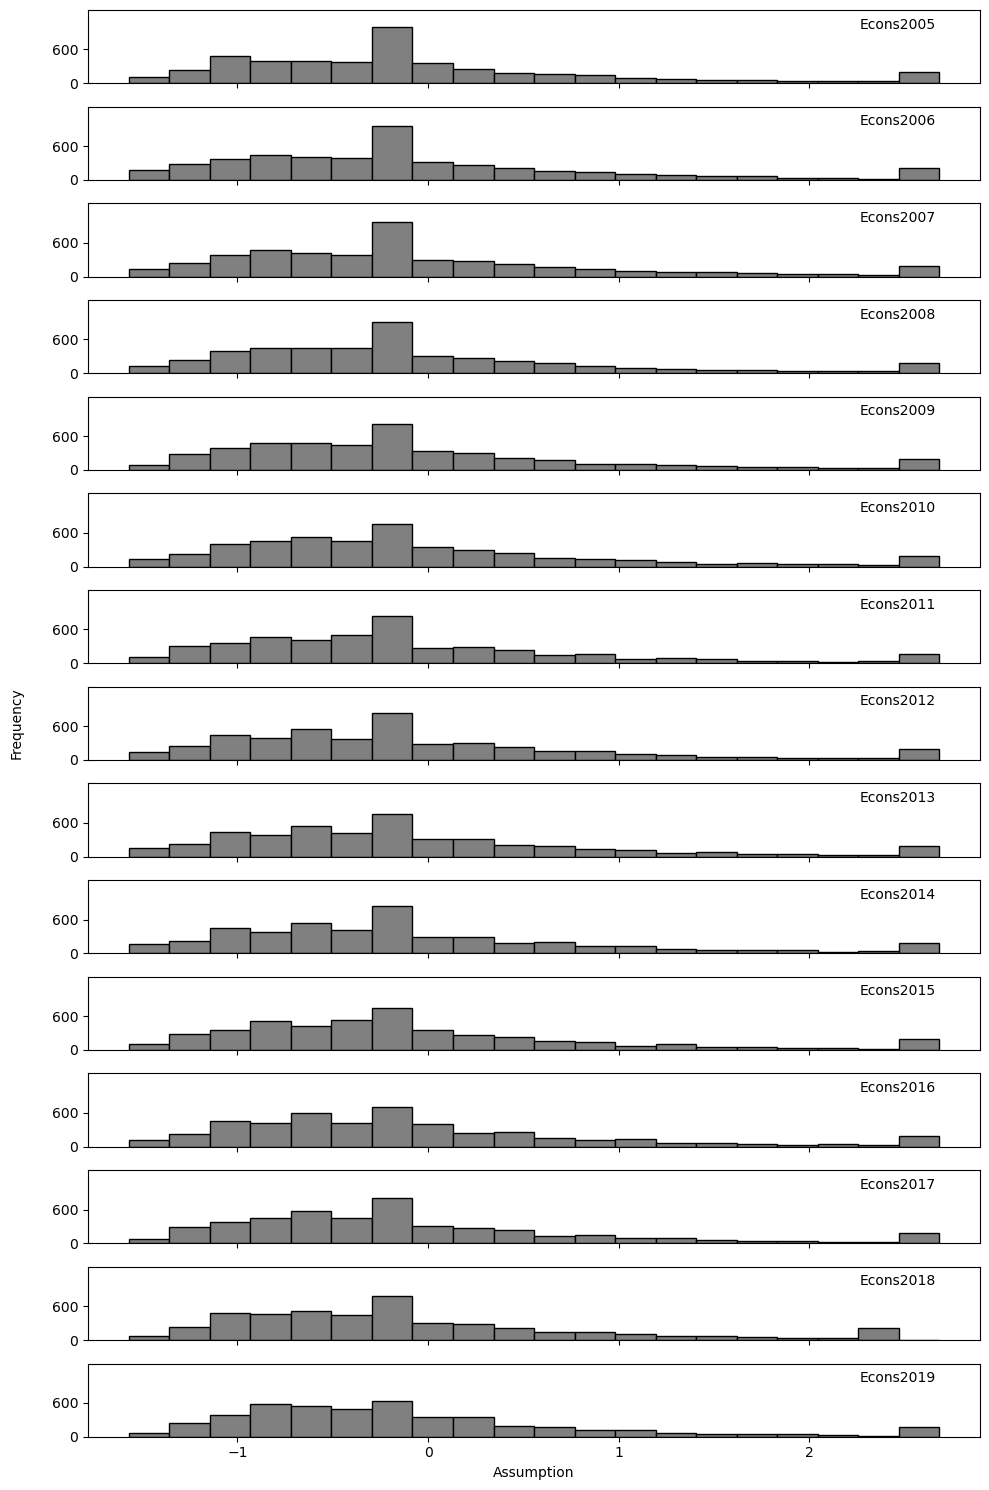

In [190]:
r_data = data[data['REGION_E12000003'] == 1]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 600]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 1300)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### REGION_E12000004

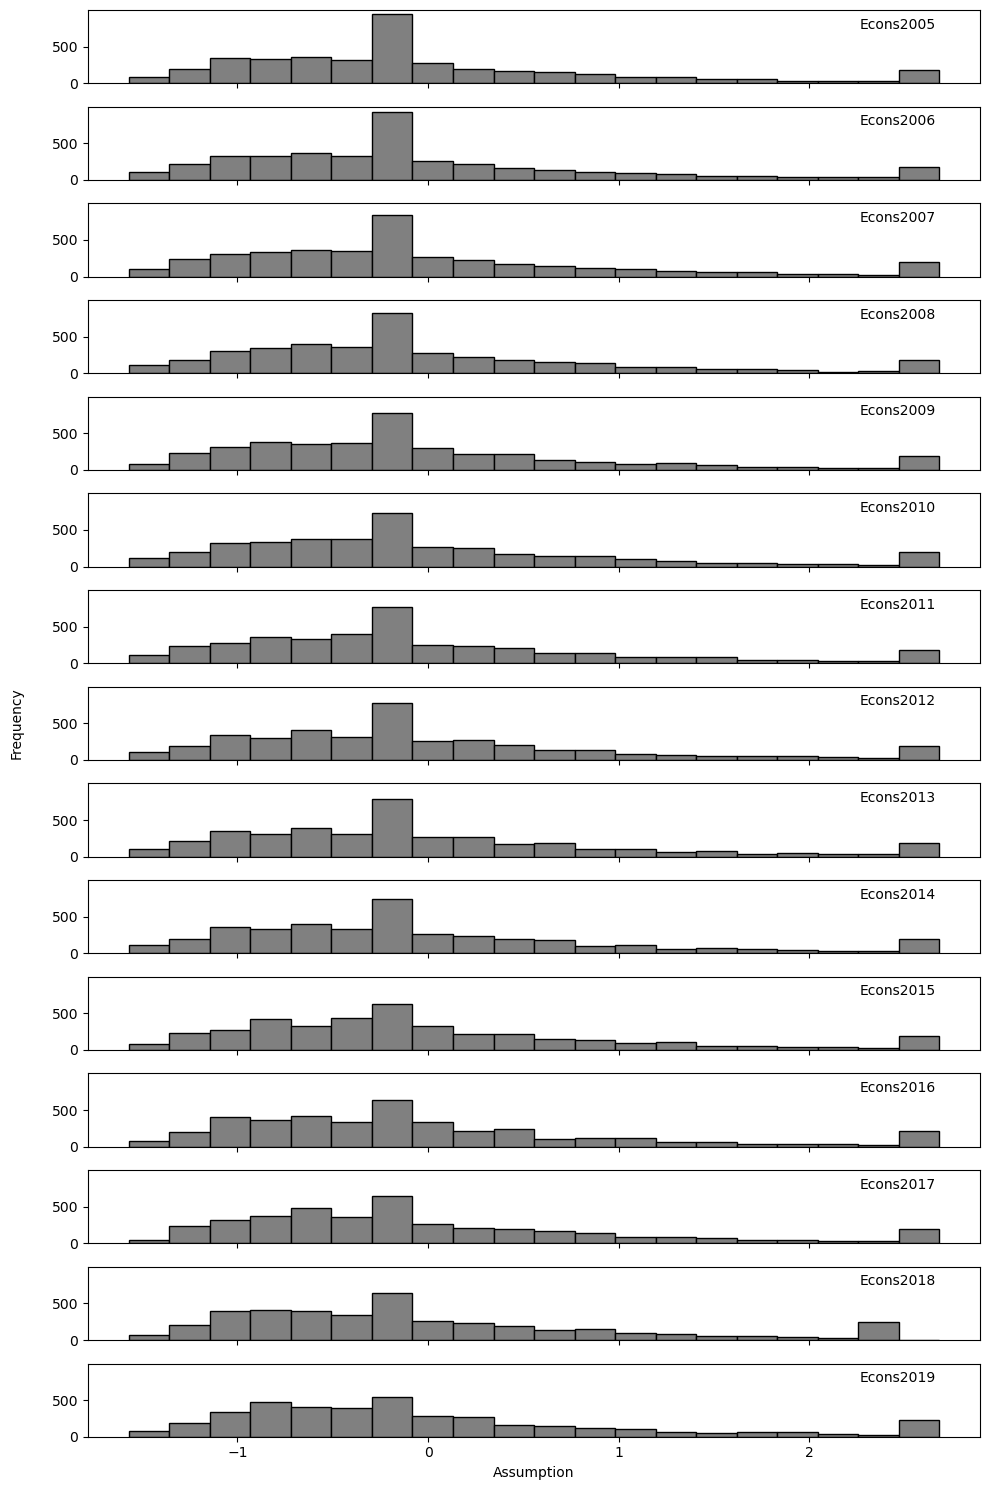

In [192]:
r_data = data[data['REGION_E12000004'] == 1]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 500]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 1000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### REGION_E12000005

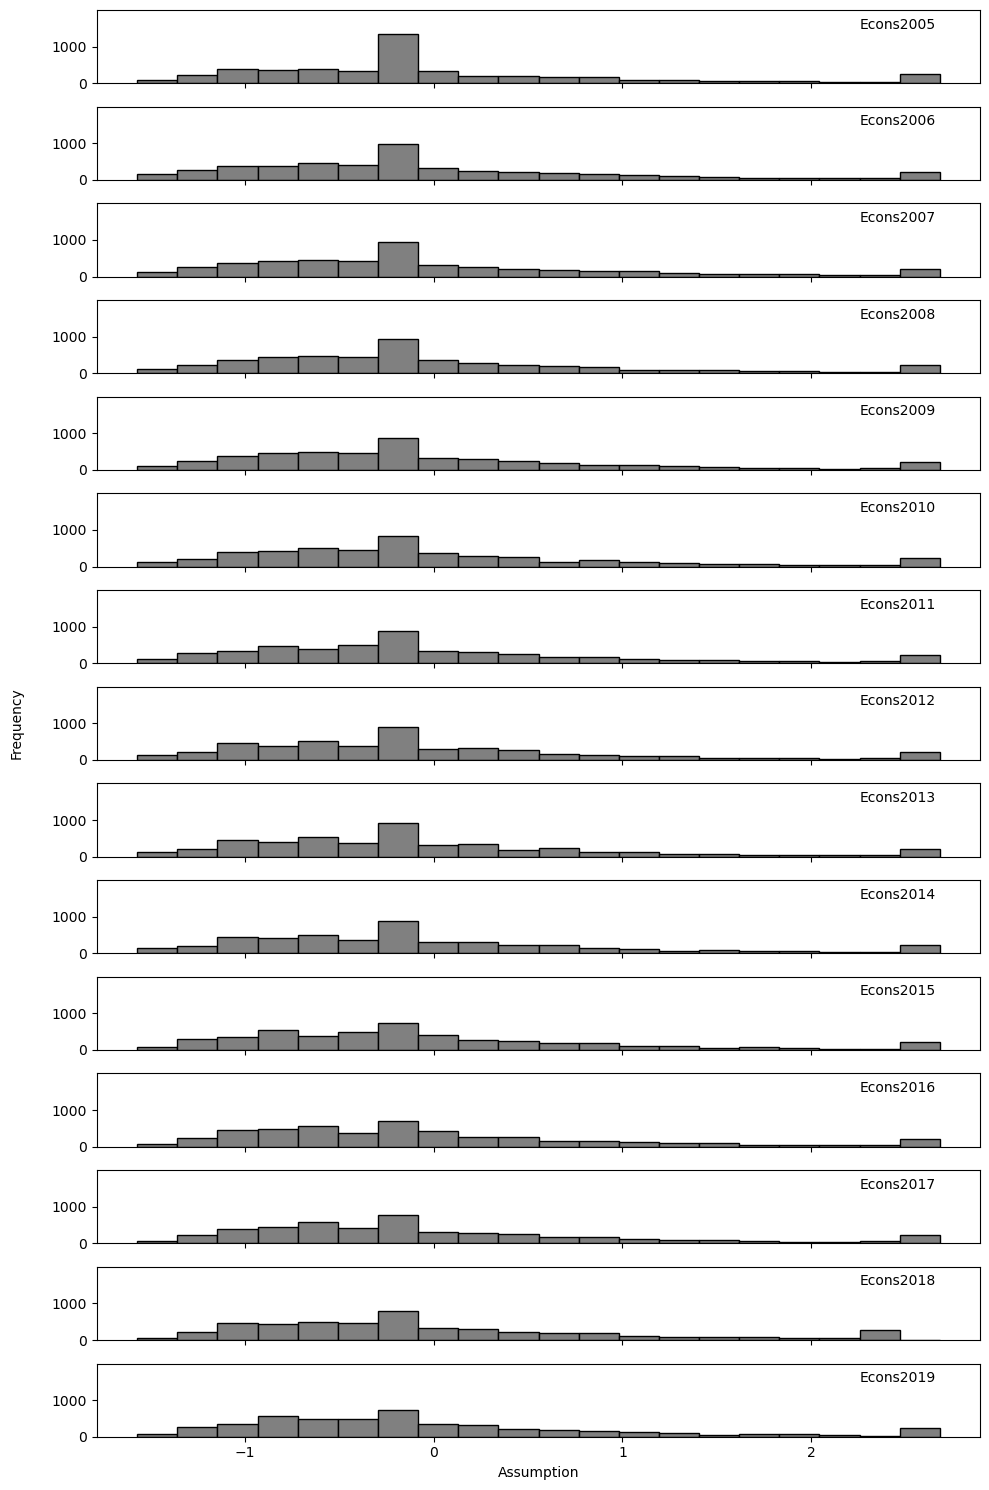

In [193]:
r_data = data[data['REGION_E12000005'] == 1]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 1000]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 2000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### REGION_E12000006

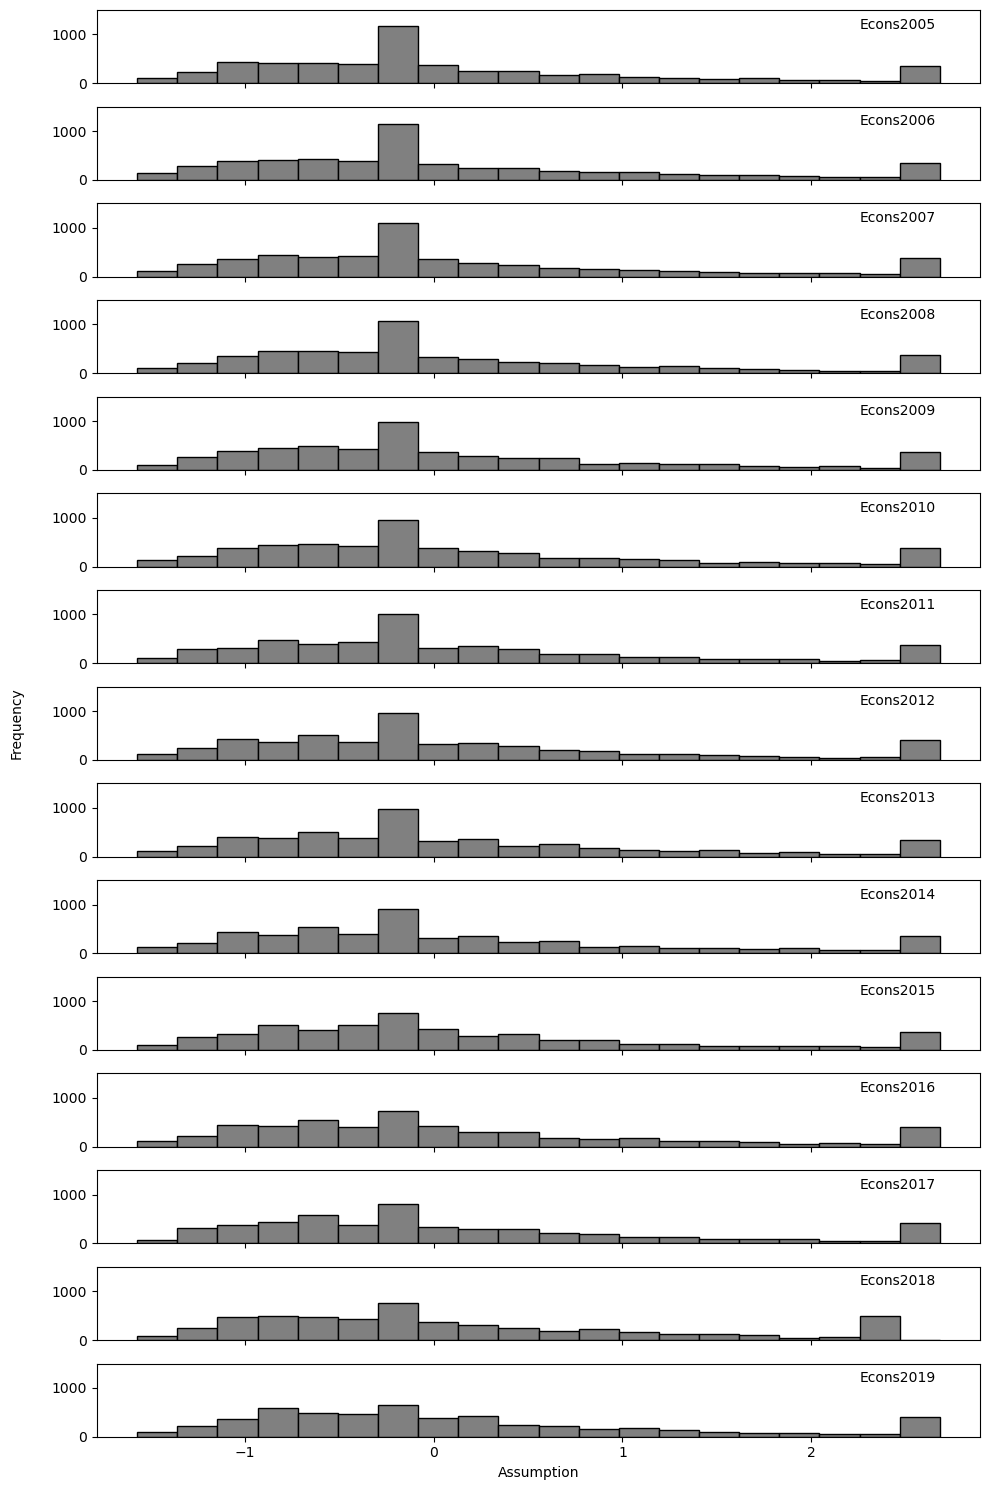

In [195]:
r_data = data[data['REGION_E12000006'] == 1]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 1000]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 1500)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### REGION_E12000007

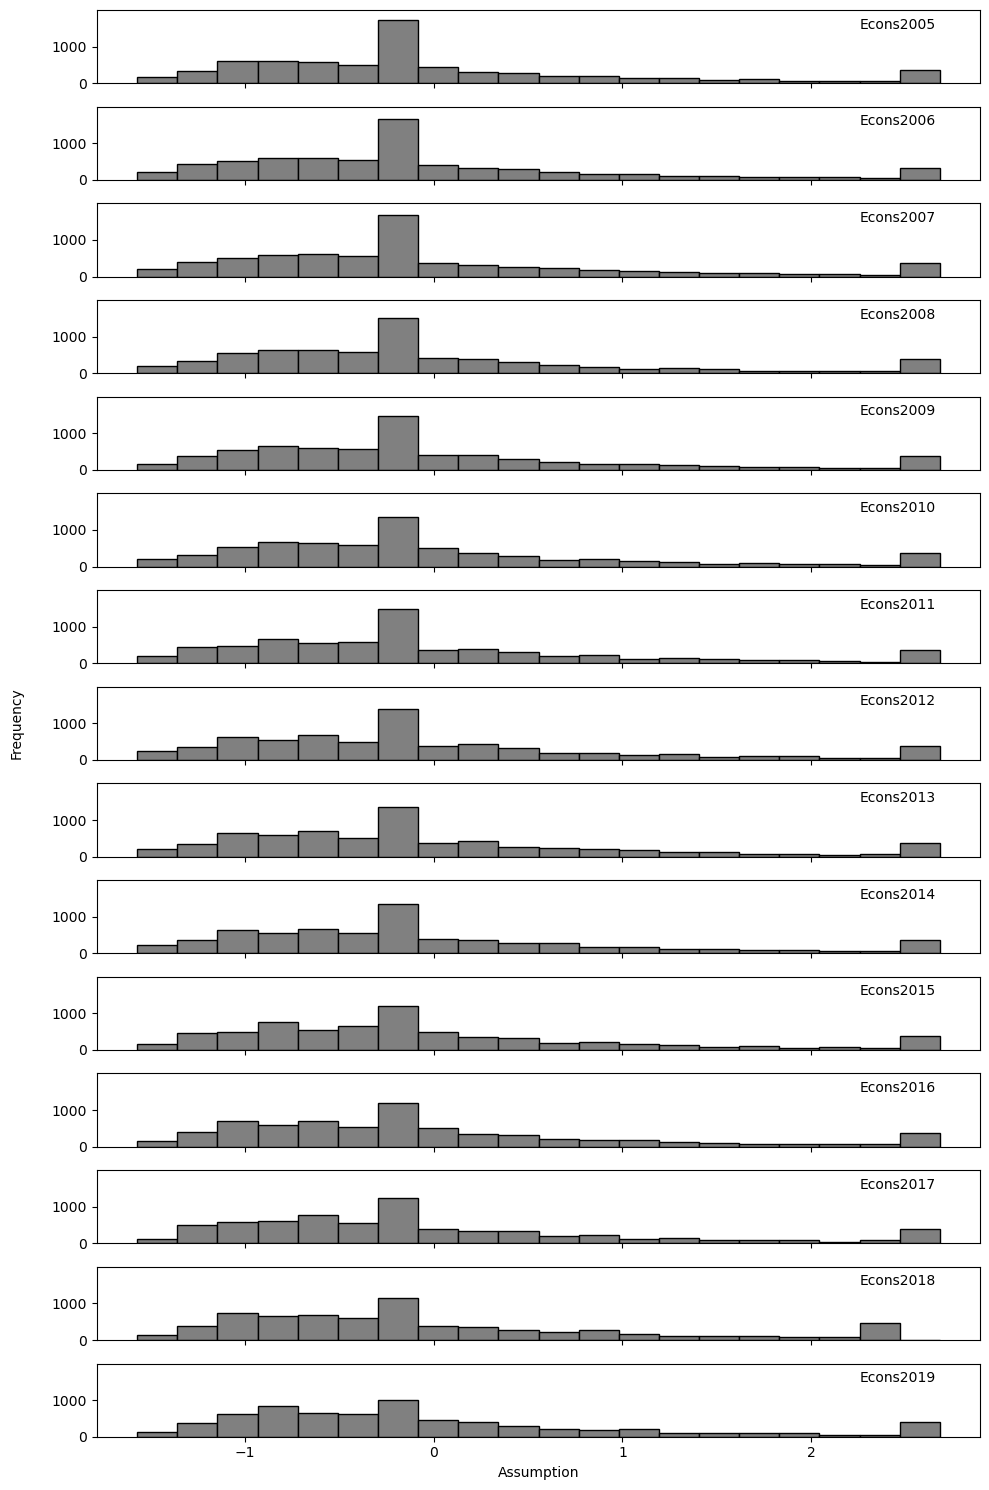

In [196]:
r_data = data[data['REGION_E12000007'] == 1]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 1000]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 2000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### REGION_E12000008

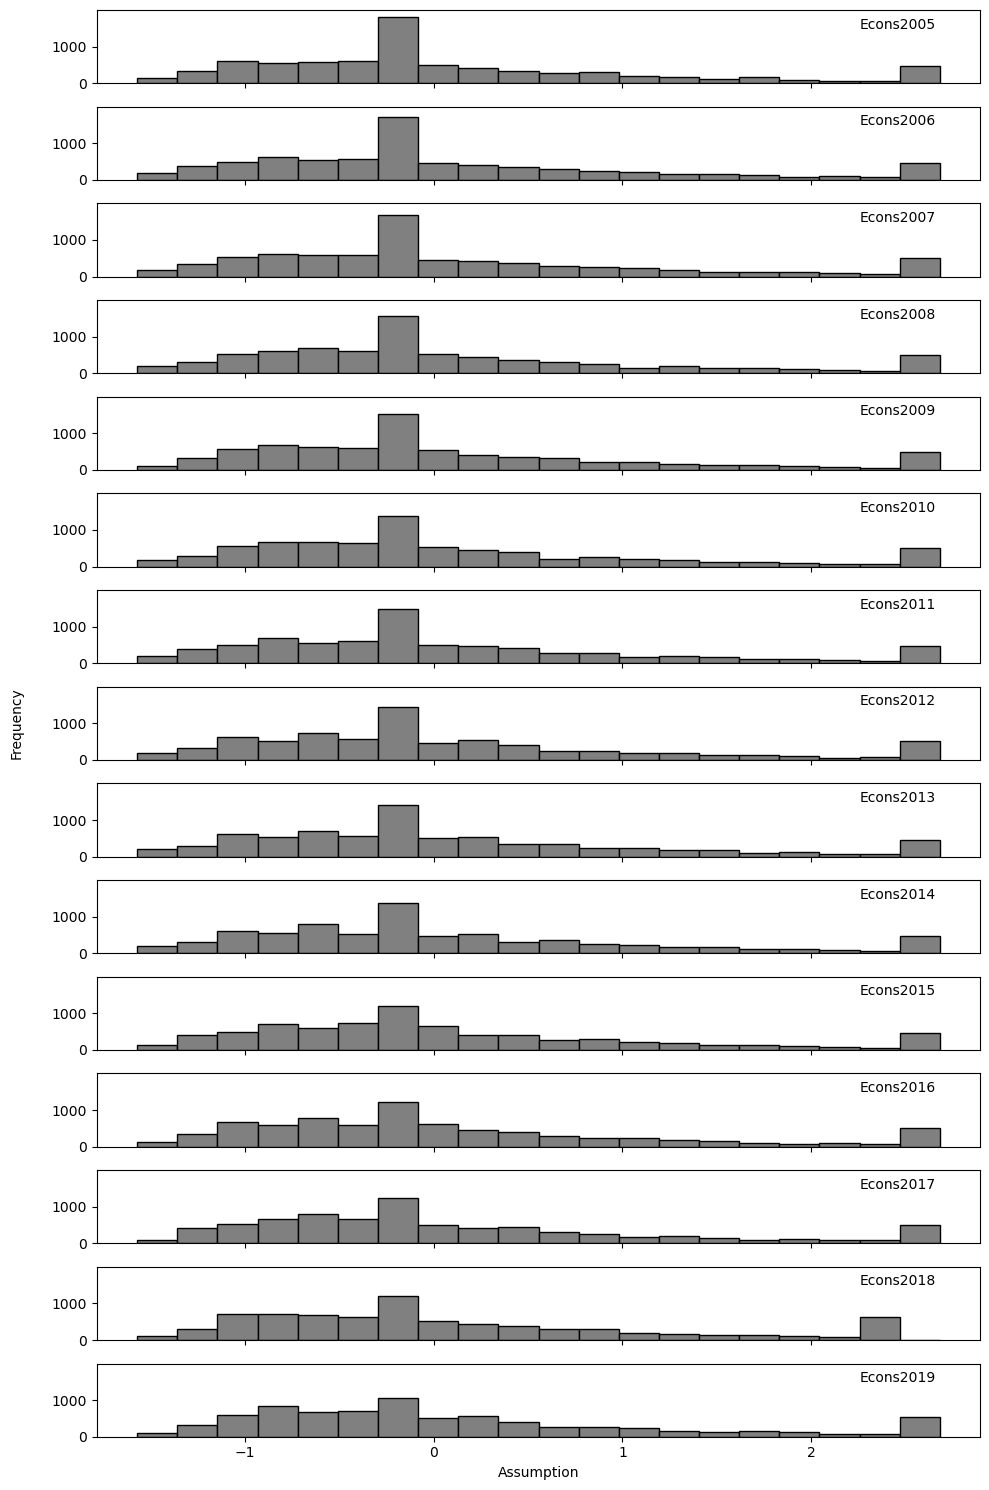

In [197]:
r_data = data[data['REGION_E12000008'] == 1]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 1000]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 2000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### REGION_E12000009

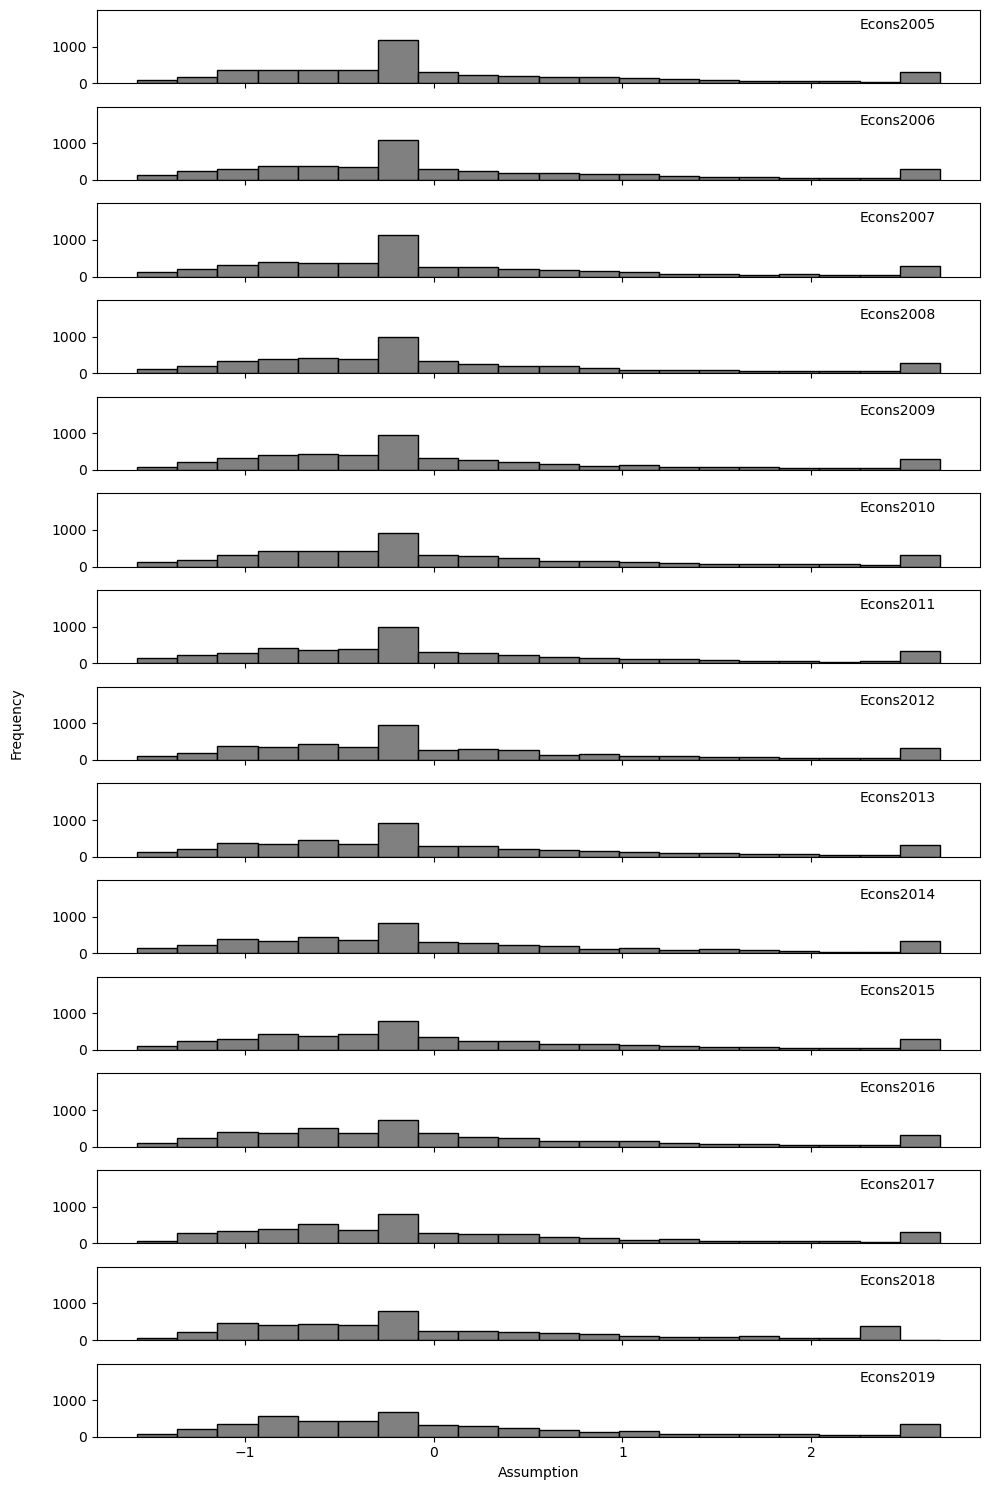

In [198]:
r_data = data[data['REGION_E12000009'] == 1]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 1000]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 2000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

#### 3.1.4 Property Age

##### Band 1

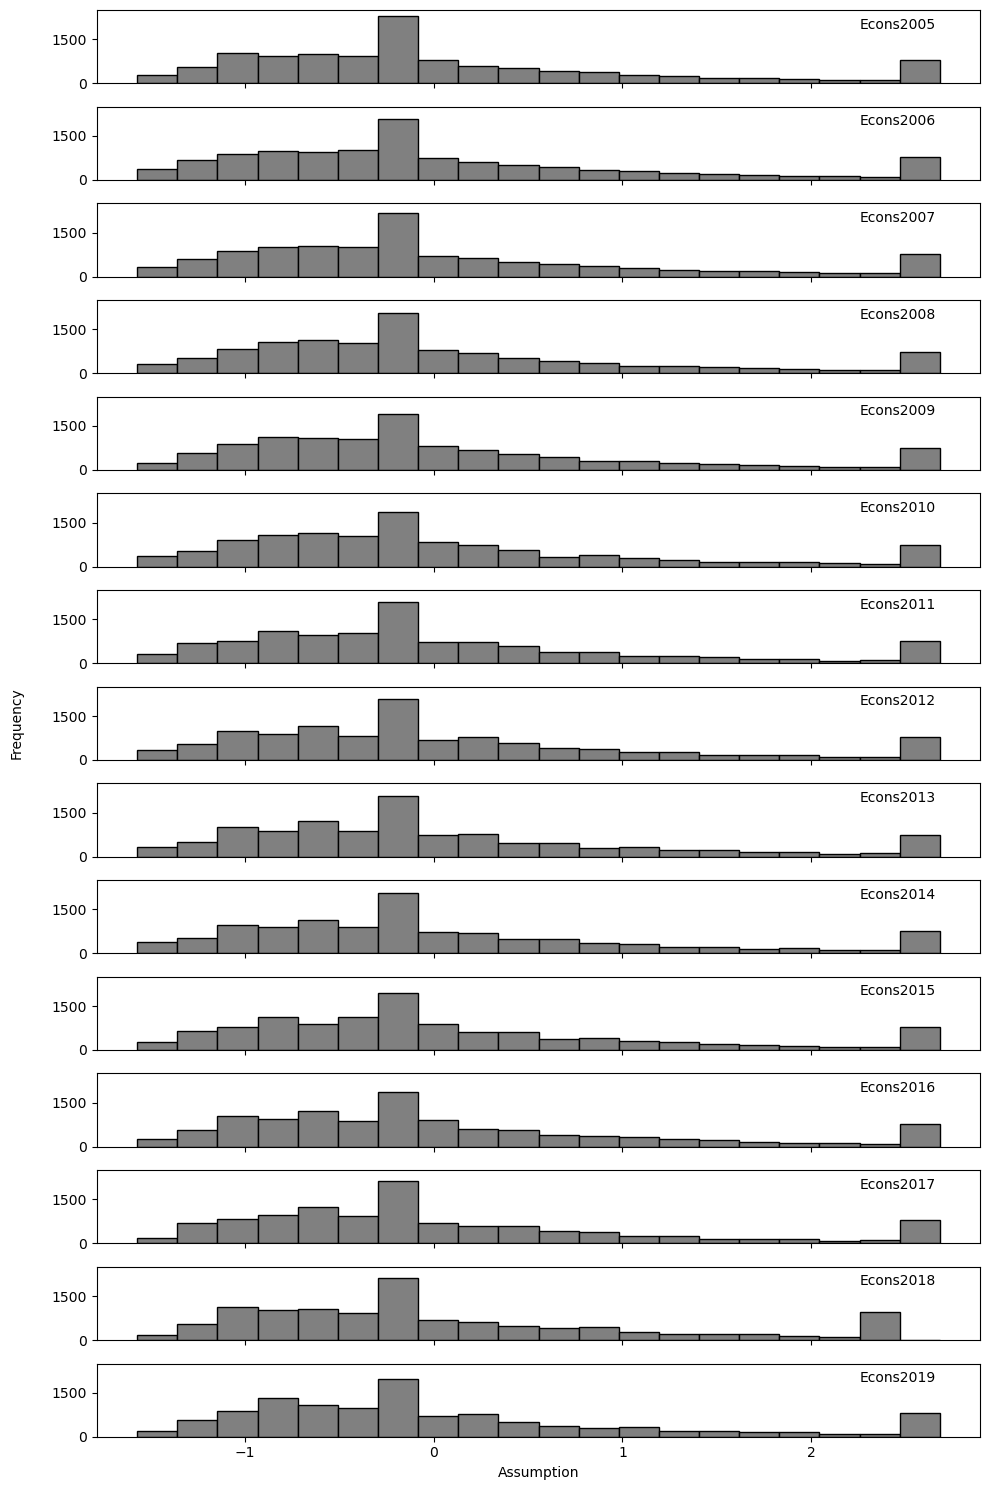

In [202]:
r_data = data[data['PROP_AGE_BAND'] == 1]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 1500]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 2500)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Band 2

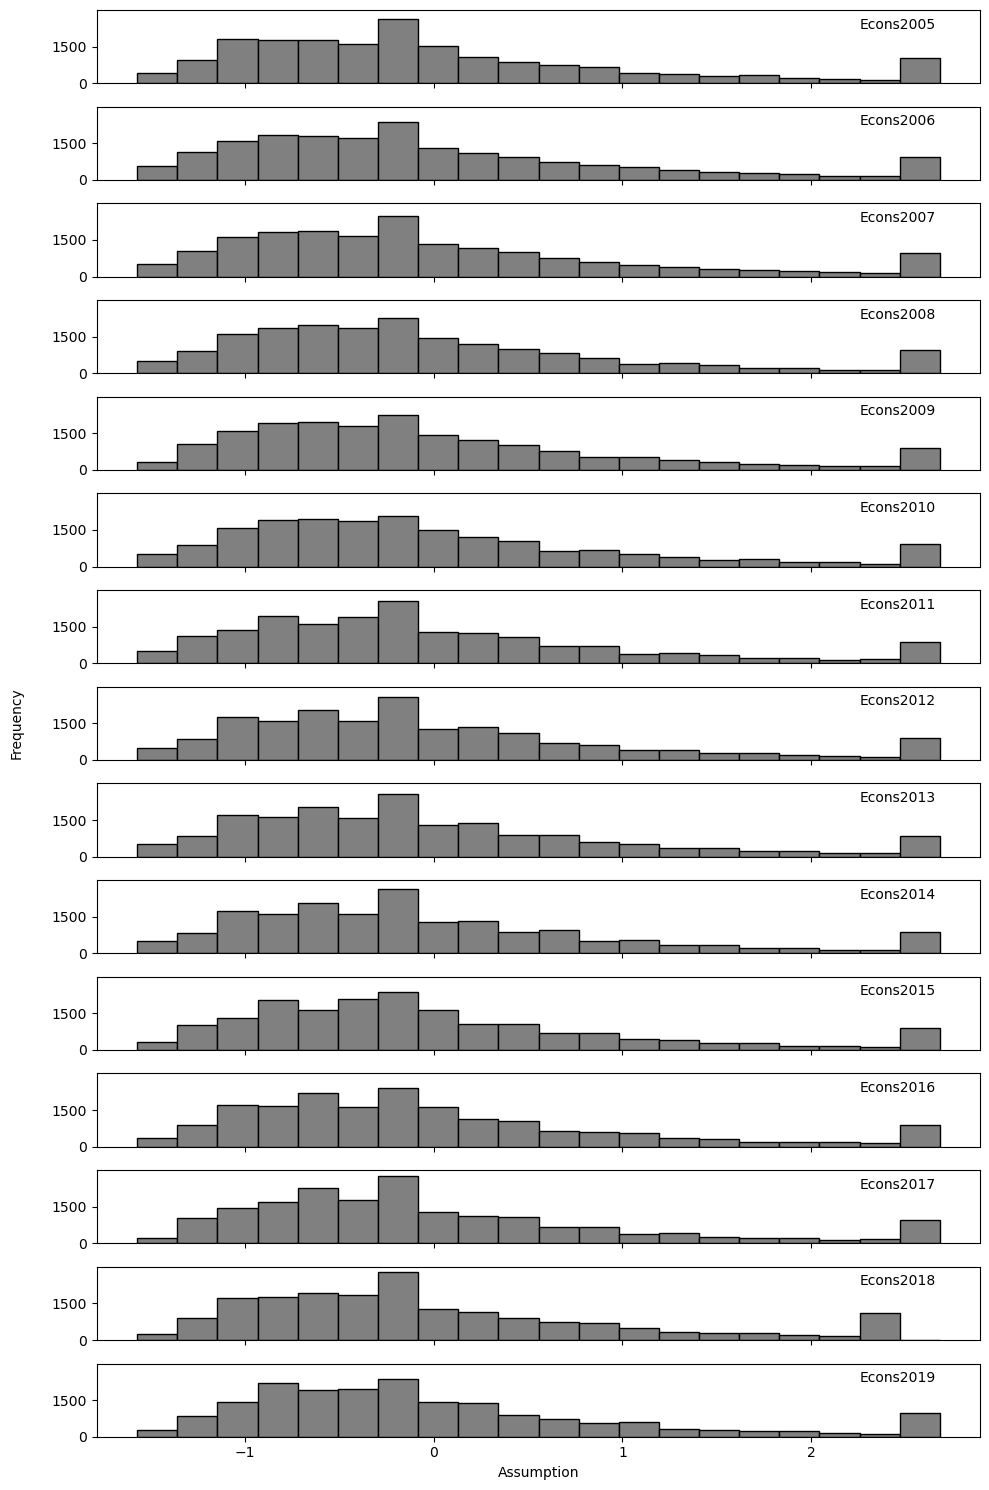

In [204]:
r_data = data[data['PROP_AGE_BAND'] == 2]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 1500]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 3000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Band 3

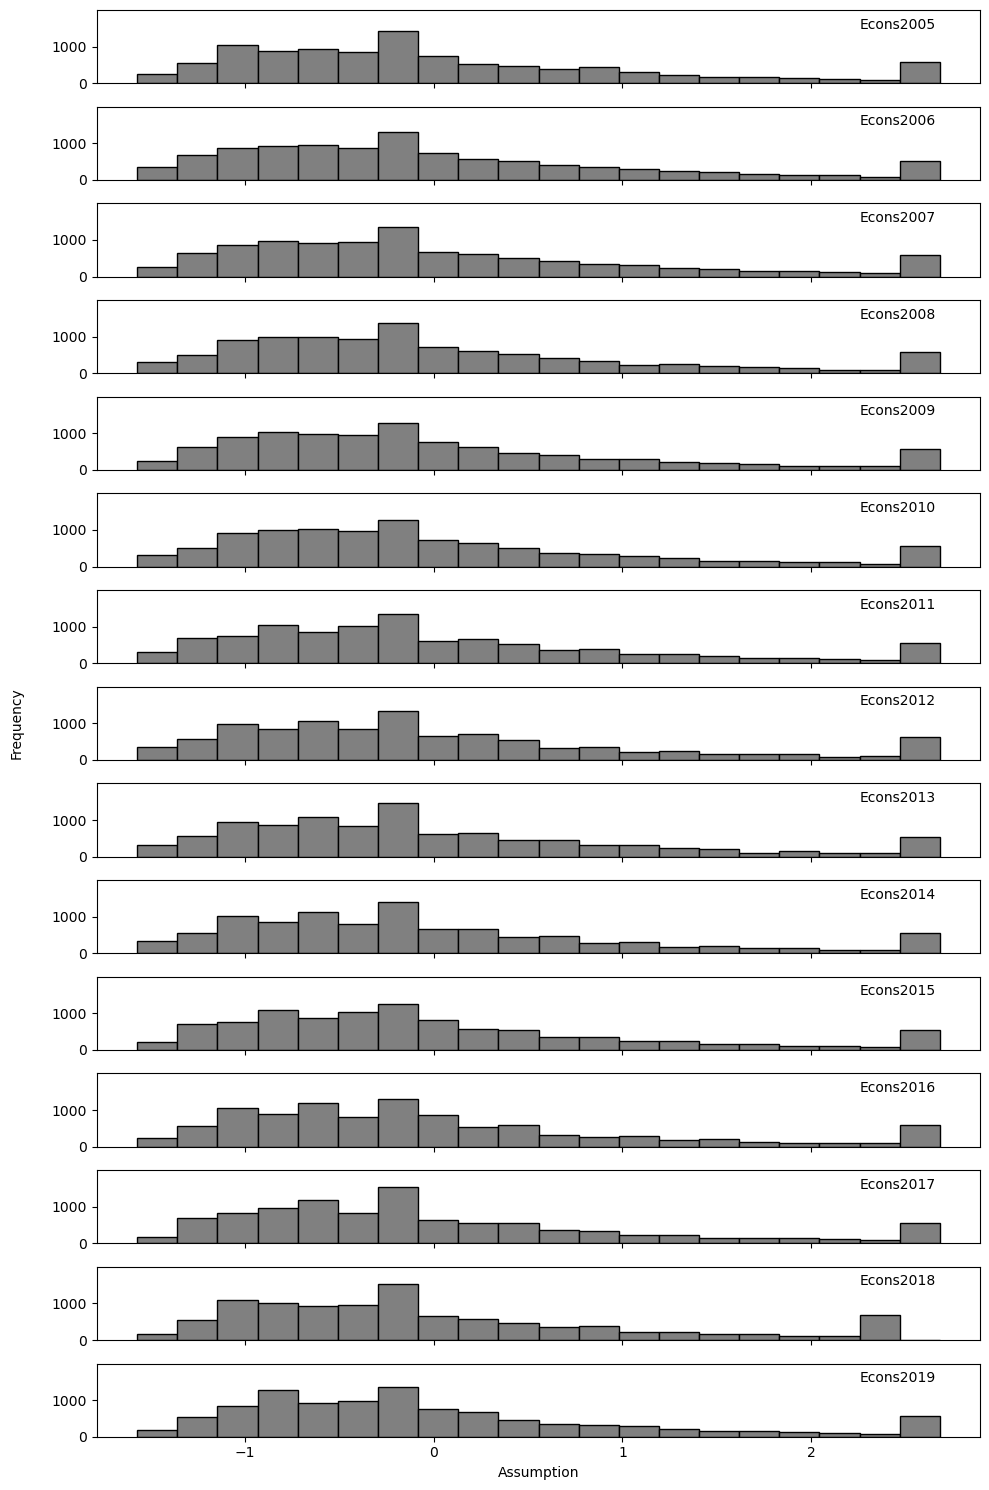

In [206]:
r_data = data[data['PROP_AGE_BAND'] == 3]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 1000]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 2000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Band 4

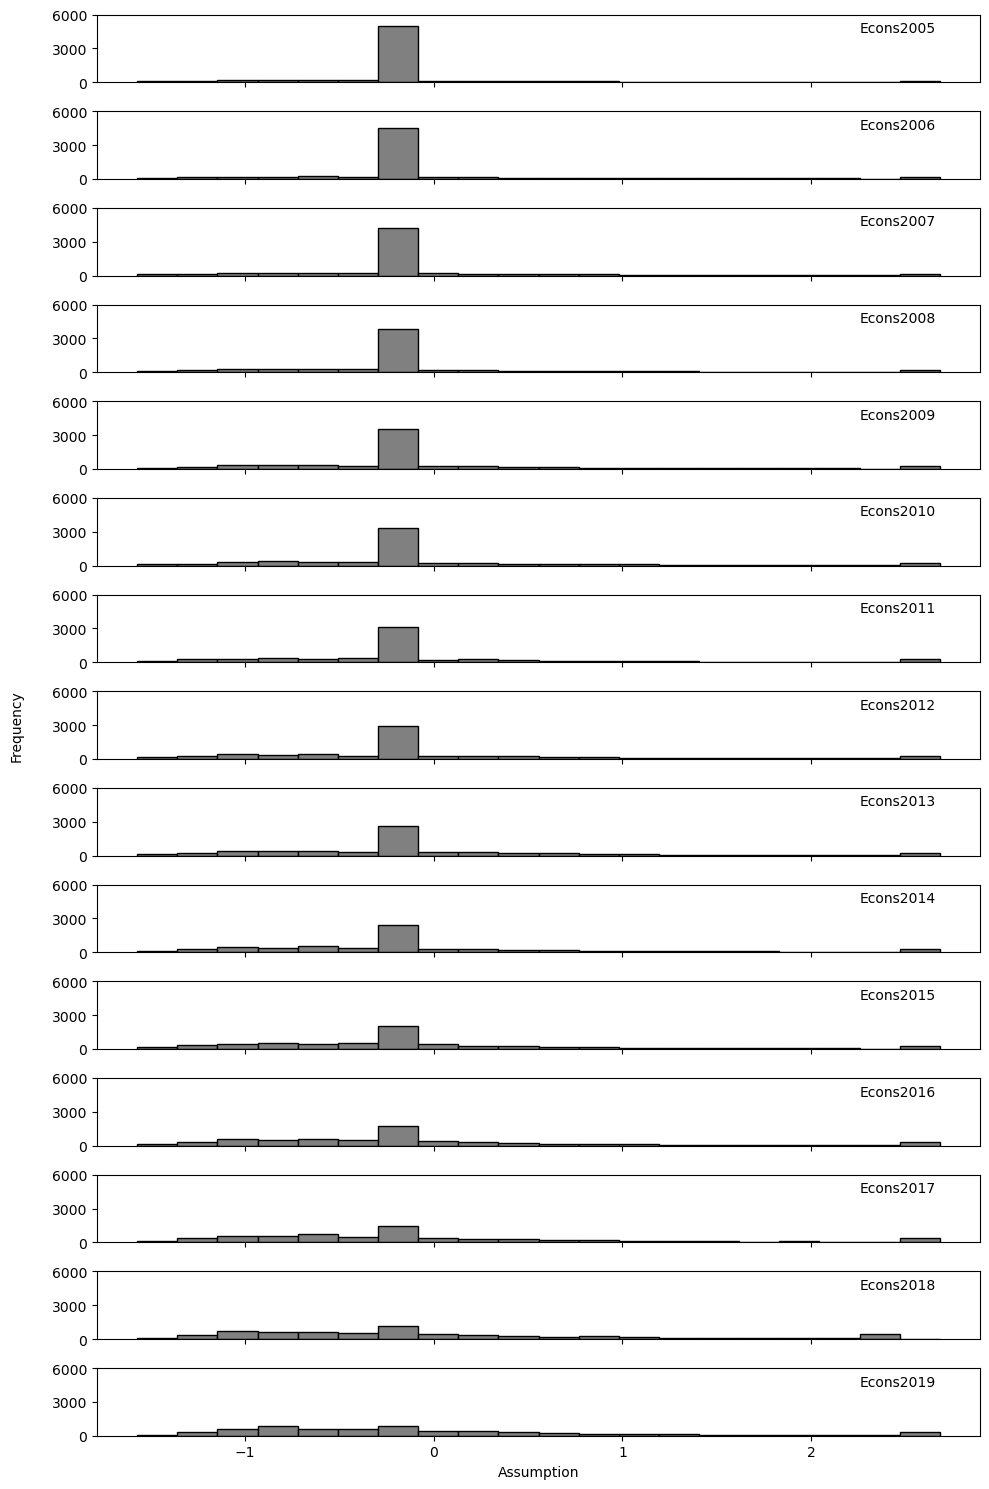

In [215]:
r_data = data[data['PROP_AGE_BAND'] == 4]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 3000,6000]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 6000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

#### 3.1.5 Floor Area Band

##### Band 1

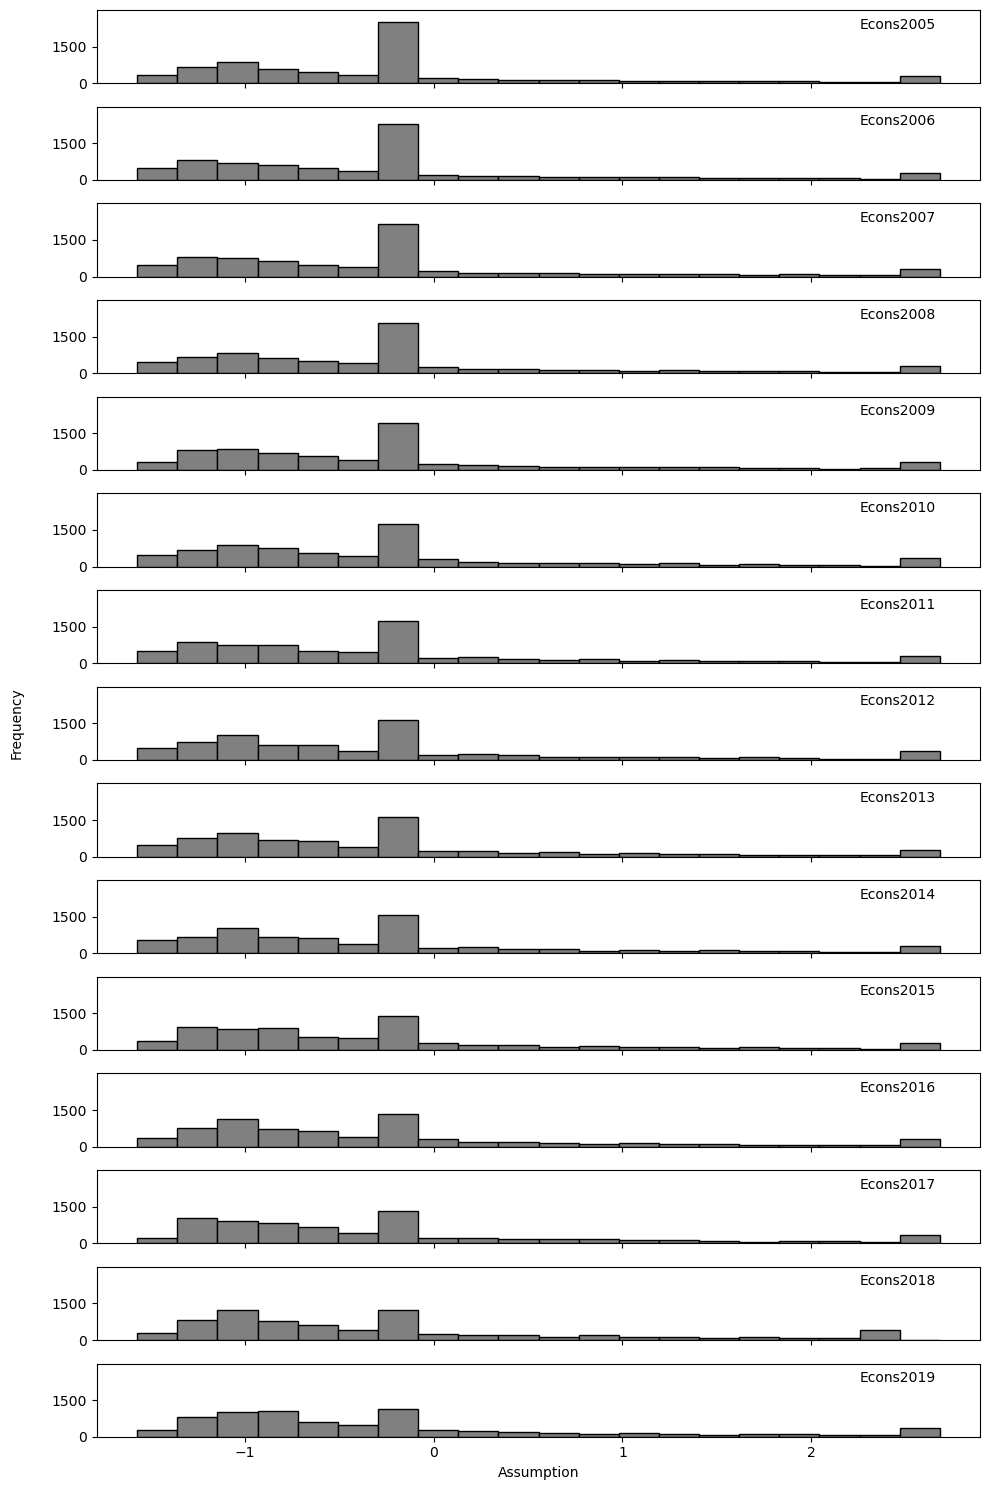

In [218]:
r_data = data[data['FLOOR_AREA_BAND'] == 1]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 1500]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 3000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Band 2

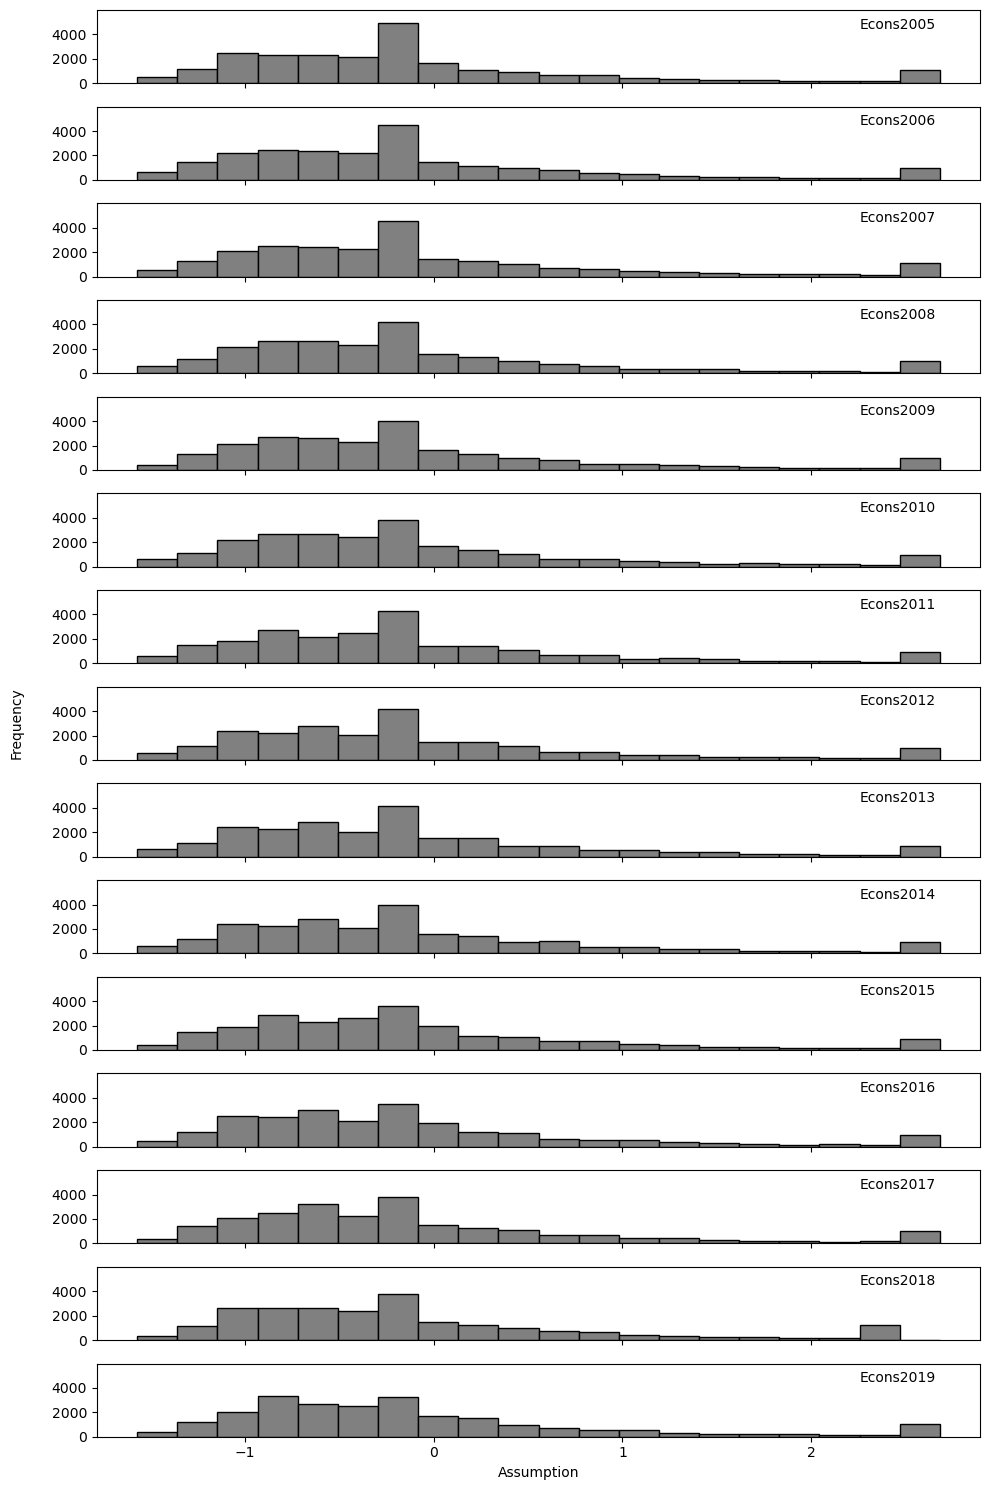

In [224]:
r_data = data[data['FLOOR_AREA_BAND'] == 2]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 2000,4000]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 6000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Band 3

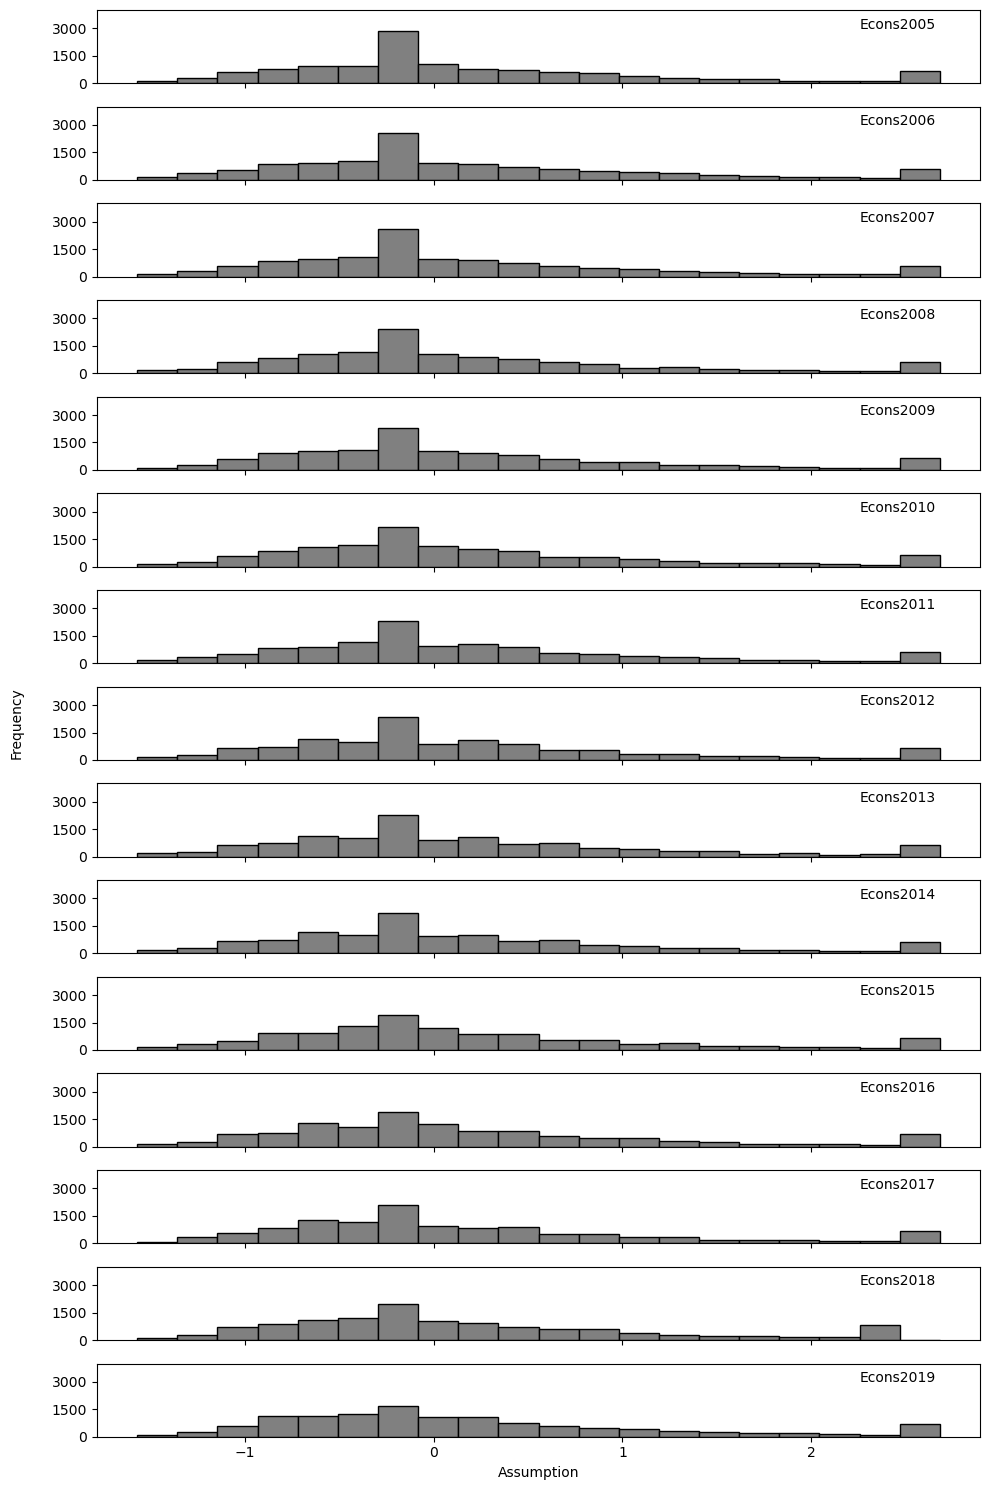

In [227]:
r_data = data[data['FLOOR_AREA_BAND'] == 3]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 1500,3000]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 4000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Band 4

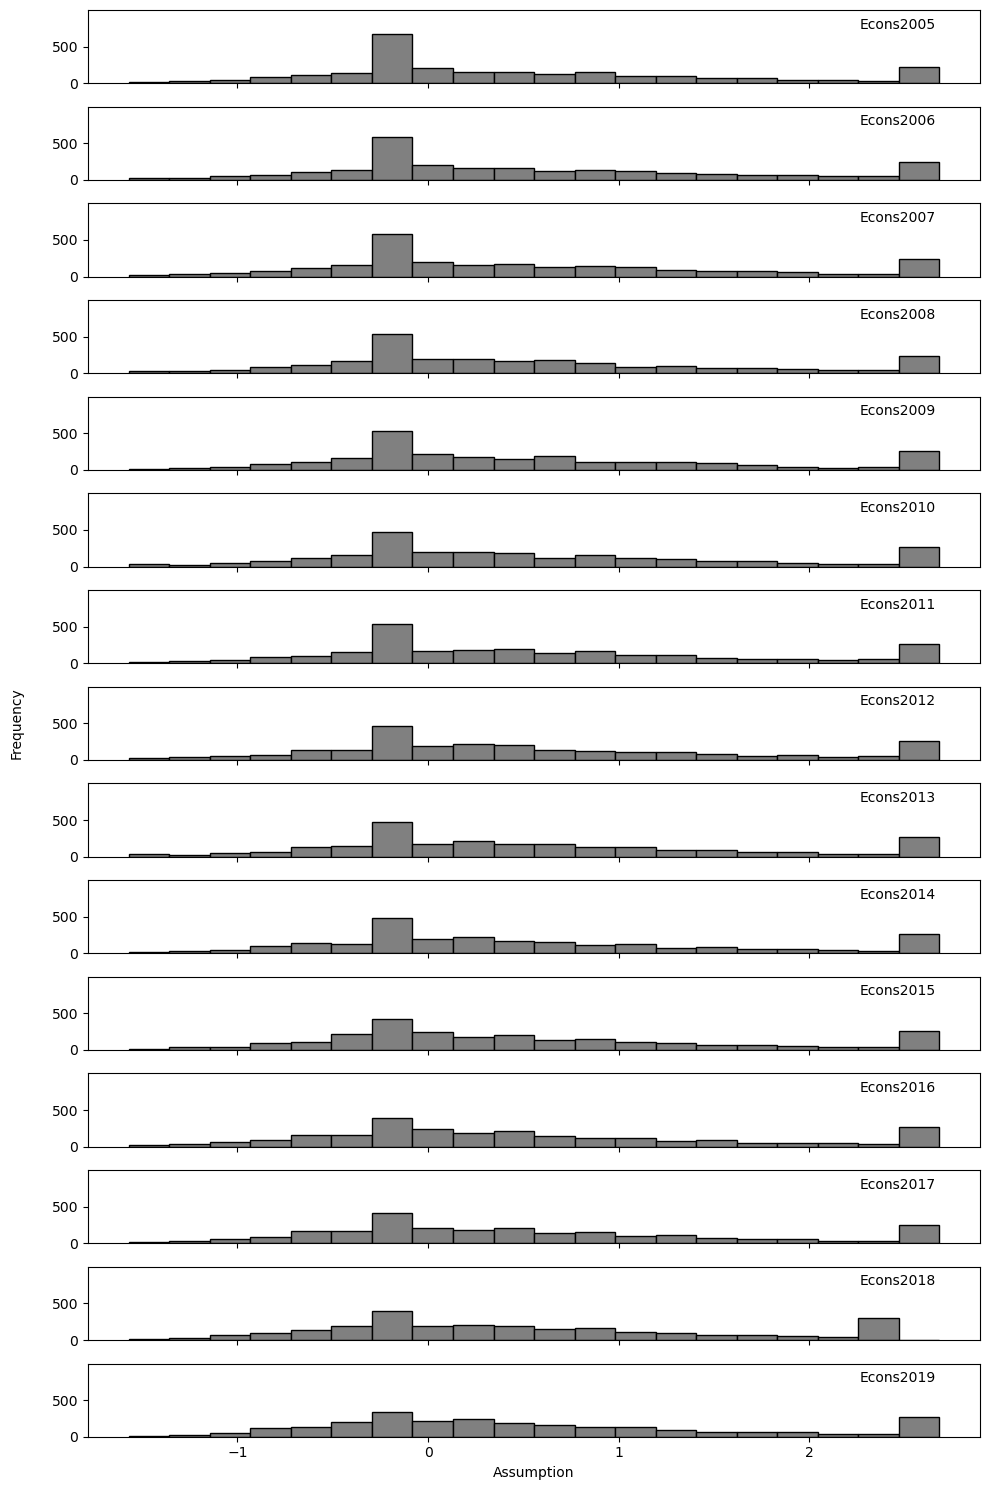

In [230]:
r_data = data[data['FLOOR_AREA_BAND'] == 4]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 500]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 1000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Band 5

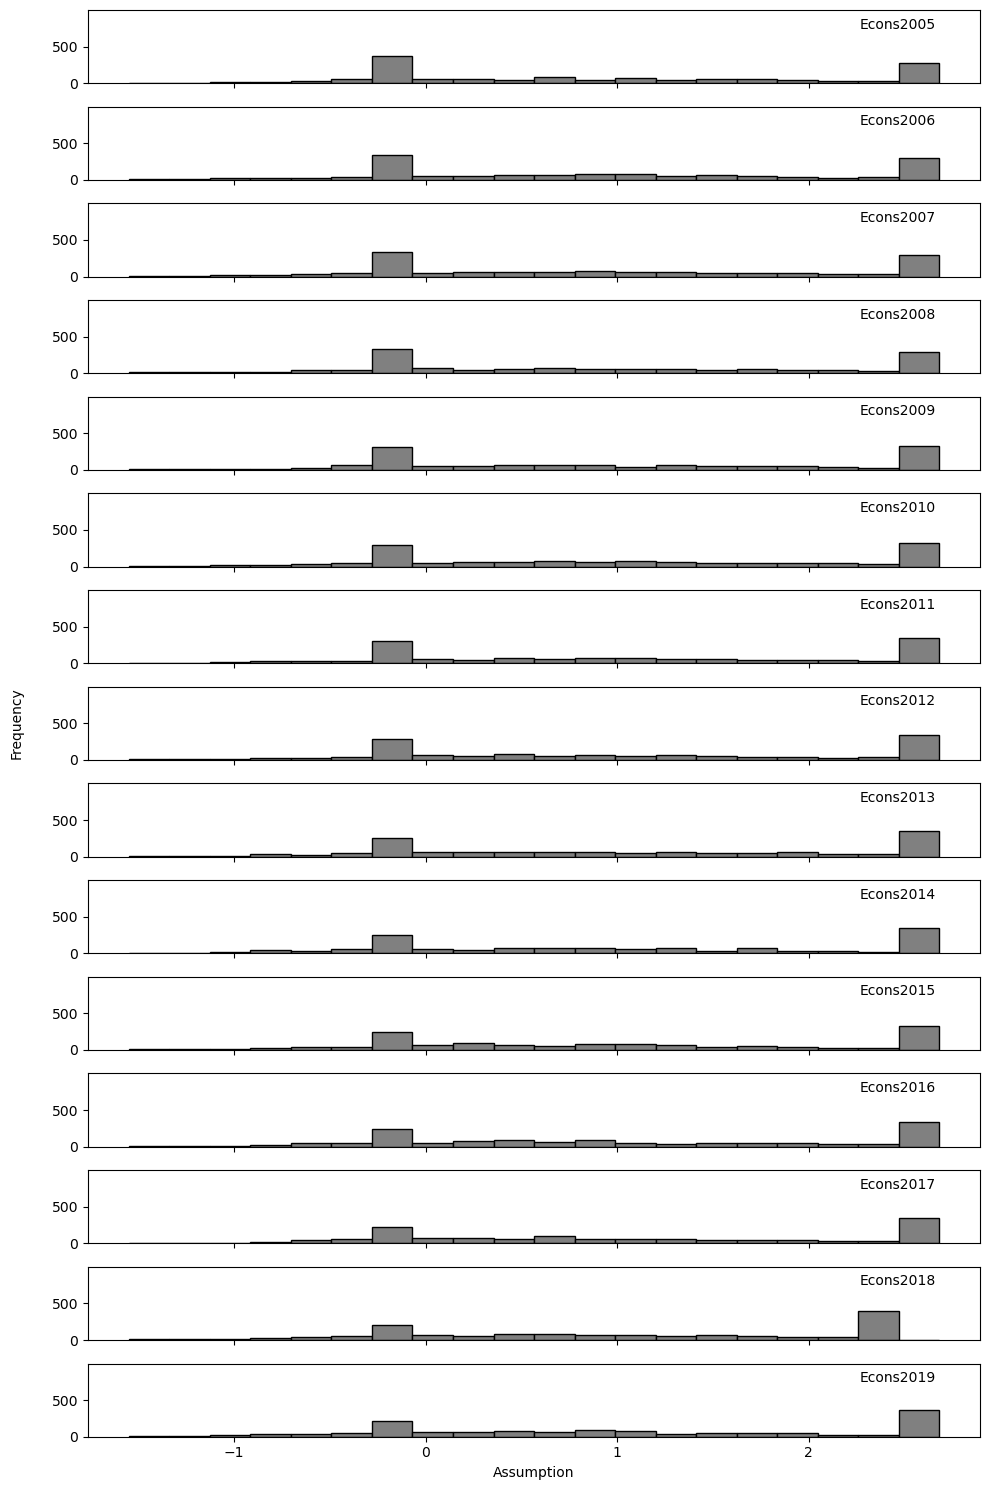

In [231]:
r_data = data[data['FLOOR_AREA_BAND'] == 5]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 500]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 1000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

#### 3.1.6 IMD Band

##### Band 1

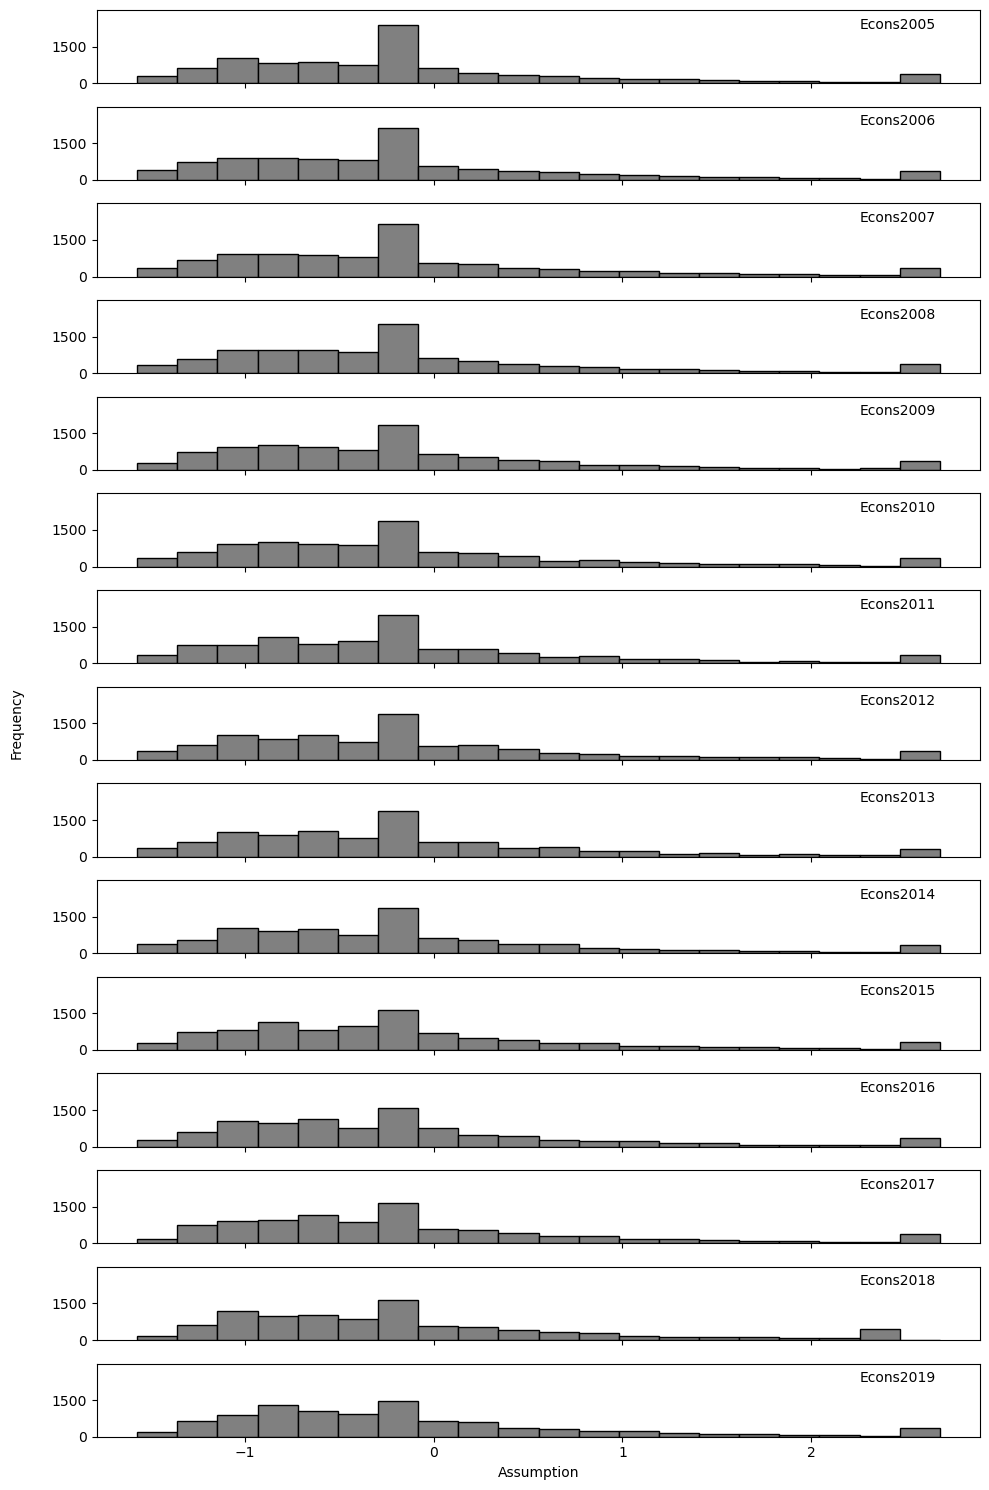

In [235]:
r_data = data[data['IMD_BAND_ENG'] == 1]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 1500]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 3000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Band 2

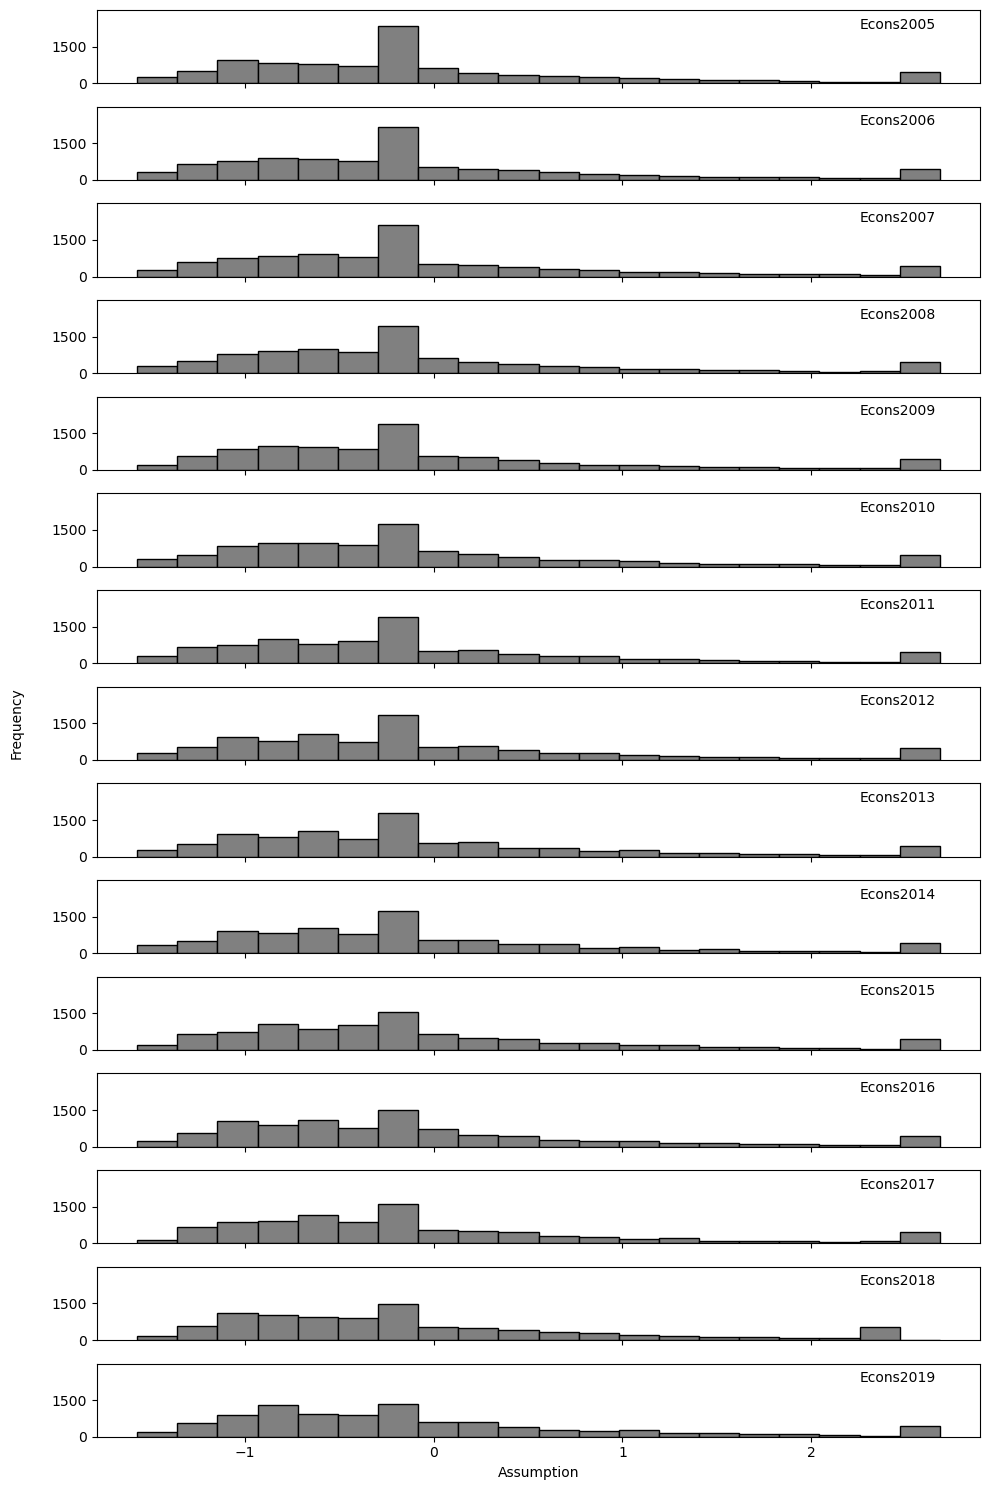

In [236]:
r_data = data[data['IMD_BAND_ENG'] == 2]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 1500]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 3000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Band 3

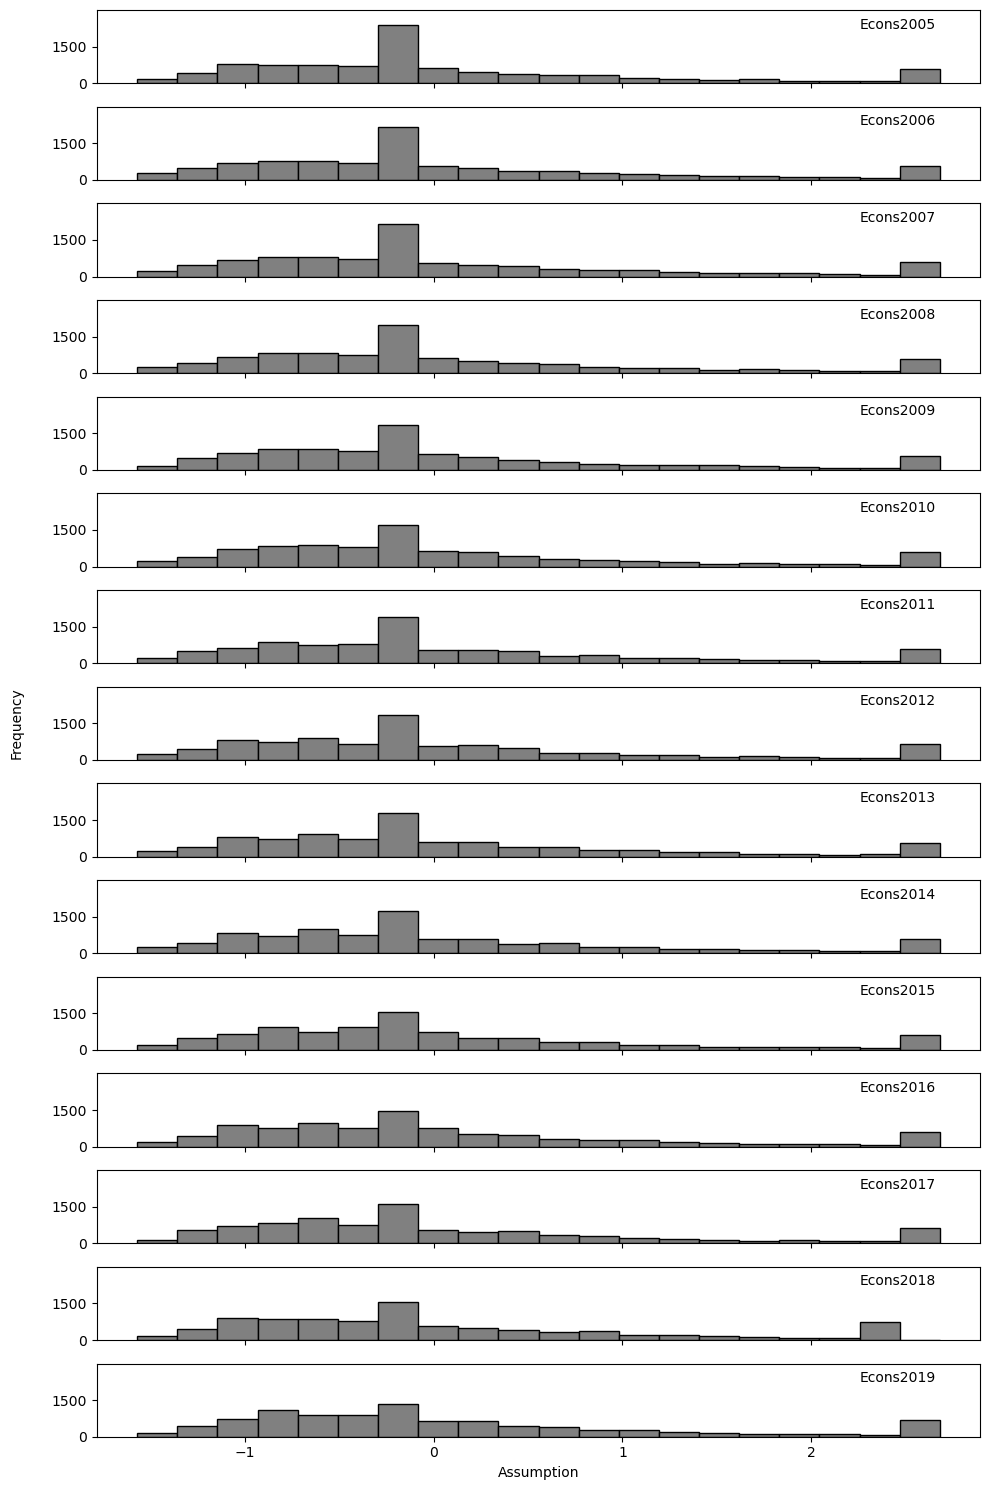

In [237]:
r_data = data[data['IMD_BAND_ENG'] == 3]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 1500]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 3000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Band 4

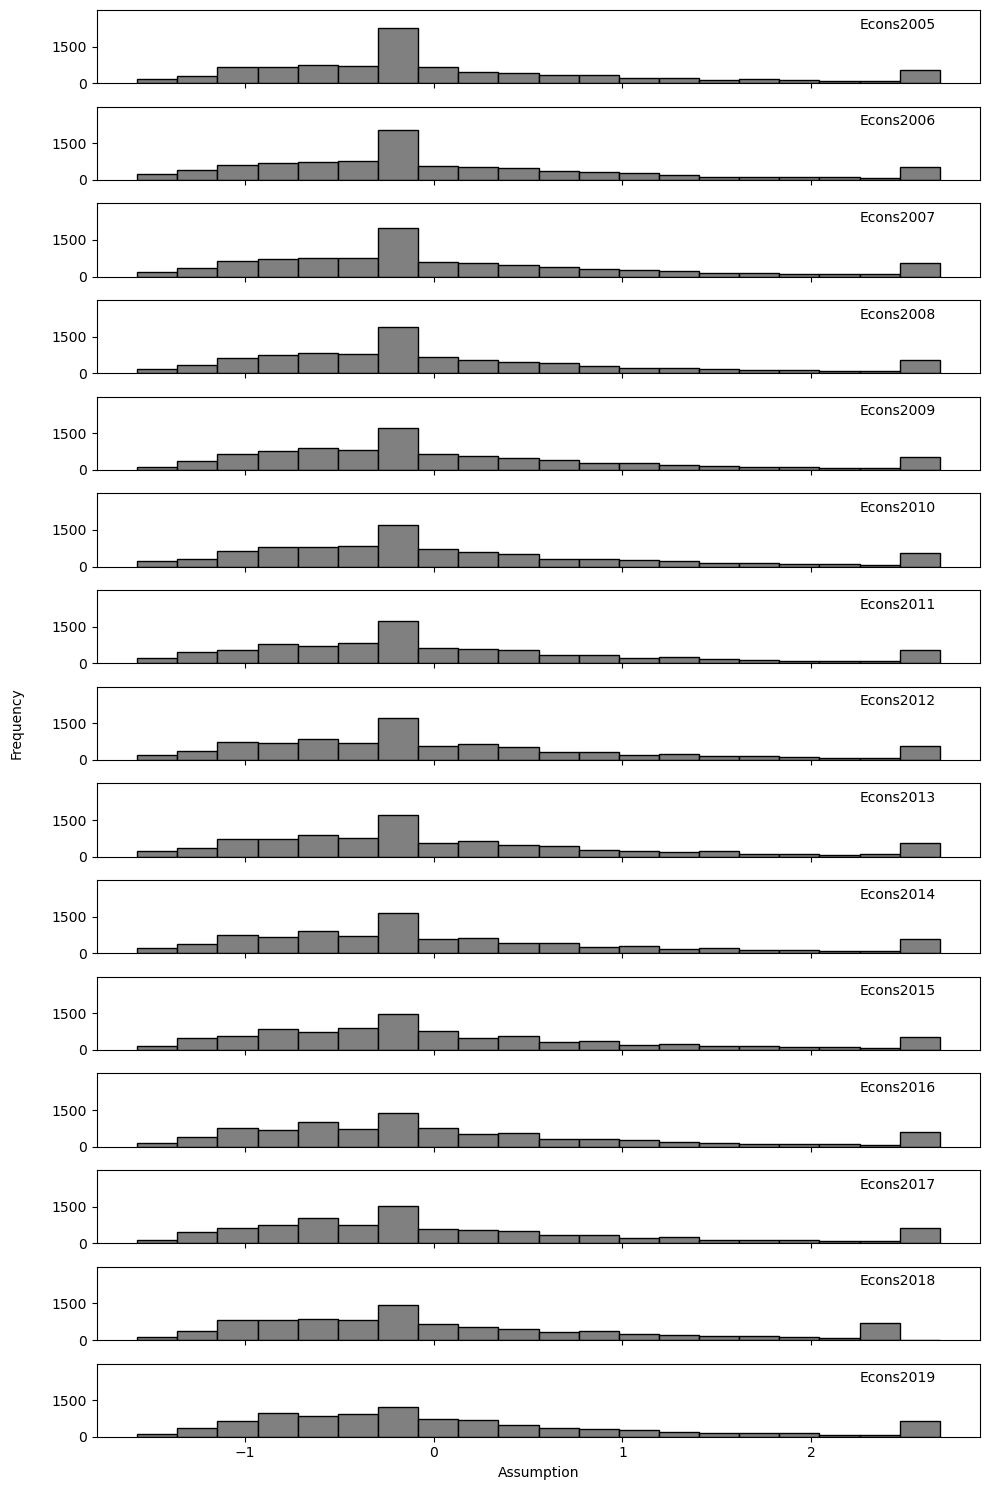

In [239]:
r_data = data[data['IMD_BAND_ENG'] == 4]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 1500]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 3000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### Band 5

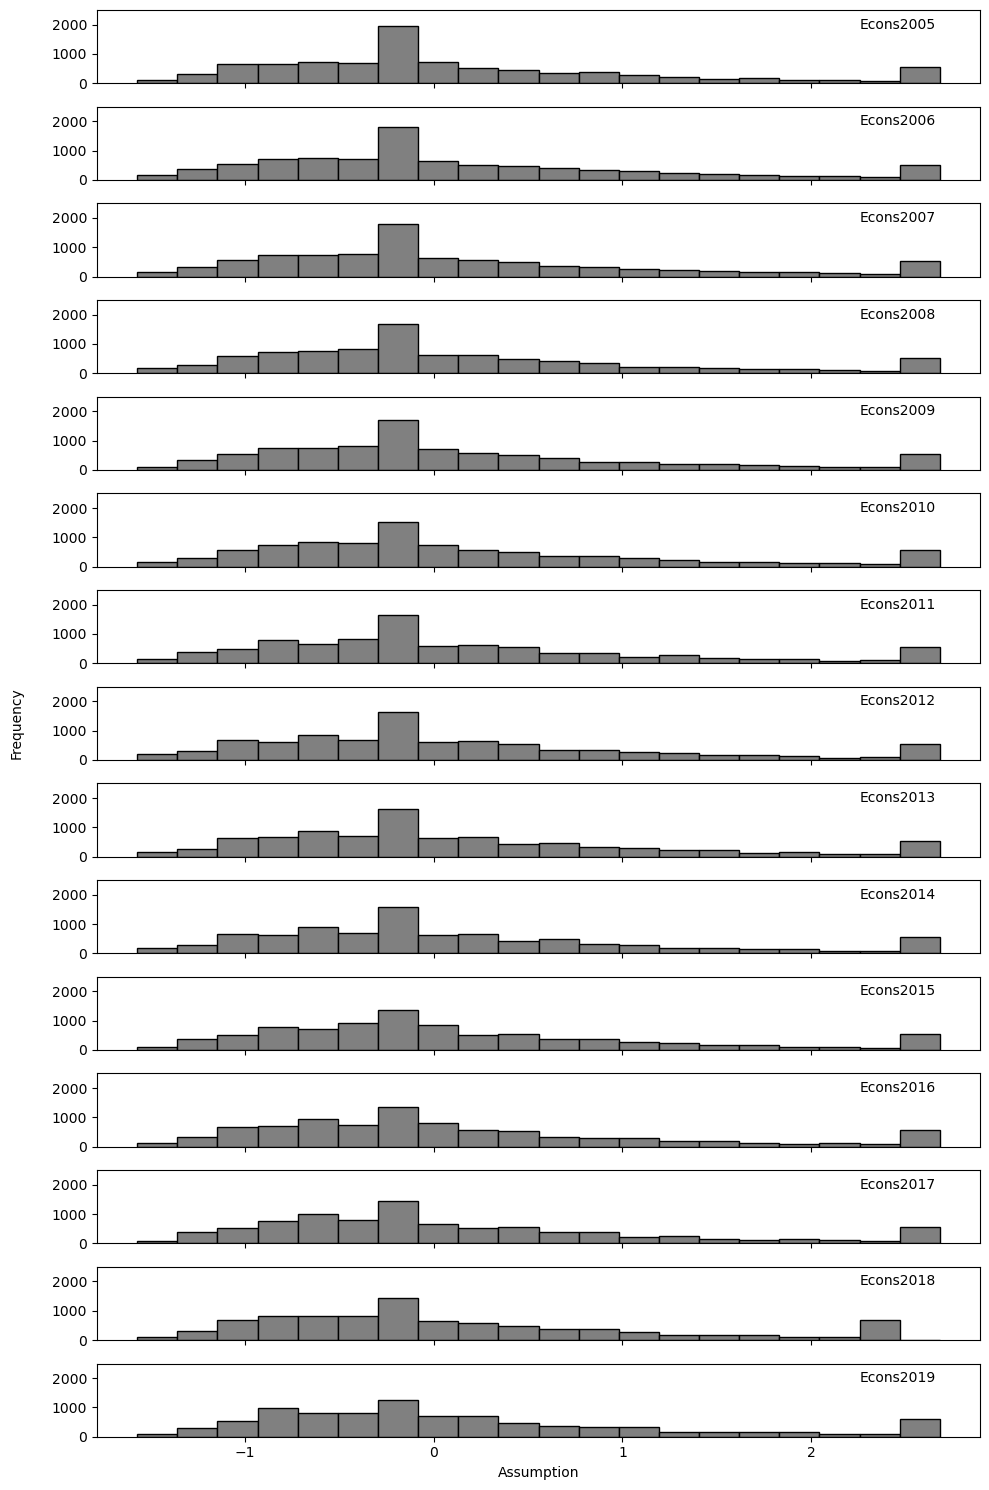

In [243]:
r_data = data[data['IMD_BAND_ENG'] == 5]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 1000,2000]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 2500)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

#### 3.1.7 Li Flag

##### 0

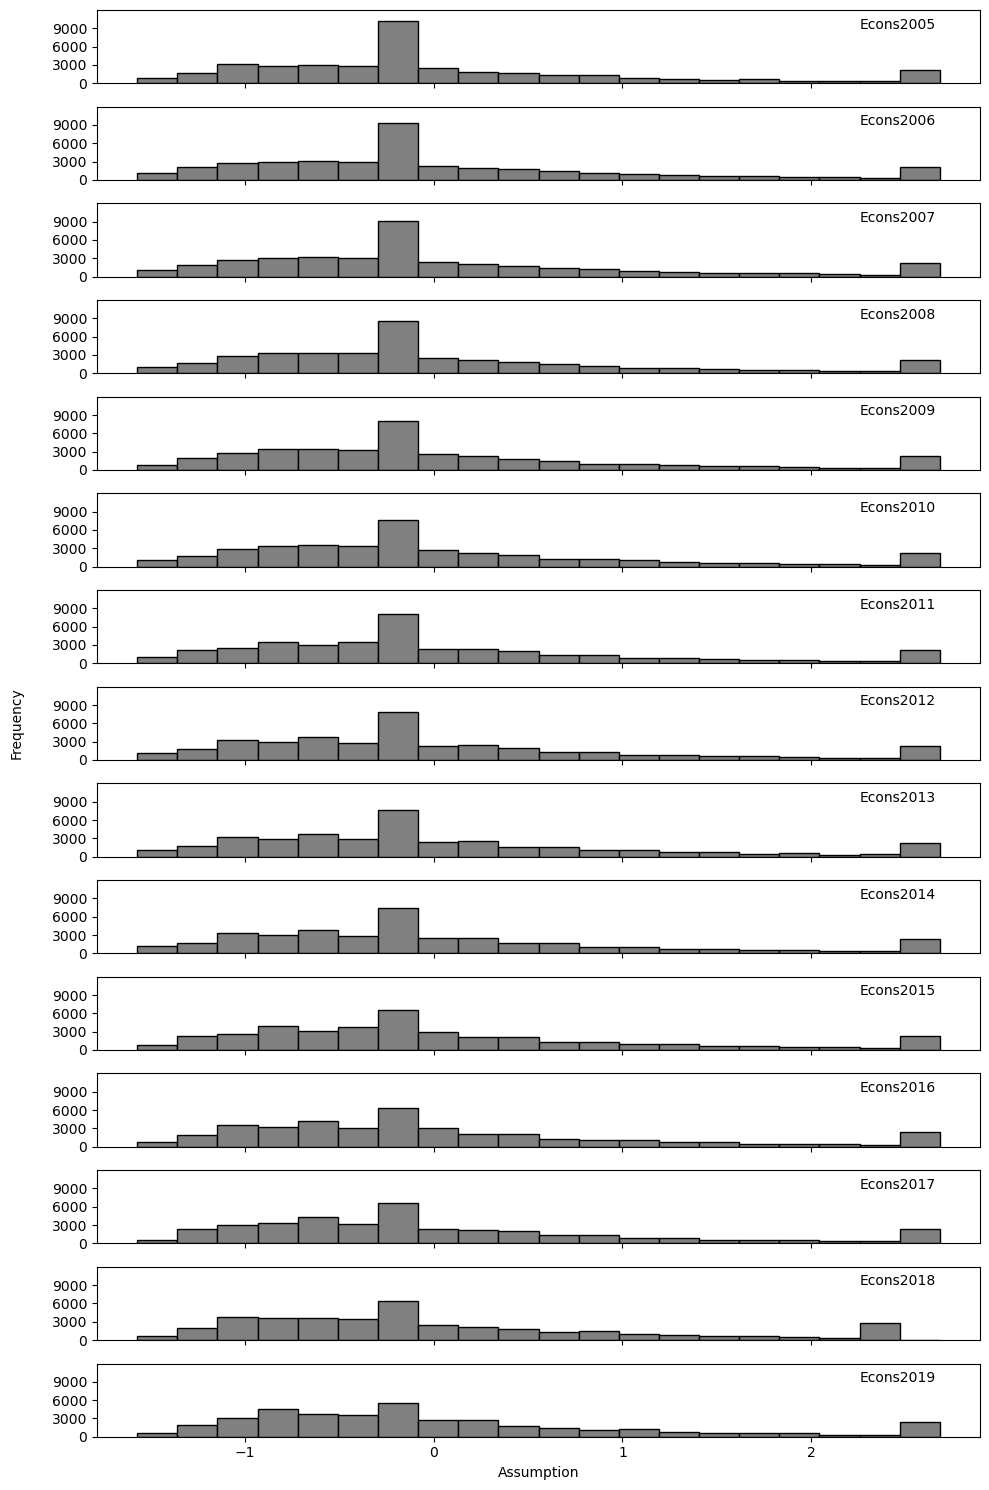

In [250]:
r_data = data[data['LI_FLAG'] == 0]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 3000,6000,9000.12000]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 12000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### 1

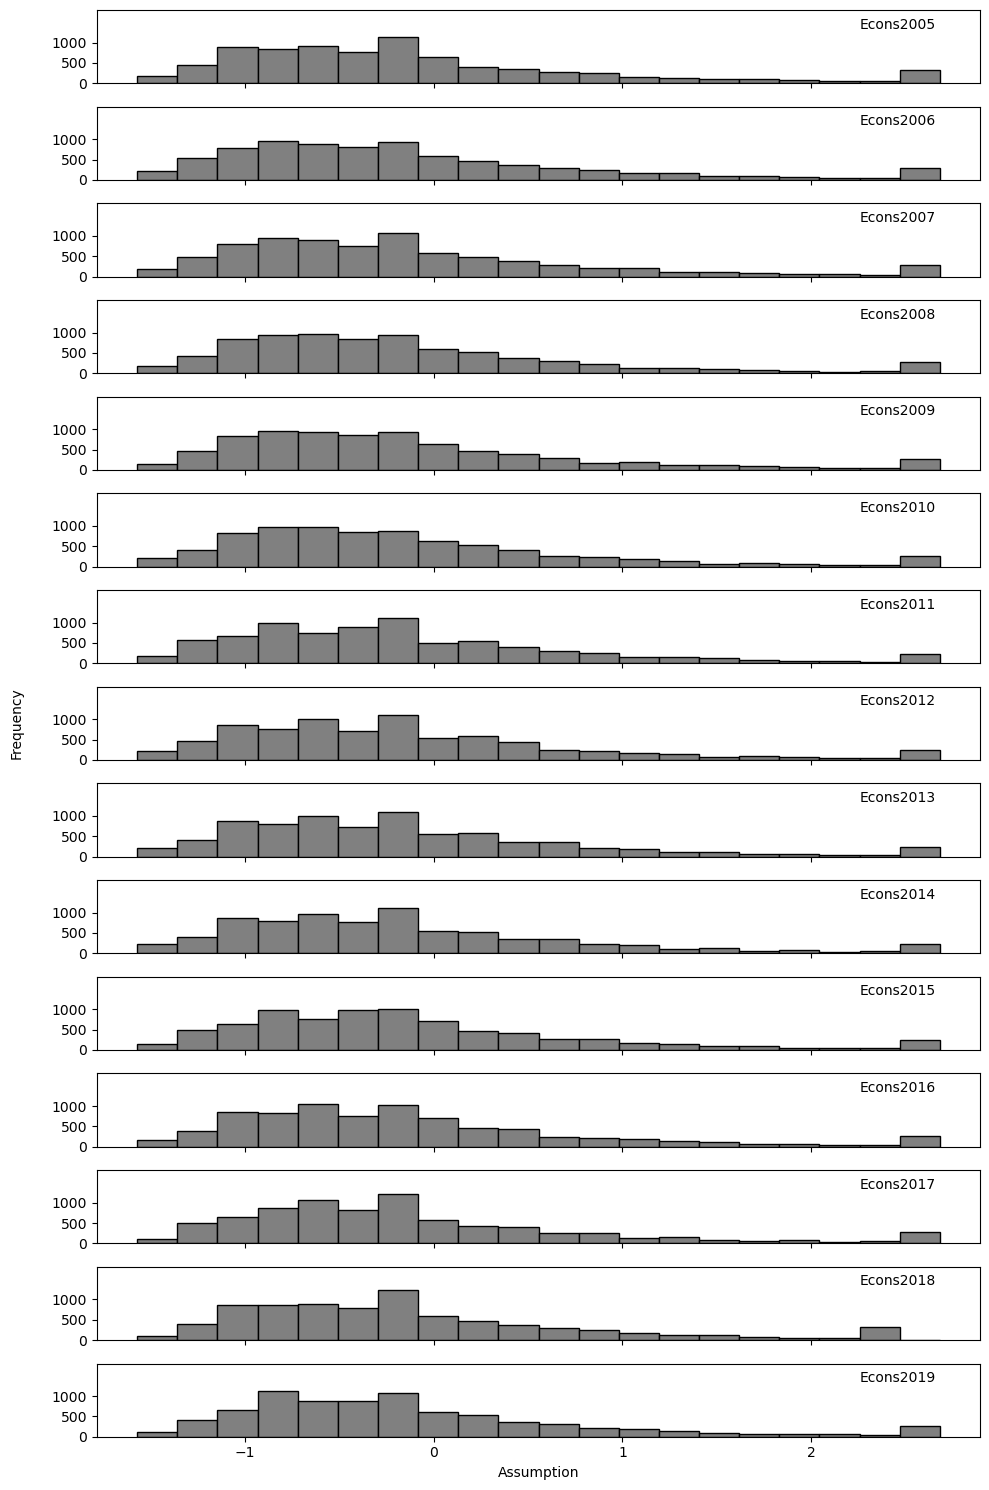

In [254]:
r_data = data[data['LI_FLAG'] == 1]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 500,1000]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 1800)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

#### 3.1.8 CWI Flag

##### 0

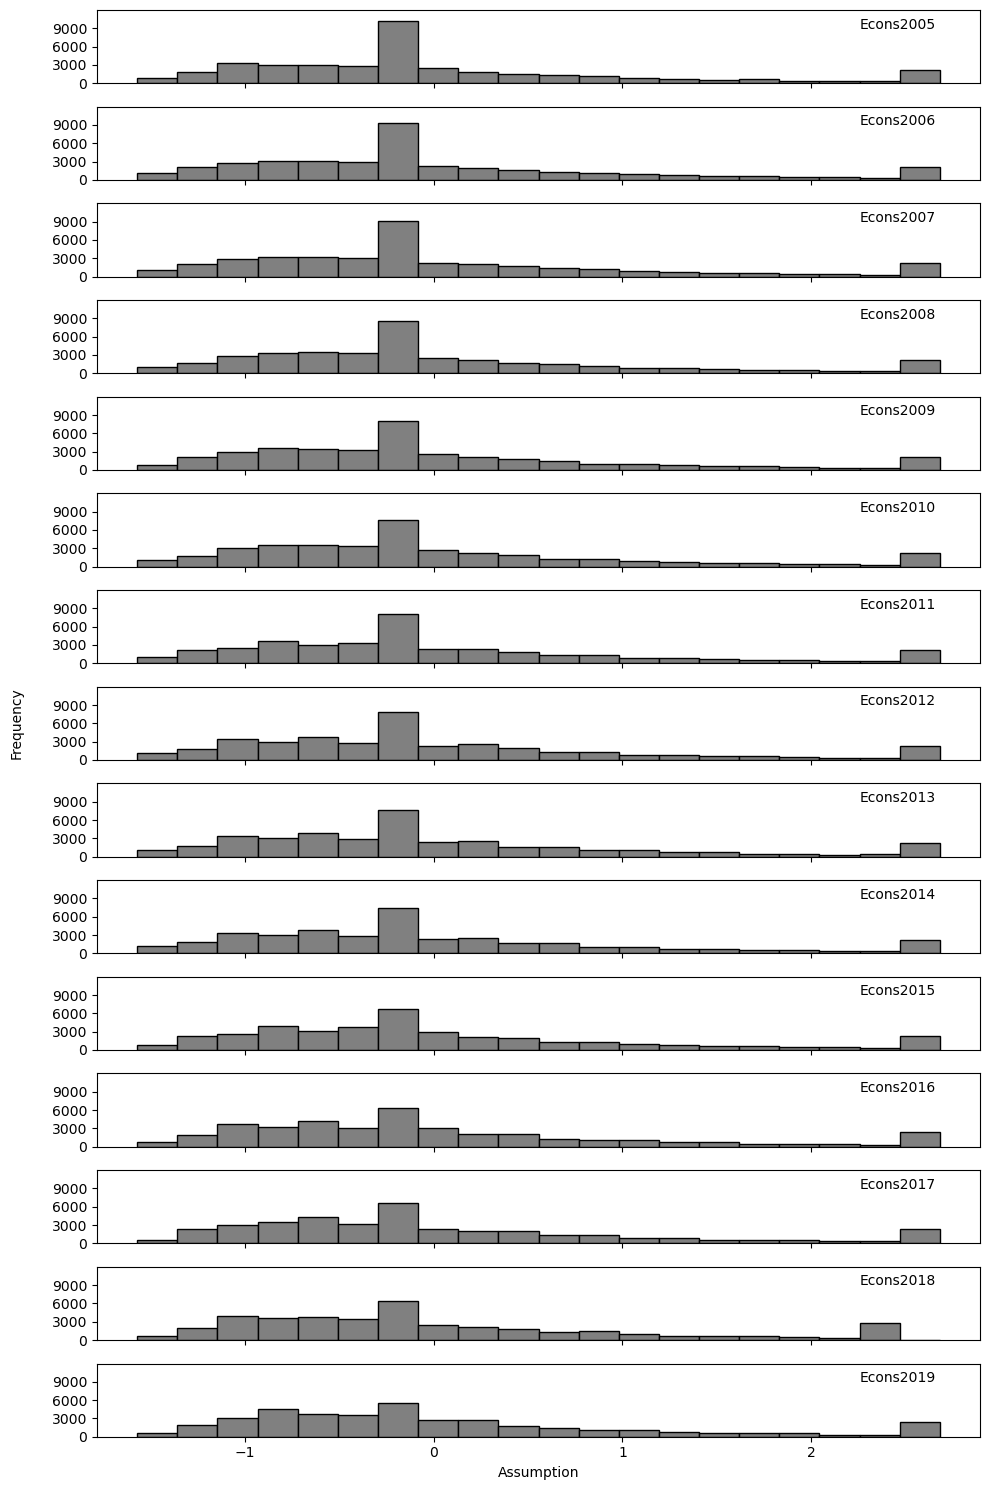

In [255]:
r_data = data[data['CWI_FLAG'] == 0]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 3000,6000,9000.12000]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 12000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### 1

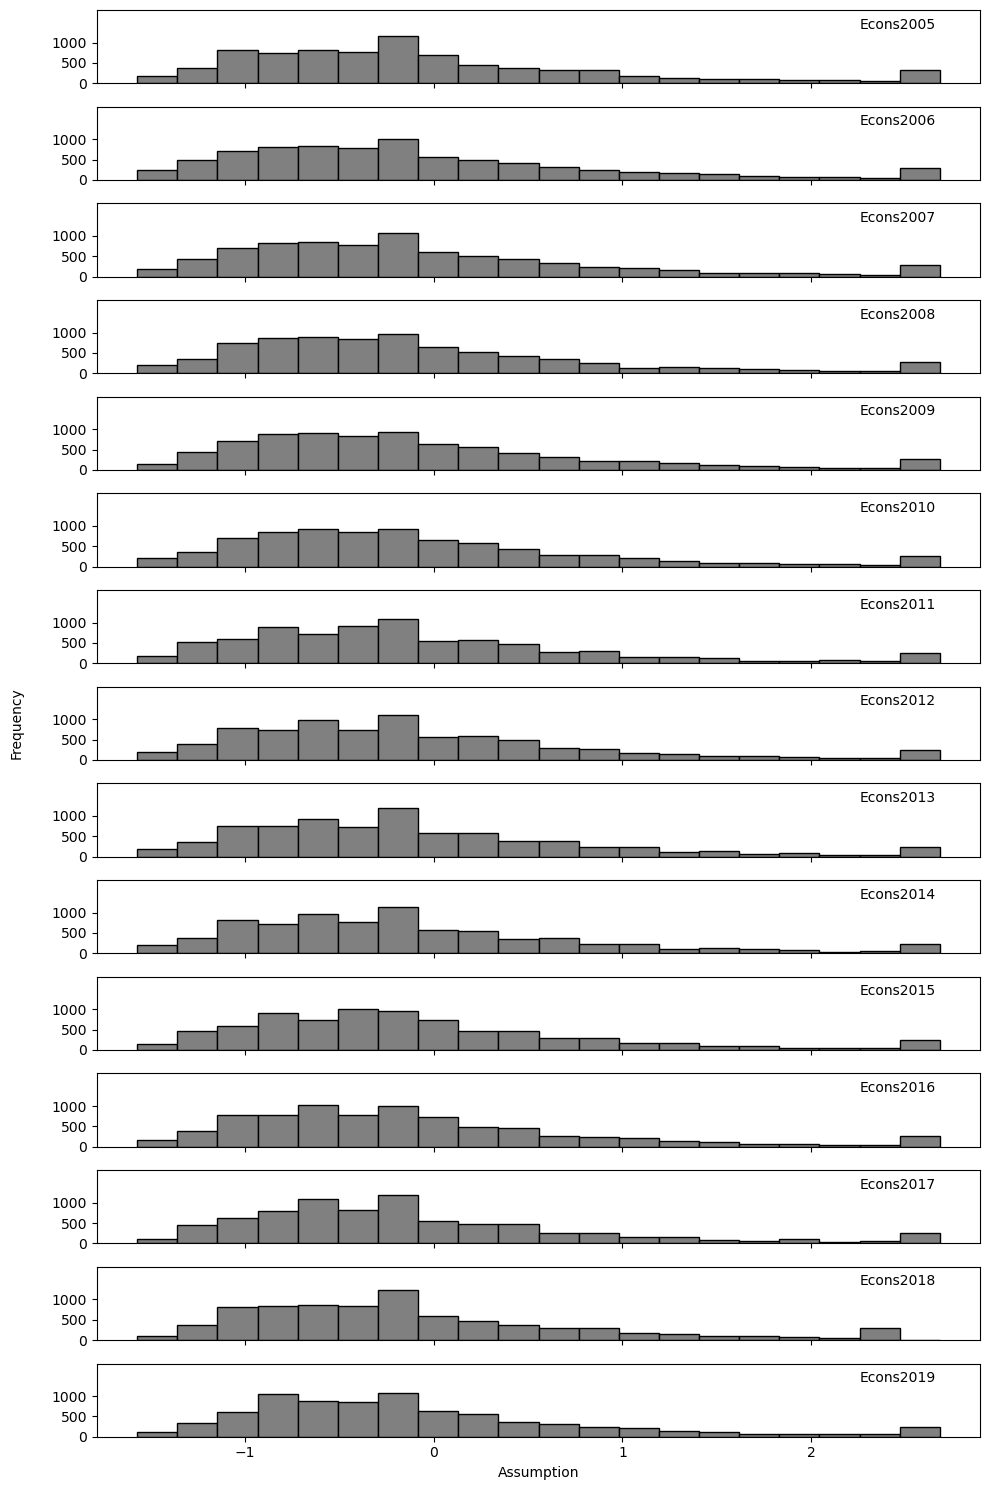

In [256]:
r_data = data[data['CWI_FLAG'] == 1]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 500,1000]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 1800)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

#### 3.1.9 PV Flag

##### 0

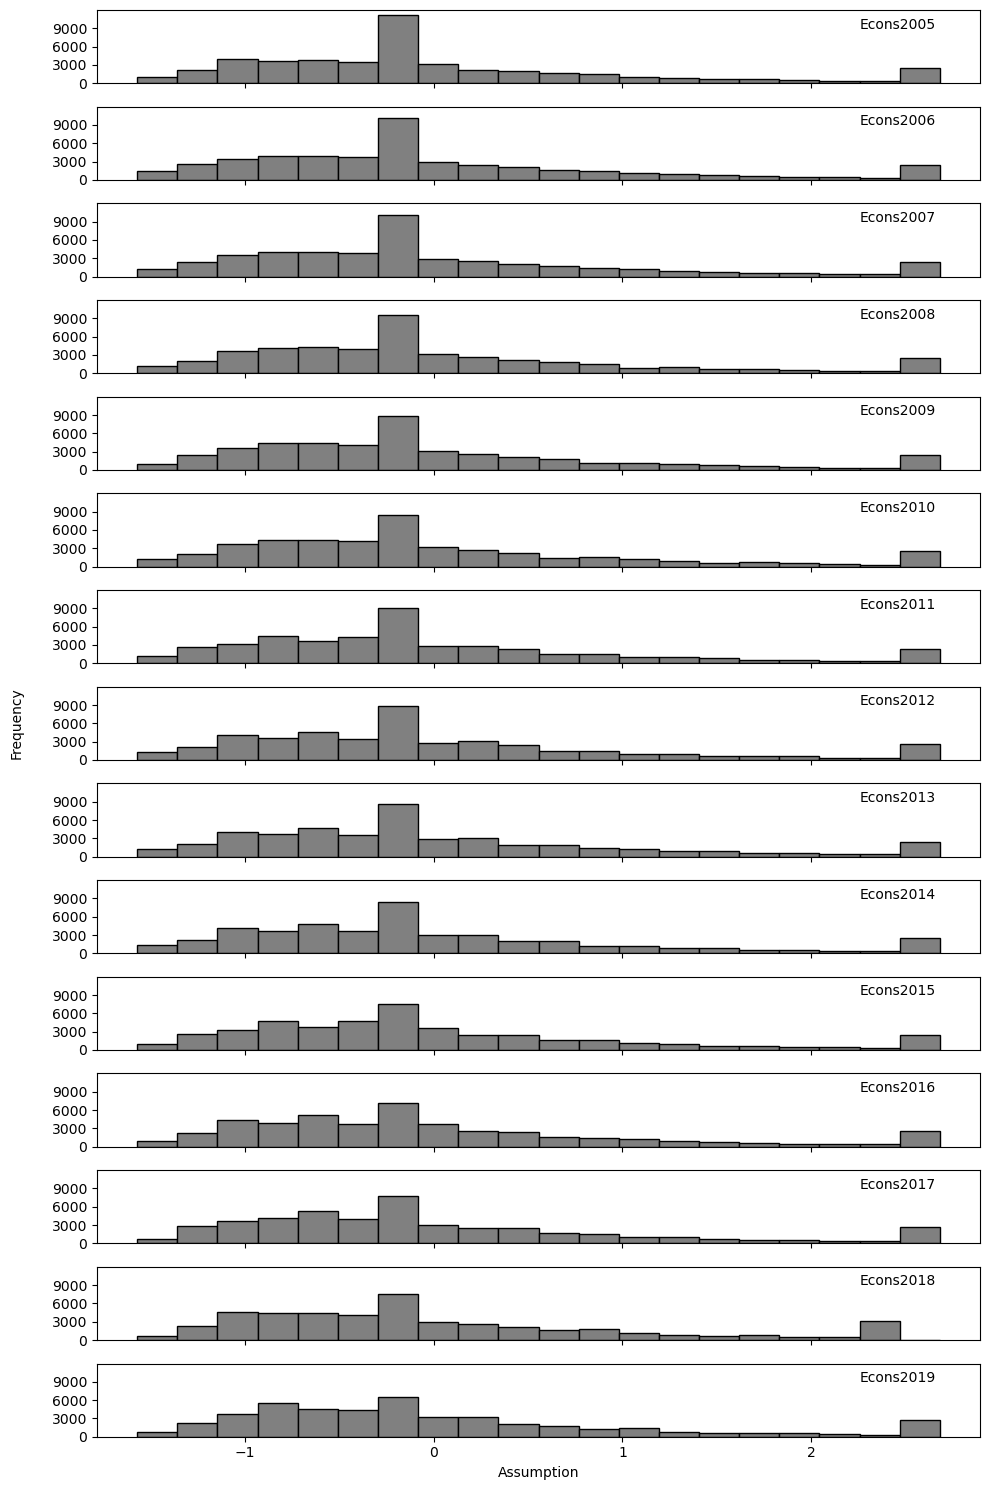

In [257]:
r_data = data[data['PV_FLAG'] == 0]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 3000,6000,9000.12000]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 12000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### 1

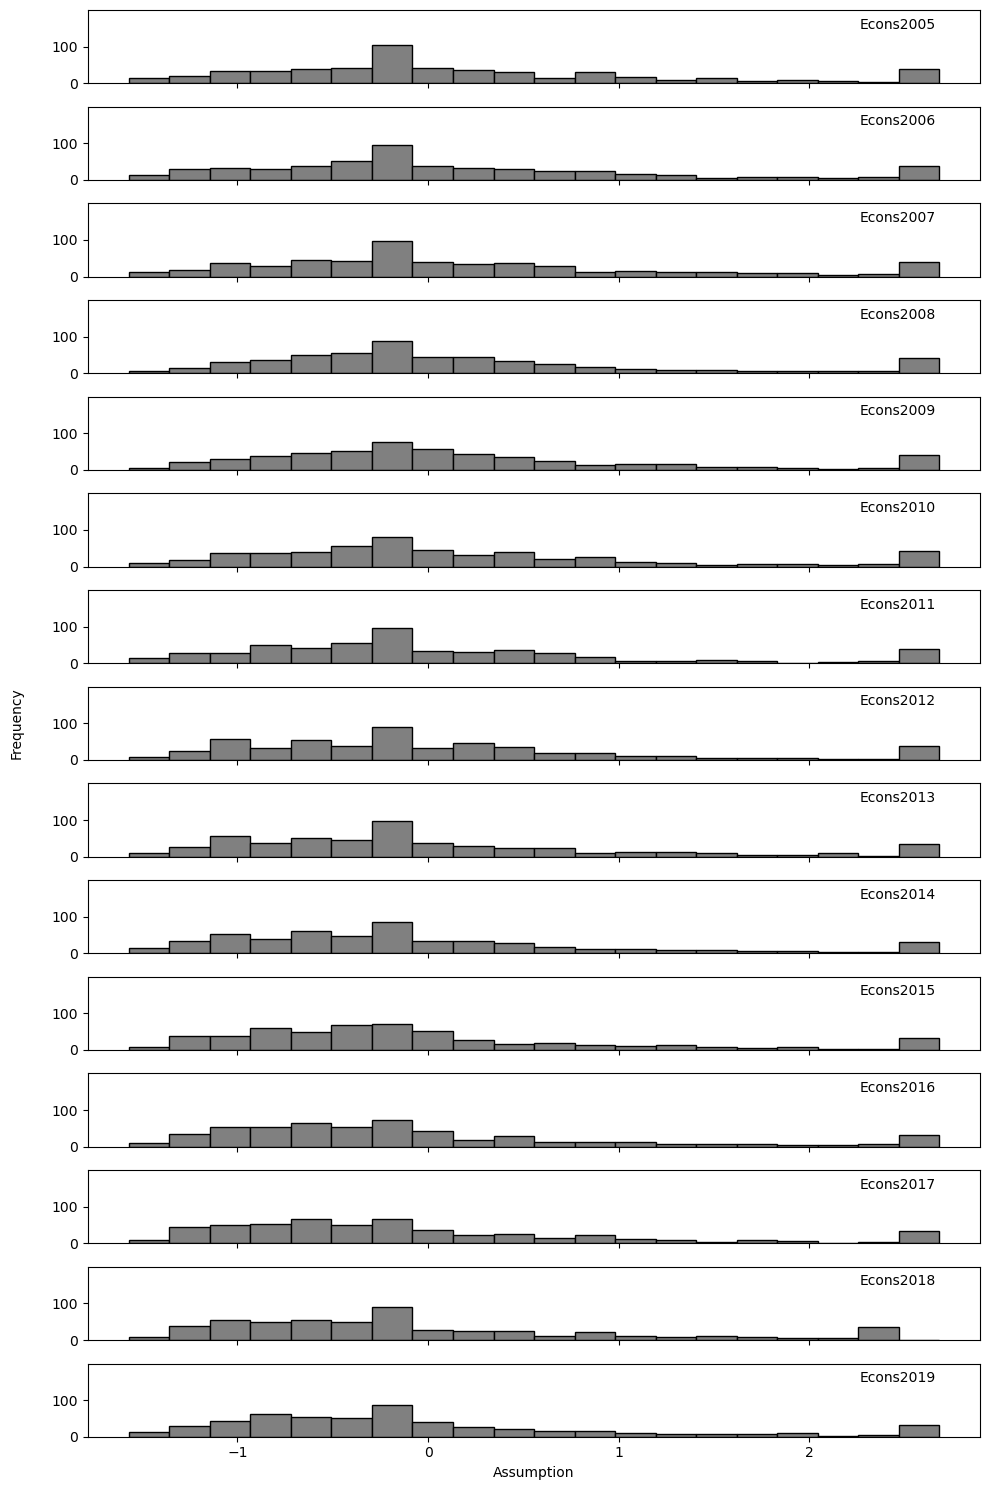

In [260]:
r_data = data[data['PV_FLAG'] == 1]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 100]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 200)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

#### 3.1.10 Main Heat Fuel

##### 1

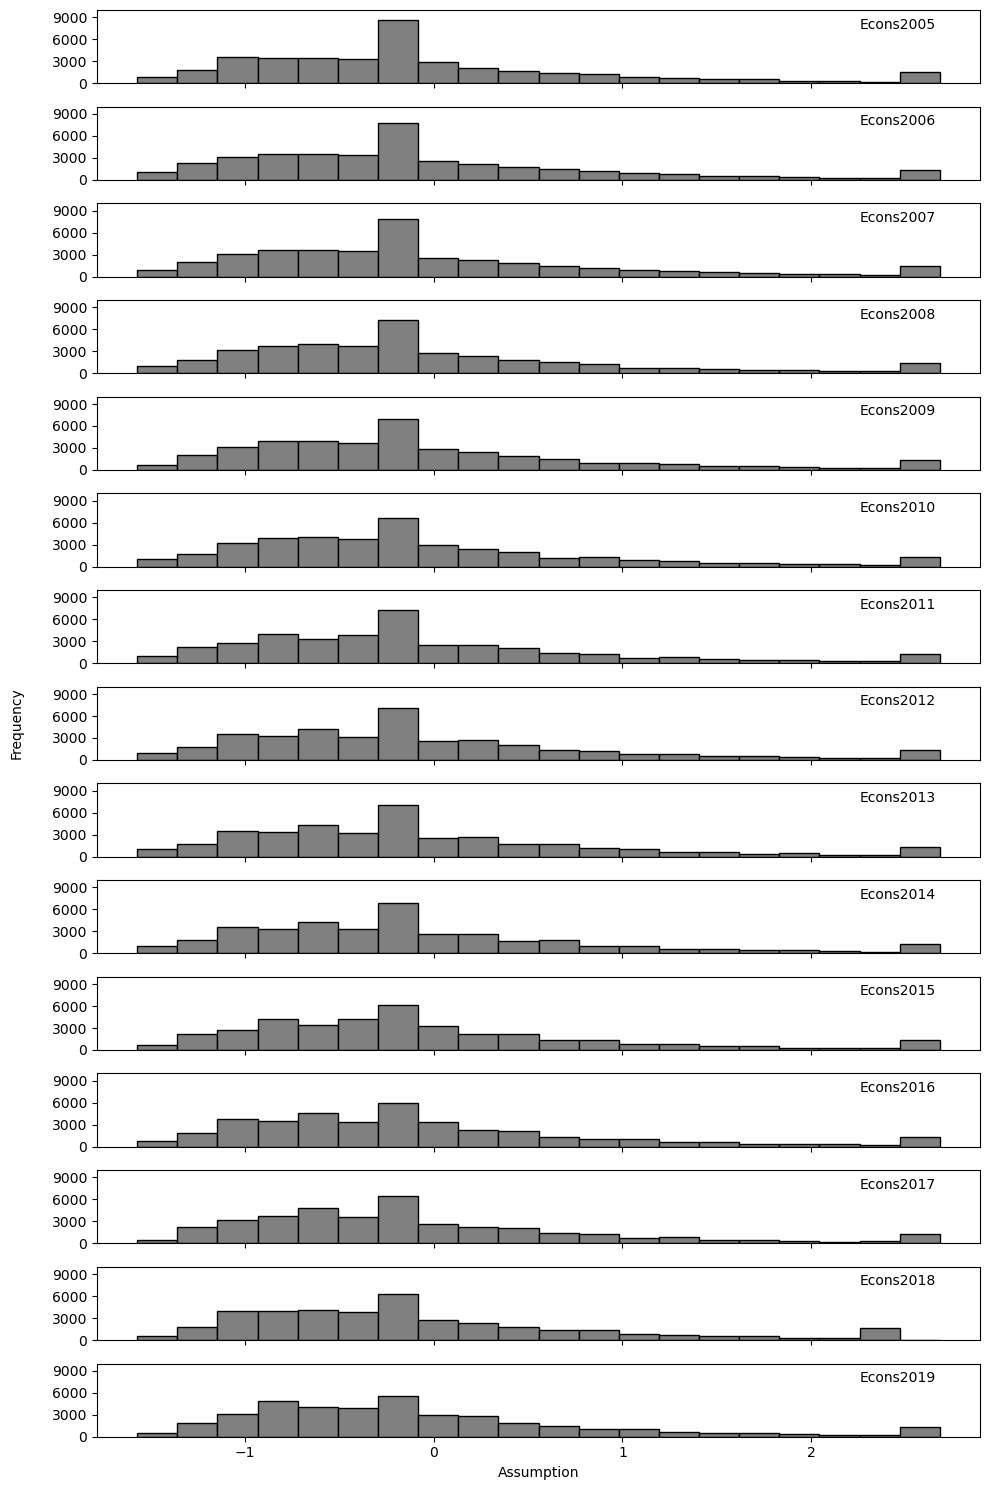

In [266]:
r_data = data[data['MAIN_HEAT_FUEL'] == 1]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 3000,6000,9000]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 10000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()

##### 2

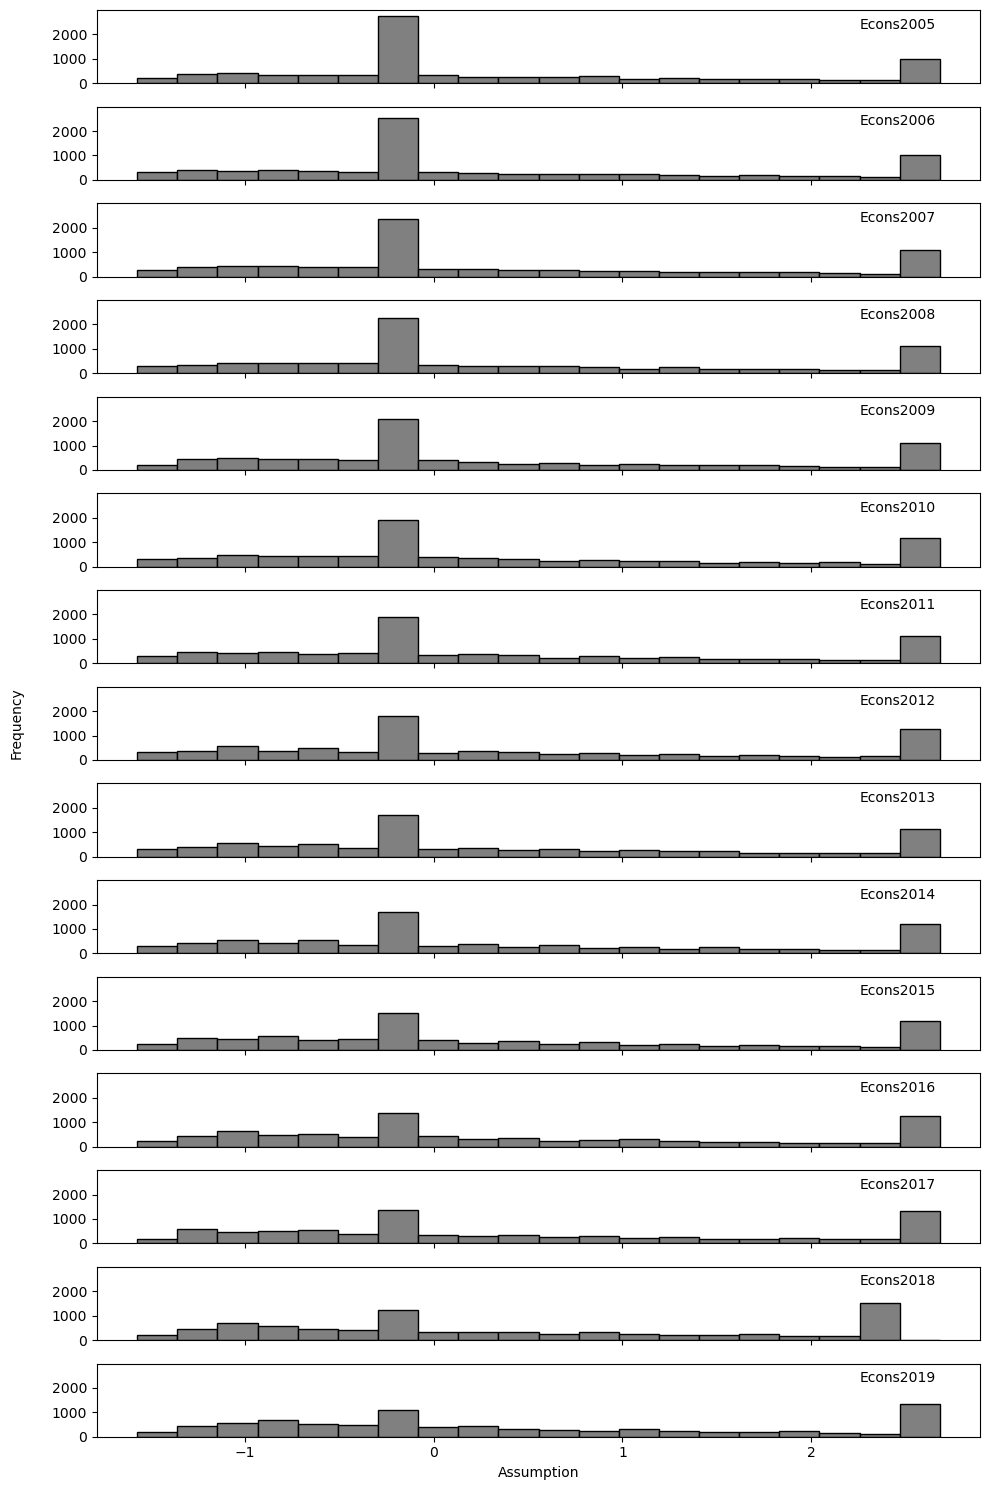

In [270]:
r_data = data[data['MAIN_HEAT_FUEL'] == 2]

all_columns = data.columns.tolist()
econs_columns = [col for col in all_columns if col.startswith('Econs')]
econs_columns_sorted = sorted(econs_columns)
bin_range = (r_data[econs_columns].min().min(), r_data[econs_columns].max().max())
y_ticks = [0, 1000,2000]

fig_width_example = 10  # Width based on the provided example (might need to adjust if exact size is known)
fig_height_example = len(econs_columns_sorted)  # Adjust the height based on the number of subplots

# Create a figure with subplots for each year
fig, axes = plt.subplots(len(econs_columns_sorted), 1, figsize=(fig_width_example, fig_height_example), sharex=True)

# Apply the specifications for each subplot as before
for i, col in enumerate(econs_columns_sorted):
    # Create histogram for each year
    axes[i].hist(r_data[col], bins=20, range=bin_range, color='gray', edgecolor='black')
    axes[i].set_yticks(y_ticks)
    axes[i].set_ylim(0, 3000)
    if i == len(econs_columns_sorted) // 2:
        axes[i].set_ylabel('Frequency', labelpad=20)
    if i < len(econs_columns_sorted) - 1:
        axes[i].tick_params(labelbottom=False)
    else:
        axes[i].set_xlabel('Assumption')

# Move titles to the top right corner
for i, ax in enumerate(axes):
    ax.text(0.95, 0.8, econs_columns_sorted[i], va='center', ha='right', transform=ax.transAxes, fontsize=10)

# Adjust the layout to not overlap and provide space for subplot titles on the right
plt.tight_layout(rect=[0, 0, 1, 1])

# Show the plot
plt.show()